参考: 

https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification

https://www.kaggle.com/code/werus23/g2net-pytorch-with-generated-data

In [1]:
# たまにgpu取れないときあるので取れないときは終わらせる
import torch
if torch.cuda.is_available() == False:
    raise Exception

In [2]:
!nvidia-smi

Sun Dec 18 12:11:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:0E:00.0 Off |                    0 |
| N/A   61C    P0    44W / 300W |      9MiB / 32508MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# papermill parameters
cfg_optimizer = "adamw" # "sam"
device_ids = [0]
epochs = 15
gradient_accumulation_steps = 1
is_syncBN = False

#lr = 5e-3  # 高すぎるみたい
lr = 4e-4

warmup_t = 3
#warmup_t = 1

min_lr_ratio = 1e-2

weight_decay = 1e-5  # 1e-6にしてもほぼ変わらない
#weight_decay = 1e-6

is_wandb = True
is_wandb = False
n_seeds = 1
cfg_seeds = [0]

cfg_apex = True
#cfg_apex = False  # ampなしにしても変わらず

#BATCH_SIZE = 2
#BATCH_SIZE = 8  # 8にしても16と変わらず学習遅くなるだけ
BATCH_SIZE = 16
#BATCH_SIZE = 32  # 32以降ぐらいからbatch上げるとepochごとのスコア安定しない
#BATCH_SIZE = 64
#BATCH_SIZE = 128
#BATCH_SIZE = 384

load_model_path = "none"
#load_model_path = "/volume/kaggle/g2net2/output/tmp/tmp_fold0_seed0_best_score.pth"
#model_cls = "CustomModel"
#model_cls = "CustomModelDrop"
model_cls = "CustomModelMultiOutput"
#model_cls = "CustomModelMultiInput"
#model_cls = "CustomModelLargeKernel"

# https://www.kaggle.com/code/hirune924/2ndplace-solution/notebook
cfg_drop_rate = 0.4
cfg_drop_path_rate = 0.2

#MODEL_NAME = ""
MODEL_NAME = "mobilenetv3_small_050"
#MODEL_NAME = "tf_efficientnetv2_b1"
#MODEL_NAME = "tf_efficientnet_b4_ap"
#MODEL_NAME = "tf_efficientnet_b5_ns"
#MODEL_NAME = "tf_efficientnet_b7_ns"
#MODEL_NAME = "seresnext101d_32x8d"
cfg_pretrained = True

n_fold = 5
#trn_fold = [0,1,2,3,4]
#is_trn_allfold = True
trn_fold = [0]
#trn_fold = "[3]"
is_trn_allfold = False

cfg_scheduler = 'CosineLRScheduler'  # warmup
#cfg_scheduler = 'CosineLRScheduler_cycle_limit3'  # warmup

# data params
cfg_ch = 2
#cfg_step = 64
cfg_step = 128
#cfg_step = 256
#cfg_step = 340
#cfg_step = 512
#cfg_step = 5760
cfg_spec_max = 4096
#cfg_spec_max = 4224  # 33 * 128
#cfg_spec_max = 5760

size_h, size_w = 360, cfg_step
#size_h, size_w = 360, 128
#size_h, size_w = 360, 256

# train+test set stat img  https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-img4096
# np.mean(p.reshape(freq, step, spec_max//step), axis=2)直後の統計値
cfg_p_mean = [2.4080, 2.3525]  # [H1, L1]
cfg_p_std = [0.6578, 0.8358]  # [H1, L1]

#normalize_type = "default-norm|ts-ma"
#normalize_type = "default-norm|p-norm|ts-ma"
#normalize_type = "ts-ma|p-stand"
#normalize_type = "ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-max"
#normalize_type = "ts-ma|p-robustscaler"
#normalize_type = "same_ts_interval|ts-ma|p-stand"
#normalize_type = "largekernel|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma"
normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#normalize_type = "largekernel|p-stand|ts-ma"
#normalize_type = "largekernel"

cfg_is_add_ch = False
cfg_is_train_zip_dataset = False
cfg_prob_mixup = 0.0

#cfg_prob_sample_mixup = 0.0
#cfg_prob_sample_mixup = 0.5
cfg_prob_sample_mixup = 0.8

cfg_is_sample_mixup_use_pseudo = True
#cfg_is_sample_mixup_use_pseudo = False

cfg_prob_add_sample_nega_mixup = 0.0
#cfg_prob_add_sample_nega_mixup = 0.5

#cfg_prob_mean_mixup = 0.0
cfg_prob_mean_mixup = 0.3

#cfg_prob_noise_band = 0.0
cfg_prob_noise_band = 0.3

#cfg_prob_noise_spot = 0.0
cfg_prob_noise_spot = 0.05

#cfg_prob_noise_vline = 0.0
cfg_prob_noise_vline = 0.2

#cfg_prob_noise_hband = 0.0
cfg_prob_noise_hband = 0.2
cfg_prob_noise_hband = 0.5

cfg_prob_spec_start_random = 0.0
#cfg_prob_spec_start_random = 0.5

#cfg_prob_swap_ch_nega = 0.0
cfg_prob_swap_ch_nega = 0.5

#cfg_prob_flip_nega = 0.0
cfg_prob_flip_nega = 0.5

#cfg_prob_swap_nega = 0.0
cfg_prob_swap_nega = 0.5

cfg_prob_vshift_nega = 0.0
#cfg_prob_vshift_nega = 0.5

#cfg_prob_vshift = 0.0
cfg_prob_vshift = 1.0

#cfg_freq_mask_num = 0  # マスクする横線
#cfg_time_mask_num = 0  # マスクする縦線
cfg_freq_mask_num = 2
cfg_time_mask_num = 1
cfg_freq_mask_param = 10
cfg_time_mask_param = 10
#cfg_freq_mask_param = 30
#cfg_time_mask_param = 50

cfg_cv_col = "target"
#cfg_cv_col = "freq_min//10"
#cfg_cv_col = "freq_min//10_target"

cfg_add_split_str = ""
#cfg_add_split_str = "KFold"
#cfg_add_split_str = "StratifiedKFold"

cfg_is_npy = True
#cfg_is_npy = False

FCOFF = 1e22
#FCOFF = 5e22

ADD_DIRS_STR = ""
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1]"
#ADD_DIRS_STR = "[EX003_NOISE, EX004_SIGNAL]"
#ADD_DIRS_STR = "[EX003_NOISE, EX004_SIGNAL, EX004_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX005_SIGNAL, EX005_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX005_SIGNAL1, EX005_SIGNAL_ISO1]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX003_NOISE2, EX004_SIGNAL, EX004_SIGNAL_ISO, EX005_SIGNAL, EX005_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX006_SIGNAL800]"
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800]"

IS_ADD_ALL_TRAIN1 = False
#IS_ADD_ALL_TRAIN1 = True


PSEUDO_CSV = ""
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0761.csv"
cfg_pseudo_max = 0.9
cfg_pseudo_min = 0.1
#cfg_pseudo_max = 0.0  # pseudoの閾値なし
#cfg_pseudo_min = 0.0  # pseudoの閾値なし
#cfg_is_pseudo_hard = True
cfg_is_pseudo_hard = False

cfg_pseudo_type = ""
#cfg_pseudo_type = "real"
#cfg_pseudo_type = "sim"


ADD_PSEUDO_DIRS = ""
ADD_PSEUDO_DIRS = "[EX007_NONSTAT_NOISE800]"


cfg_freq_div_n = 10
#cfg_freq_div_n = 50
#cfg_freq_div_n = 100

cfg_pseudo_sim_max = cfg_pseudo_max
cfg_pseudo_sim_min = cfg_pseudo_min
#cfg_pseudo_sim_max = 0.8
#cfg_pseudo_sim_min = 0.4
#cfg_pseudo_sim_max = 0.0
#cfg_pseudo_sim_min = 0.0

cfg_pseudo_real_max = cfg_pseudo_max
cfg_pseudo_real_min = cfg_pseudo_min

is_matplotlib_agg = False
#is_matplotlib_agg = True  # 可視化なしにする

IS_MAKE_SUB = False
#IS_MAKE_SUB = True

#DEBUG = False
DEBUG = True

# ==============================================================
# kqi_3090_ex075_v2 base Parameters
# ==============================================================
add_name = "_pseudo_multioutput_freq_b5_ap_freq_div_n50"
BATCH_SIZE = 64
MODEL_NAME = "tf_efficientnet_b5_ap"
model_cls = "CustomModelMultiOutput"
epochs = 50
normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
cfg_apex = True
cfg_step = 128
size_w = 128
cfg_is_sample_mixup_use_pseudo = True
cfg_add_split_str = "StratifiedKFold"
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800]"

PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0761.csv"
ADD_PSEUDO_DIRS = "[EX007_NONSTAT_NOISE800]"
cfg_pseudo_max = 0.9
cfg_pseudo_min = 0.1

cfg_is_pseudo_hard = False
cfg_freq_div_n = 50
IS_ADD_ALL_TRAIN1 = False
IS_MAKE_SUB = True
n_fold = 5
#is_trn_allfold = True
#DEBUG = False
# ==============================================================

PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0771.csv"

add_name = ""

In [4]:
# Parameters
add_name = "_tta_pseudo_hvflip_lb0771_1000_sim0000"
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0771.csv"
cfg_pseudo_max = 1.0
cfg_pseudo_min = 0.0
cfg_pseudo_sim_max = 0.0
cfg_pseudo_real_max = -1
is_trn_allfold = True
is_wandb = True
DEBUG = False


In [5]:
# papermillで引数をlistで渡さなかった場合の対策
if isinstance(device_ids, int):
    device_ids = [0]
    
# trn_foldをpapermillで渡したときの対策
if type(trn_fold) is str:
    trn_fold = eval(trn_fold)
    
# 全fold学習
if is_trn_allfold:
    trn_fold = list(range(n_fold))
    
# 複数seedで学習
if n_seeds > 1:
    cfg_seeds = list(range(n_seeds))
    
# ダウンロードしたデータで事前学習する場合はfold=0のみ
if cfg_is_train_zip_dataset:
    trn_fold = [0]
    
# フラグあればch増やす
if cfg_is_add_ch:
    cfg_ch = 2 + 2 
    
# 移動平均の場合は画像の横幅-1する
if "ts-ma" in normalize_type:
    size_w -= 1
    
# フーリエ係数変える場合
if FCOFF != 1e22:
    normalize_type += f"_{str(FCOFF)}"
    
## largekernelを使う場合
#if "largekernel" in normalize_type:
#    cfg_spec_max = 5760
    
# LargeKernelモデルを使う場合
if model_cls == "CustomModelLargeKernel":
    MODEL_NAME = ""
    cfg_step = 5760
    cfg_spec_max = 5760
    size_h, size_w = 360, cfg_step
    normalize_type = "largekernel"
    cfg_prob_mean_mixup = 0.0
    cfg_prob_spec_start_random = 0.0
    cfg_time_mask_param = int( 10 * (cfg_spec_max / 128) )

In [6]:
#import ipynbname
#NAME = ipynbname.name()
if DEBUG:
    NAME = f"tmp"
    #NAME = f"tmp_real"
    #NAME = f"tmp_no-alb"
    #NAME = f"tmp_VerticalFlip"
    #NAME = f"tmp_HorizontalFlip"
    #NAME = f"tmp_no-alb_EX003_NOISE01"
else:
    NAME = f"kqi_3090_ex075_v2{add_name}"
print(NAME)

kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000


# Directory

In [7]:
import os, sys

if "kaggle_web_client" in sys.modules:
    INPUT_DIR_TRAIN = "/kaggle/input/g2net-detecting-continuous-gravitational-waves"
    INPUT_DIR_TEST = "/kaggle/input/g2net-detecting-continuous-gravitational-waves"
    OUTPUT_DIR = f"./output/{NAME}"

elif "/work" in os.getcwd():
    INPUT_DIR_TRAIN = f"/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves"  # SSD
    INPUT_DIR_TEST = f"/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves"  # SSD
    OUTPUT_DIR = f"/volume/kaggle/g2net2/output/{NAME}"  # HDD
    
    # ============================================
    # 生成データのパス
    # ============================================
    EX003_NOISE = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise"  # SSD 500件
    EX003_NOISE1 = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise_1_gap"  # SSD 1000件
    EX003_NOISE2 = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise_2_gap"  # SSD 3000件
    EX003_NOISE5000 = f"/volume/kaggle/g2net2/pyfstat_output/ex003_generating_noise_gap5000"  # HDD 5000件
    EX004_SIGNAL = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex004_generating_signal_gap"  # SSD 200件
    EX004_SIGNAL_ISO = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex004_generating_signal_gap_iso"  # SSD 200件
    EX005_SIGNAL = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex005_generating_signal_gap"  # SSD 400件
    EX005_SIGNAL_ISO = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex005_generating_signal_gap_iso"  # SSD 400件
    EX005_SIGNAL1 = f"/volume/kaggle/g2net2/pyfstat_output/ex005_generating_signal_gap_1"  # HDD 800件
    EX005_SIGNAL_ISO1 = f"/volume/kaggle/g2net2/pyfstat_output/ex005_generating_signal_gap_iso_1"  # HDD 800件
    EX006_NOISE1400 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_noise_gap1400"  # HDD 1400件
    EX006_SIGNAL800 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap800"  # HDD 800件
    EX006_SIGNAL_ISO800 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap_iso800"  # HDD 800件
    EX006_NOISE5000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_noise_gap5000"  # HDD 5000件
    EX006_SIGNAL2000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap2000"  # HDD 2000件
    EX006_SIGNAL_ISO2000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap_iso2000"  # HDD 2000件
    EX007_NONSTAT_NOISE800 = f"/volume/kaggle/g2net2/pyfstat_output/ex007_generating_noise_nonstationary800"  # HDD 800件
    EX007_NONSTAT_NOISE1000 = f"/volume/kaggle/g2net2/pyfstat_output/ex007_generating_noise_nonstationary1000"  # HDD 1000件
    EX008_SIGNAL_D5075_400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d5075_400"  # HDD 400件
    EX008_SIGNAL_D5075_ISO400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d5075_iso400"  # HDD 400件
    
    # ============================================
    # npyの保存先パス
    # ============================================
    NPY_DIR = f"/volume-ssd/kaggle_g2net2/npys"  # SSD
    

elif "/kqi/output" in os.getcwd():
    INPUT_DIR_TRAIN = f"/workspace/g2net2/input"  # cp_SSD
    INPUT_DIR_TEST = f"/kqi/output/g2net-detecting-continuous-gravitational-waves"
    OUTPUT_DIR = f"./output/{NAME}"
    
    # ============================================
    # 生成データのパス
    # ============================================
    _dir = f"/workspace/g2net2/pyfstat_output/{normalize_type}"
    EX003_NOISE = f"{_dir}/ex003_generating_noise"  # SSD 500件
    EX003_NOISE1 = f"{_dir}/ex003_generating_noise_1_gap"  # SSD 1000件
    EX003_NOISE2 = f"{_dir}/ex003_generating_noise_2_gap"  # SSD 3000件
    EX003_NOISE5000 = f"{_dir}/ex003_generating_noise_gap5000"  # SSD 5000件
    EX004_SIGNAL = f"{_dir}/ex004_generating_signal_gap"  # SSD 200件
    EX004_SIGNAL_ISO = f"{_dir}/ex004_generating_signal_gap_iso"  # SSD 200件
    EX005_SIGNAL = f"{_dir}/ex005_generating_signal_gap"  # SSD 400件
    EX005_SIGNAL_ISO = f"{_dir}/ex005_generating_signal_gap_iso"  # SSD 400件
    EX005_SIGNAL1 = f"{_dir}/ex005_generating_signal_gap_1"  # SSD 800件
    EX005_SIGNAL_ISO1 = f"{_dir}/ex005_generating_signal_gap_iso_1"  # SSD 800件
    EX006_NOISE1400 = f"{_dir}/ex006_generating_noise_gap1400"  # SSD 1400件
    EX006_SIGNAL800 = f"{_dir}/ex006_generating_signal_gap800"  # SSD 800件
    EX006_SIGNAL_ISO800 = f"{_dir}/ex006_generating_signal_gap_iso800"  # SSD 800件
    EX006_NOISE5000 = f"{_dir}/ex006_generating_noise_gap5000"  # SSD 5000件
    EX006_SIGNAL2000 = f"{_dir}/ex006_generating_signal_gap2000"  # SSD 2000件
    EX006_SIGNAL_ISO2000 = f"{_dir}/ex006_generating_signal_gap_iso2000"  # SSD 2000件
    EX007_NONSTAT_NOISE800 = f"{_dir}/ex007_generating_noise_nonstationary800"  # SSD 800件
    EX007_NONSTAT_NOISE1000 = f"{_dir}/ex007_generating_noise_nonstationary1000"  # SSD 1000件
    EX008_SIGNAL_D5075_400 = f"{_dir}/ex008_generating_signal_d5075_400"  # SSD 400件
    EX008_SIGNAL_D5075_ISO400 = f"{_dir}/ex008_generating_signal_d5075_iso400"  # SSD 400件
    
    # ============================================
    # npyの保存先パス
    # ============================================
    NPY_DIR = f"/workspace/g2net2/pyfstat_output"  # SSD
    
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(OUTPUT_DIR)

./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000


# Data

In [8]:
import os, sys
import shutil
import cv2
import glob
import random
import h5py
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler

pd.set_option('display.max_columns', None)

if is_matplotlib_agg:
    import matplotlib
    matplotlib.use('Agg')
    from matplotlib import pyplot as plt
else:
    from matplotlib import pyplot as plt

In [9]:
%reload_ext autoreload
%autoreload 2
from src.zip_dataset import ZipDataset
from src import largekernel

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [10]:
if cfg_is_train_zip_dataset:
    
    zip_path = f'{INPUT_DIR_TRAIN}/../g2net-generated-signals'
    zip_mod = 100
    zip_dataset = ZipDataset(path=f'{zip_path}/archive', mod=zip_mod)
    
    # ZipDatasetのラベルをcsvにしておく
    if os.path.exists(f'{zip_path}/zip_df.csv') == False:
        zip_labels = []
        zip_paths = []
        for i, (img, y) in tqdm(enumerate(zip_dataset), total=len(zip_dataset)):
            y = int(y)
            zip_labels.append(y)
            zip_paths.append(f'{zip_path}/archive/{y}_data_{zip_mod*(1+(i)//zip_mod)}/signals_{i%zip_mod}.npy')
            if i == 14900-1:
                break
        zip_df = pd.DataFrame({"id": range(len(zip_labels)), 
                               "target": zip_labels,
                               "path": zip_paths,
                               "fold": -1,
                              })
        zip_df.to_csv(f'{zip_path}/zip_df.csv', index=False)
        

#train_df = pd.read_csv(INPUT_DIR_TRAIN + '/train_labels.csv')
# https://www.kaggle.com/code/anonamename/eda-g2net2-detecting-continuous-gw/data?scriptVersionId=109790473
train_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/train_summary.csv").rename(columns={"Unnamed: 0":'id'})
train_df["path"] = INPUT_DIR_TRAIN + "/train/" + train_df["id"] + ".hdf5"
train_df = train_df[train_df.target >= 0]  # Remove 3 unknowns (target = -1)
train_df["orig"] = 1  # オリジナルデータのフラグ
# 画像の平均、標準偏差列追加
# https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-ma-img4096?scriptVersionId=110505352
train_ma_img_mean_std = pd.read_csv(f"./kaggle_dl/g2net2_mean_std_calc_ma_img4096_v2/train_mean_std.csv").drop(['target'], axis=1)
train_df = pd.merge(train_df, train_ma_img_mean_std, on="id")
print("train_df.shape:", train_df.shape)
#display(train_df)
#print(train_df["freq_min//10"].max(), train_df["freq_min//10"].min())

# MultiOutputに使う freq_min//N 列をつくる
train_df["freq_min//N"] = train_df["freq min"] // cfg_freq_div_n
print(train_df["freq_min//N"].max(), train_df["freq_min//N"].min())

#test_df = pd.read_csv(INPUT_DIR_TEST + '/sample_submission.csv')
# https://www.kaggle.com/code/anonamename/eda-g2net2-detecting-continuous-gw/data?scriptVersionId=109790473
test_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/test_summary.csv").rename(columns={"Unnamed: 0":'id'})
test_df["target"] = 0.5
test_df["path"] = INPUT_DIR_TEST + "/test/" + test_df["id"] + ".hdf5"
test_df["orig"] = 1  # オリジナルデータのフラグ
test_df["freq_min//10"] = test_df["freq min"]//10
# 画像の平均、標準偏差列追加
# https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-ma-img4096?scriptVersionId=110505352
test_ma_img_mean_std = pd.read_csv(f"./kaggle_dl/g2net2_mean_std_calc_ma_img4096_v2/test_mean_std.csv").drop(['target'], axis=1)
test_df = pd.merge(test_df, test_ma_img_mean_std, on="id")

# リアルデータ/シュミレーションデータを区別するためのタイムスタンプのブロックごとでの標準偏差の差の列を追加
# stddiff == 0 はタイムスタンプのブロックごとでの差がない（=ガウスノイズ）なのでシュミレーションデータ
# https://www.kaggle.com/code/anonamename/g2net2-winning-strategy-with-external-data?scriptVersionId=112011488
df_stat_test = pd.read_csv(f"./kaggle_dl/g2net2-winning-strategy-with-external-data_v1/df_stat_test.csv").drop(['fname'], axis=1)
test_df = pd.merge(test_df, df_stat_test, on="id")

# リアルデータとシュミレーションデータのフラグ
_real_sim_flags = test_df["h1_stddiff"] + test_df["l1_stddiff"]
_real_sim_flags = _real_sim_flags.to_numpy()
test_df["real_sim"] = np.array([1 if _f > 0 else 0 for _f in _real_sim_flags])  # リアルデータ=1,シュミレーションデータ=0
print("test real_sim_flags:")
print(test_df["real_sim"].value_counts())

print("test_df.shape:", test_df.shape)
#display(test_df)
#print(test_df["freq_min//10"].max(), test_df["freq_min//10"].min())

# MultiOutputに使う freq_min//N 列をつくる
test_df["freq_min//N"] = test_df["freq min"] // cfg_freq_div_n
print(test_df["freq_min//N"].max(), test_df["freq_min//N"].min())


train_df.shape: (600, 22)
9.0 1.0
test real_sim_flags:
0    6478
1    1497
Name: real_sim, dtype: int64
test_df.shape: (7975, 29)
10.0 0.0


In [11]:
# ==================================================
# test_dfをリアルデータ/シュミレーションデータだけにする
# ==================================================
if cfg_pseudo_type == "real":
    test_df = test_df[(test_df["h1_stddiff"] + test_df["l1_stddiff"] > 0)].reset_index(drop=True)  #  shape: (1497, xxx)
elif cfg_pseudo_type == "sim":
    test_df = test_df[(test_df["h1_stddiff"] + test_df["l1_stddiff"] == 0)].reset_index(drop=True)  #  shape: (6478, xxx)
print("test_df.shape:", test_df.shape)

test_df.shape: (7975, 30)


In [12]:
# ==================================================
# 学習に使う生成データのパスやラベルをcsvにする
# ==================================================
if ADD_DIRS_STR != "":
    add_df_all = None
    for _add_dir in eval(ADD_DIRS_STR):
        if "/kqi/output" in os.getcwd():
            _suff = ".npy"
        else:
            _suff = ".hdf5"
        if "generating_noise" in _add_dir:
            _target = 0
        else:
            _target = 1
        add_df = pd.DataFrame({"path": sorted(glob.glob(f"{_add_dir}/*{_suff}")), 
                               "target": _target})
        add_df["id"] = [Path(p).stem for p in add_df["path"]]
        add_df["sqrtSX"] = add_df["id"].apply(lambda x: x.split("_")[1].split("sqrtSX")[1])
        add_df["F0"] = add_df["id"].apply(lambda x: x.split("_")[2].split("F0")[1])

        if "_signal" in _add_dir:
            add_df["F1"] = add_df["id"].apply(lambda x: x.split("_")[3].split("F1")[1])
            add_df["h0deg"] = add_df["id"].apply(lambda x: x.split("_")[4].split("h0deg")[1])

        add_df["type"] = add_df["id"].apply(lambda x: x.split("_")[-1])

        # どのデータかわかるようにディレクトリの名前残しとく
        add_df["dir_name"] = Path(_add_dir).name

        if "ex003_generating_noise" in _add_dir: 
            # gapデータだけにする
            add_df = add_df[add_df["type"] == "gap"]

            ## segmentデータだけにする
            #add_df = add_df[add_df["type"] != "gap"]
            
        # df_summary.csv 連結
        _sum_df = pd.read_csv(f"{_add_dir}/df_summary.csv").drop("target", axis=1)
        add_df = pd.merge(add_df, _sum_df, on="id")

        # MultiOutputに使う freq_min//N 列をつくる
        add_df["freq_min//N"] = add_df["freq min"] // cfg_freq_div_n
        print(add_df["freq_min//N"].max(), add_df["freq_min//N"].min())
        
        if add_df is None:
            add_df_all = add_df
        else:
            add_df_all = pd.concat([add_df_all, add_df]).reset_index(drop=True)

    add_df_all.to_csv(f"{OUTPUT_DIR}/add_data.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("add_df_all.shape:", add_df_all.shape)
    #display(add_df_all)
    #print(add_df_all["freq_min//10"].value_counts())
    #print(add_df_all["freq_min//10"].max(), add_df_all["freq_min//10"].min())

9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
add_df_all.shape: (8400, 24)


In [13]:
pseudo_df = pd.read_csv(PSEUDO_CSV)
pseudo_df.sort_values("target")

id    target
3283  698567d90  0.101208
4164  851d75528  0.199860
925   1e85f128e  0.206511
2153  44dd7e761  0.206812
5106  a474bef22  0.207187
...         ...       ...
1005  211108cc0  0.998498
5230  a8aaa9755  0.998518
1310  2a180c12a  0.998548
1522  3022e8994  0.998618
5975  bf3baa13d  0.998672

[7975 rows x 2 columns]

9.0 0.0


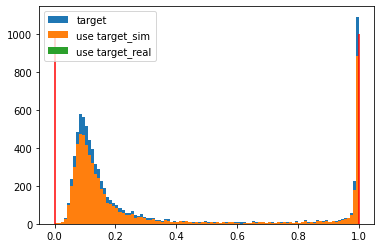

pseudo_df.shape: (6478, 30)


In [14]:
# ==================================================
# for Pseudo
# ==================================================
from sklearn.preprocessing import MinMaxScaler

if PSEUDO_CSV != "":
    pseudo_df = pd.read_csv(PSEUDO_CSV)
    pseudo_df["path"] = INPUT_DIR_TEST + "/test/" + pseudo_df["id"] + ".hdf5"
    #display(pseudo_df)
    
    # 最小値に外れ値があるのでclip
    pseudo_df["target"] = np.clip(pseudo_df["target"], 0.2, None)
    
    pseudo_df = pd.merge(pseudo_df, test_df[["id", "real_sim"]], on="id")
    
    # 確信度0-1に正規化
    pseudo_df["target"] = MinMaxScaler().fit_transform(pseudo_df["target"].values.reshape(-1, 1))
    #display(pseudo_df)
    
    # 分布可視化
    plt.hist(pseudo_df["target"], bins=100, label="target")
    
    p_sim_df = pseudo_df[pseudo_df["real_sim"] == 0].copy()
    p_real_df = pseudo_df[pseudo_df["real_sim"] == 1].copy()
    
    # 確信度が高い低いものだけ採用。0なら全部入れる
    if cfg_pseudo_max > 0:
        pseudo_df = pseudo_df[ (pseudo_df["target"] > cfg_pseudo_max) | (pseudo_df["target"] < cfg_pseudo_min) ].reset_index(drop=True)
        #display(pseudo_df)
        
    # simデータが高い低いものだけ採用
    if cfg_pseudo_sim_max > 0:
        p_sim_df = p_sim_df[ (p_sim_df["target"] > cfg_pseudo_sim_max) | (p_sim_df["target"] < cfg_pseudo_sim_min) ].reset_index(drop=True)
        pseudo_df = pd.concat([pseudo_df, p_sim_df]).drop_duplicates()
    elif cfg_pseudo_sim_max == 0:
        # 0なら全部入れる
        pseudo_df = pd.concat([pseudo_df, p_sim_df]).drop_duplicates()
    elif cfg_pseudo_sim_max == -1:
        # -1なら追加なし
        pass
        
    # realデータが高い低いものだけ採用
    if cfg_pseudo_real_max > 0:
        p_real_df = p_sim_df[ (p_sim_df["target"] > cfg_pseudo_real_max) | (p_sim_df["target"] < cfg_pseudo_real_min) ].reset_index(drop=True)
        pseudo_df = pd.concat([pseudo_df, p_real_df]).drop_duplicates()
    elif cfg_pseudo_real_max == 0:
        # 0なら全部入れる
        pseudo_df = pd.concat([pseudo_df, p_real_df]).drop_duplicates()
    elif cfg_pseudo_real_max == -1:
        # -1なら追加なし
        pass
        
    # ハードラベルにする
    if cfg_is_pseudo_hard:
        pseudo_df.loc[pseudo_df["target"] >= 0.5, "target"] = 1
        pseudo_df.loc[pseudo_df["target"] < 0.5, "target"] = 0
        pseudo_df["target"] = pseudo_df["target"].astype(int)
        #display(pseudo_df)
        print("pseudo_df['target'].value_counts():")
        print(pseudo_df["target"].value_counts())
        pseudo_df.target.plot.hist()
        plt.show()
        
    # test setと同じサイズに変更
    pseudo_df = pd.merge(pseudo_df[["id", "target"]], test_df.drop("target", axis=1), on="id").reset_index(drop=True)
    
    # MultiOutputに使う freq_min//N 列をつくる
    pseudo_df["freq_min//N"] = pseudo_df["freq min"] // cfg_freq_div_n
    print(pseudo_df["freq_min//N"].max(), pseudo_df["freq_min//N"].min())
    
    # 分布可視化
    plt.hist(pseudo_df.loc[pseudo_df["real_sim"]==0, "target"], bins=100, label="use target_sim")
    plt.hist(pseudo_df.loc[pseudo_df["real_sim"]==1, "target"], bins=100, label="use target_real")
    plt.vlines(cfg_pseudo_max, 0, 1000, colors="red")
    plt.vlines(cfg_pseudo_min, 0, 1000, colors="red")
    plt.legend()
    plt.show()
    plt.clf()  # メモリ解放
    plt.close()
    
    pseudo_df.to_csv(f"{OUTPUT_DIR}/pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("pseudo_df.shape:", pseudo_df.shape)
    #display(pseudo_df)
    #print(pseudo_df["freq_min//10"].value_counts())
    #print(pseudo_df["freq_min//10"].max(), pseudo_df["freq_min//10"].min())

In [15]:
# ==================================================
# for Pseudo 追加
# ==================================================
if ADD_PSEUDO_DIRS != "":
    
    add_pseudo_df = None
    for _add_dir in eval(ADD_PSEUDO_DIRS):
        if "/kqi/output" in os.getcwd():
            _suff = ".npy"
        else:
            _suff = ".hdf5"
    
        _add_df = pd.read_csv(_add_dir + "/df.csv")
        _add_df["path"] = _add_dir + "/" + _add_df["id"] + _suff
        
        if add_pseudo_df is None:
            add_pseudo_df = _add_df
        else:
            add_pseudo_df = pd.concat([add_pseudo_df, _add_df]).reset_index(drop=True)
            
        # df_summary.csv 連結
        _sum_df = pd.read_csv(f"{_add_dir}/df_summary.csv").drop("target", axis=1)
        add_pseudo_df = pd.merge(add_pseudo_df, _sum_df, on="id")

        # MultiOutputに使う freq_min//N 列をつくる
        add_pseudo_df["freq_min//N"] = add_pseudo_df["freq min"] // cfg_freq_div_n
        print(add_pseudo_df["freq_min//N"].max(), add_pseudo_df["freq_min//N"].min())

    add_pseudo_df.to_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("add_pseudo_df.shape:", add_pseudo_df.shape)
    #display(add_pseudo_df)
    #print(add_pseudo_df["freq_min//10"].value_counts())
    #print(add_pseudo_df["freq_min//10"].max(), add_pseudo_df["freq_min//10"].min())

9.0 1.0
add_pseudo_df.shape: (796, 18)


In [16]:
#=====

In [17]:
if cfg_spec_max == 4096:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd/notebook?scriptVersionId=109593703
    # shape: (360, 4096)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2_Mean_PSD_v2/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2_Mean_PSD_v2/df_DET_L1.npy")  # データセットの移動平均の絶対値
elif cfg_spec_max == 4279:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd-spec-max4279?scriptVersionId=110466908
    # shape: (360, 4279)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2-mean-psd-spec-max4279_v1/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2-mean-psd-spec-max4279_v1/df_DET_L1.npy")  # データセットの移動平均の絶対値
elif cfg_spec_max == 5760:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd-largekernel-abs?scriptVersionId=111603297
    # shape: (360, 5760)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2-mean-psd-largekernel-abs_v1/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2-mean-psd-largekernel-abs_v1/df_DET_L1.npy")  # データセットの移動平均の絶対値


In [18]:
# ====================================================================================
# 前処理の helper 関数
# ====================================================================================
def get_cut_ids(ts, step: int):
    """同程度の時間幅になるタイムスタンプのインデックスを取得"""
    full_length = ts.max() - ts.min() + 1
    cut_length = full_length // step  # この時間単位でidx取得する
    cut_ids = [0] 
    _store = 0
    for i in range(1, len(ts)):
        _store += ts[i] - ts[i-1]
        if _store > cut_length:
            cut_ids.append(i)
            _store = 0
    if cut_ids[-1] != len(ts) - 1:
        cut_ids += [len(ts) - 1] 
    return cut_ids  # リストの長さはstepより少ないので注意すること


def standardization(x , mu: float, std: float, max_pixel_value=None):
    """標準化"""
    if max_pixel_value is None:
        return (x - mu) / std
    else:
        # https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Normalize
        return (x - mu * max_pixel_value) / (std * max_pixel_value)

    
def a2p(a):
    """振幅をパワーに変換"""
    a = a[:,:]
    a = a * FCOFF
    #a = a * 1e22  # Fourier coefficient complex64  # 正規化しない場合ではこの係数だと振幅大きいデータでnanになる
    #a = a * 1e21
    #a = a * 1e20  # 振幅低くなりすぎて精度でない
    p = a.real**2 + a.imag**2  # power. shape=(360, 4224など)
    return p


def power_norm(p, norm_type: str, s: str = ""):
    """パワーを正規化"""
    if "p-norm" in norm_type:
        # normalize
        p /= np.mean(p)
    elif "p-stand" in norm_type:
        # チャネルごとの平均と標準偏差で標準化
        p = standardization(p, p.mean(), p.std())
    elif "p-common-stand" in norm_type:
        # データセット全体の統計値で標準化
        if s == "H1":
            p = standardization(p, cfg_p_mean[0], cfg_p_std[0])
        else:
            p = standardization(p, cfg_p_mean[1], cfg_p_std[1])
    elif "p-max" in norm_type:
        # 最大値で割って0-1にする
        p /= np.max(p)
        # MinMaxScaler
        #p = MinMaxScaler().fit_transform(p)
    elif "p-robustscaler" in norm_type:
        # RobustScaler
        p = RobustScaler().fit_transform(p)
    return p


def power_a_comp(p, step: int, spec_max: int, freq: int, norm_type: str):
    """パワーをtimestepsごとに平均+resizeして圧縮する"""
    if "ts-ma" in norm_type:
        ### timestepsごとに移動平均. compress 4096 -> 127
        
        # https://www.kaggle.com/anonamename/g2net2-exporing-test-train-datasets
        n_ma = spec_max//step

        # 累積合計を計算。 np.cumsum(np.array([1, 2, 3, 4, 5, 6])): [ 1  3  6 10 15 21]
        power_ma_cumsum = np.cumsum(p, axis=1)  

        # 累積合計をMA個の要素ごとの平均とる
        power_ma_cumsum_0 = np.concatenate((np.zeros((p.shape[0],1)), power_ma_cumsum), axis=1)[:,::n_ma]  

        # 累積合計を平均で引き算。numpy.diff() は受け取った配列の隣り合う要素同士の差分をとる
        p = np.diff(power_ma_cumsum_0, axis=1)[:,:-1]/n_ma  
        
    elif "ts-a" in norm_type:
        # timestepsごとに平均. compress 4096 -> 128
        p = np.mean(p.reshape(freq, step, spec_max//step), axis=2)
        
    return p

def power_img_clip(img):
    """
    H1とL1でパワーの最大値が違いすぎる画像はノイズっぽいので、最大値が小さい方のチャネルを基準にして最大値大きい方のチャネルの値をクリッピングする
    """
    #th_max = 1.5
    th_max = 2.0
    th_clip = 1.25
    #print(np.max(img[0]), np.max(img[1]))
    if (np.max(img[0]) > np.max(img[1])*th_max):  # 一方のチャネルよりも最大値が th_max 倍も大きい場合
        img[0] = np.clip(img[0], None, np.max(img[1])*th_clip)  # 値小さい方のチャネルの最大値 x th_clip の値で閾値以上の部分クリッピング
        
        _x_clip = img[0][img[0] == np.max(img[1])*th_clip]  # クリッピング部分
        _x_other = img[0][img[0] != np.max(img[1])*th_clip]  # クリッピングしてない部分
        
        # クリッピングしてない部分の平均と標準偏差でガウスノイズ生成してクリッピング部分の値を置き換える
        img[0][img[0] == np.max(img[1])*th_clip] = np.random.normal(np.mean(_x_other), np.std(_x_other), _x_clip.shape)
        
        #img[0] = RobustScaler().fit_transform(img[0])
        
    if (np.max(img[1]) > np.max(img[0])*th_max):  # 一方のチャネルよりも最大値が th_max 倍も大きい場合
        img[1] = np.clip(img[1], None, np.max(img[0])*th_clip)  # 値小さい方のチャネルの最大値 x th_clip の値で閾値以上の部分クリッピング
        
        _x_clip = img[1][img[1] == np.max(img[0])*th_clip]  # クリッピング部分
        _x_other = img[1][img[1] != np.max(img[0])*th_clip]  # クリッピングしてない部分
        
        # クリッピングしてない部分の平均と標準偏差でガウスノイズ生成してクリッピング部分の値を置き換える
        img[1][img[1] == np.max(img[0])*th_clip] = np.random.normal(np.mean(_x_other), np.std(_x_other), _x_clip.shape)
        
        #img[1] = RobustScaler().fit_transform(img[1])

    return img

# ====================================================================================
# 前処理のメイン関数
# ====================================================================================
def amp2power(a, s, step, spec_max, norm_type, freq, ts=None):
    """振幅をパワーに変換して前処理も実行するメイン関数"""
    
    if "spec-sequence_a" in norm_type:
        ### gap区切りでパワーを圧縮してから正規化
        # 振幅をパワーに変換
        p = a2p(a)

        # 1つ隣のタイムポイントで引き算して+1800。基本の間隔は1800なので連続して計測してる場合は0になる
        gap_length = ts[1:] - (ts[:-1] + 1800)  

        # 隣接データでタイムポイントが0以上になった1800以上空いてるデータ点のインデックスのリスト
        gap_length_nonzero_idx = np.argwhere(gap_length != 0).flatten()
        #gap_length_nonzero_idx = gap_length_nonzero_idx[::2]  # 1つ飛ばしでidx取る場合

        # gapがある時刻区切りで平均化
        p_sequence_a = np.empty((freq, len(gap_length_nonzero_idx)+1), dtype=np.float32)
        s_idx = 0
        for i, e_idx in enumerate(gap_length_nonzero_idx):
            #print(i, s_idx, e_idx, np.mean(p[:,s_idx:e_idx], axis=1).shape, p_sequence_a[:,i].shape)
            p_sequence_a[:,i] = np.mean(p[:,s_idx:e_idx], axis=1)
            s_idx = e_idx
        if e_idx != len(gap_length_nonzero_idx)-1:
            p_sequence_a[:,-1] = np.mean(p[:,e_idx:], axis=1)

        # 後続処理のためstep単位のサイズにしておく
        spec_max = step*(p_sequence_a.shape[1]//step)
        p = p_sequence_a[:,:spec_max]
    
        p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
        p = power_norm(p, norm_type, s=s)  # パワーを正規化
        
    else:
        if "default-norm" in norm_type:
            ### パワーを正規化してから圧縮(public NBの前処理)
            p = a2p(a)  # 振幅をパワーに変換
            p = power_norm(p, norm_type, s=s)  # パワーを正規化
            p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
        else:
            ### パワーを圧縮してから正規化
            p = a2p(a)  # 振幅をパワーに変換
            p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
            p = power_norm(p, norm_type, s=s)  # パワーを正規化
            
    return p


# https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification
def hdf5_to_img(h_path, step, spec_max, 
                norm_type=normalize_type, 
                ch=2, 
                freq=360,
               ):
    """hdf5ファイルロードしてパワーの画像に変換する"""
    
    if "largekernel" in norm_type:
        # publicNBの前処理
        # https://www.kaggle.com/code/laeyoung/g2net-large-kernel-inference/notebook
        if "p-robustscaler" in norm_type:
            fid, power, h1_m, l1_m = largekernel.dataload(h_path, is_robustscaler=True)
        else:
            fid, power, h1_m, l1_m = largekernel.dataload(h_path, is_robustscaler=False)
        ps = largekernel.preprocess(1, power, h1_m, l1_m, is_cuda=False, is_tta=True)[0]
        
        ## パワー圧縮前に外れ値クリッピング
        #if "clip" in norm_type:
        #    ps = power_img_clip( np.stack([ ps[0], ps[1] ] ) )
        
        p_h1 = power_a_comp(ps[0], step, 5760, freq, norm_type)  # パワーを圧縮
        p_l1 = power_a_comp(ps[1], step, 5760, freq, norm_type)  # パワーを圧縮
        img = np.stack([ p_h1, p_l1 ] ).astype(np.float32)
        
        # パワー圧縮後に外れ値クリッピング
        if "clip" in norm_type:
            img = power_img_clip(img)
        
        return img
    
    file_id = Path(h_path).stem
    img = None
    with h5py.File(h_path, 'r') as f:
        g = f[file_id]
        
        a_h1, ts_h1 = g["H1"]['SFTs'][:], g["H1"]['timestamps_GPS'][:]
        a_l1, ts_l1 = g["L1"]['SFTs'][:], g["L1"]['timestamps_GPS'][:]
        
        ## 振幅の外れ値クリッピング
        #if "clip" in norm_type:
        #    a_clip = power_img_clip( np.stack([ a_h1, a_l1 ] ) )
        #    a_h1, a_l1 = a_clip[0], a_clip[1]
        
        if "same_ts_interval" in norm_type:
            ### H1,L1のズレを軽減するために、同じ時間間隔でパワーを平均してから正規化
            
            # 同程度の時間幅になるタイムスタンプのインデックスを取得
            h1_cut_ids = get_cut_ids(ts_h1, step+10)  # stepより小さくなるから大きめに取る
            l1_cut_ids = get_cut_ids(ts_l1, step+10)  # stepより小さくなるから大きめに取る
            #print(len(ts_h1), h1_cut_ids)
            #print(len(ts_l1), l1_cut_ids)
            
            # サイズ揃える
            n_min = min(len(h1_cut_ids), len(l1_cut_ids))
            img = np.empty((ch, freq, n_min-1), dtype=np.float32)
            p_h1 = a2p(a_h1)
            p_l1 = a2p(a_l1)
            for i in range(1, n_min):
                img[0,:,i-1] = np.mean(p_h1[:,h1_cut_ids[i-1]:h1_cut_ids[i]], axis=1)  # パワーを圧縮
                img[1,:,i-1] = np.mean(p_l1[:,l1_cut_ids[i-1]:l1_cut_ids[i]], axis=1)  # パワーを圧縮
            img[0] = power_norm(img[0], norm_type, s="H1")  # パワーを正規化
            img[1] = power_norm(img[1], norm_type, s="L1")  # パワーを正規化
            if "ts-ma" in norm_type:
                img = img[:,:,:step-1]
            else:
                img = img[:,:,:step]
            #print(img.shape)
            
        else:
            ### 振幅をパワーに変換
            p_h1 = amp2power(a_h1, "H1", step, spec_max, norm_type, freq, ts=ts_h1)
            p_l1 = amp2power(a_l1, "L1", step, spec_max, norm_type, freq, ts=ts_l1)
            # サイズ揃える
            min_len = min(p_h1.shape[1], p_l1.shape[1])
            img = np.stack([ p_h1[:,:min_len], p_l1[:,:min_len] ] ).astype(np.float32)
            
        # パワー圧縮後に外れ値クリッピング
        if "clip" in norm_type:
            img = power_img_clip(img)
        
    return img

# Quick EDA

In [19]:
def show_1img_2ch(img):
    
    if normalize_type == "default_3ch":
        plt.figure(figsize=(20, 12))
        
        for i in range(img.shape[0]):
            plt.subplot(1, 6, i+1)
            plt.title('Spectrogram')
            plt.xlabel('time')
            plt.ylabel('frequency')
            plt.imshow(img[i])
            plt.colorbar()
            
        plt.tight_layout()
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()
    else:
        plt.figure(figsize=(10, 10))
        
        plt.subplot(1, 2, 1)
        plt.title('H1 Spectrogram')
        plt.xlabel('time')
        plt.ylabel('frequency')
        plt.imshow(img[0])
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.title('L1 Spectrogram')
        plt.xlabel('time')
        plt.ylabel('frequency')
        plt.imshow(img[1])
        plt.colorbar()

        plt.tight_layout()
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()

In [20]:
#normalize_type = "largekernel|p-robustscaler|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#
#print()
#_path = test_df.iloc[806]["path"]
#if "/kqi/output" in os.getcwd():
#    _path = "/kqi/output/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#else:
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7921a1a90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/308417080.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7ee0a00f8.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/9f37c3fde.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0bf7da48d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/b0990161d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d1da4fc07.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/4ca95032a.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/5e2305d9d.hdf5"
#    pass
#print(_path)
#img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
#                  norm_type=normalize_type, 
#                  ch=cfg_ch, 
#                  freq=360)
#print("img.max(), img.min():", img.max(), img.min())
#print("img.shape:", img.shape)
#print("y:", test_df.iloc[806]["target"])
#show_1img_2ch(img)
#print(img)

=> train label dist
1    400
0    200
Name: target, dtype: int64

=> train+test SFTs w
H1 SFTs w max(), min() 4887.0 4281.0
L1 SFTs w max(), min() 4878.0 4279.0

=> normalize_type: largekernel|p-robustscaler|ts-ma|clip
/workspace/g2net2/input/train/02887d232.hdf5
img.max(), img.min(): 0.98707396 -0.19315593
img.shape: (2, 360, 127)
y: 1


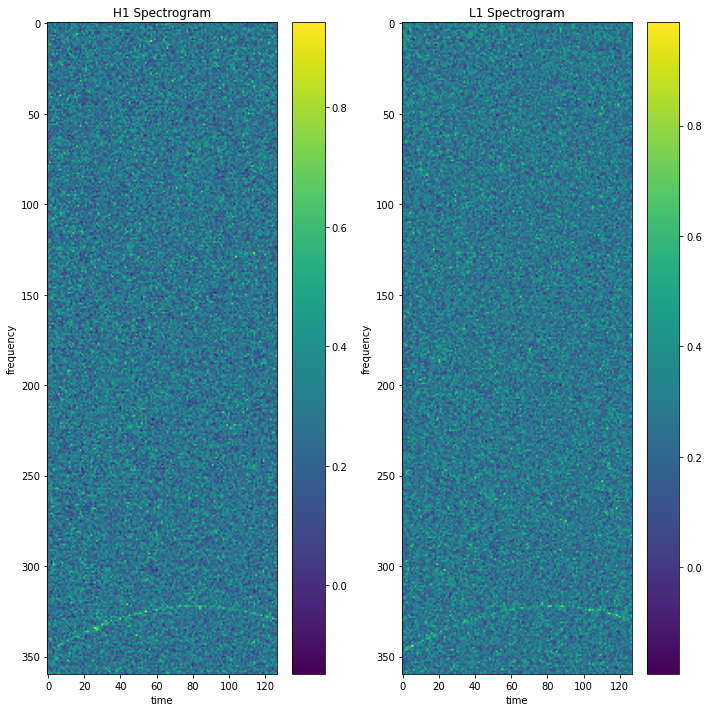

[[[0.35923395 0.16494519 0.3396818  ... 0.30138347 0.1480306  0.42133248]
  [0.2723246  0.4167948  0.23059684 ... 0.2624132  0.26759169 0.19894205]
  [0.13896023 0.26369095 0.27681237 ... 0.32699382 0.26912165 0.22116971]
  ...
  [0.30173063 0.29397824 0.02045513 ... 0.07005751 0.16837294 0.30604655]
  [0.3398951  0.43786708 0.14893036 ... 0.39155275 0.32384983 0.07601997]
  [0.49349102 0.49309567 0.46702778 ... 0.28307292 0.40099284 0.32957628]]

 [[0.16899349 0.24569164 0.16885151 ... 0.28770074 0.2479221  0.25175238]
  [0.5225476  0.26257387 0.44855195 ... 0.51742077 0.32844782 0.3056749 ]
  [0.248843   0.26572737 0.4841211  ... 0.20778808 0.39273816 0.3194553 ]
  ...
  [0.23902632 0.22440583 0.09281849 ... 0.18486057 0.24495171 0.21289334]
  [0.11933485 0.36507893 0.59807014 ... 0.36989203 0.14840494 0.42154133]
  [0.17320116 0.34777594 0.24057075 ... 0.22388509 0.3967014  0.35897624]]]

/kqi/output/g2net-detecting-continuous-gravitational-waves/test/0040fc1b3.hdf5
img.max(), img.m

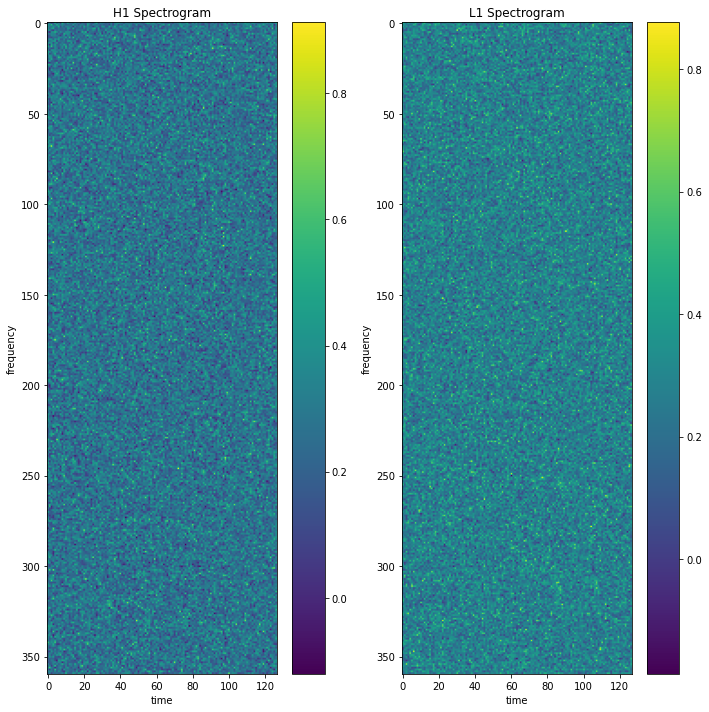

[[[ 0.10031927  0.34653923  0.05797035 ...  0.24639486  0.3004503
    0.48978677]
  [ 0.46272224  0.3189157   0.5975583  ...  0.47961155  0.00925293
    0.26506075]
  [ 0.34736666  0.32387596  0.28396738 ...  0.36388618  0.13771972
    0.31420085]
  ...
  [ 0.22387968  0.05598303  0.28734317 ...  0.21883951 -0.00421278
    0.4225586 ]
  [ 0.35044953  0.34771794  0.3119259  ...  0.49213597  0.35062933
    0.26891547]
  [ 0.18639314  0.32541233  0.08284026 ...  0.3504476   0.10769043
    0.196639  ]]

 [[ 0.48921964  0.3484183   0.1880555  ...  0.22852376  0.16928983
    0.14897732]
  [ 0.29684693  0.35876587  0.25307304 ...  0.41285264  0.33382162
    0.19842122]
  [ 0.48947528  0.23474243  0.3965409  ...  0.42767197  0.07728136
    0.2005561 ]
  ...
  [ 0.3057431   0.29761082  0.29824105 ...  0.34280598  0.40380317
    0.17153862]
  [ 0.16857204  0.2934471   0.3998578  ...  0.05565864  0.29211968
    0.26343316]
  [ 0.15827507  0.22601236  0.34413767 ...  0.3606201   0.3920356
    0.23

In [21]:
print("=> train label dist")
print(train_df.target.value_counts())
print()

print("=> train+test SFTs w")
_df = pd.concat([train_df, test_df])
print("H1 SFTs w max(), min()", _df["H1 SFTs w"].max(), _df["H1 SFTs w"].min())
print("L1 SFTs w max(), min()", _df["L1 SFTs w"].max(), _df["L1 SFTs w"].min())
print()

#normalize_type = "default-norm|p-norm|ts-a"
#normalize_type = "default-norm|p-norm|ts-ma"
#normalize_type = "spec-sequence_a|ts-ma|p-norm"
#normalize_type = "spec-sequence_a|ts-ma|p-stand"
#normalize_type = "spec-sequence_a|ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-norm"
#normalize_type = "ts-ma|p-stand"
#normalize_type = "ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-robustscaler"
#normalize_type = "same_ts_interval|p-stand"
#normalize_type = "same_ts_interval|p-common-stand"
#normalize_type = "largekernel|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#normalize_type = "largekernel"

#cfg_step = 32
#cfg_step = 64
#cfg_step = 128

#cfg_spec_max = 4096
#cfg_spec_max = 4224


# 画像可視化
print("=> normalize_type:", normalize_type)

_i = 10
_path = train_df.iloc[_i]["path"]
#_path = add_df_all.iloc[_i]["path"]
#if "/work" in os.getcwd():
#    _path = sorted(glob.glob(f"{ADD_DIR_TRAIN}/*.hdf5"))[-1]
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360,
                 )
print("img.max(), img.min():", img.max(), img.min())
print("img.shape:", img.shape)
print("y:", train_df.iloc[_i]["target"])
show_1img_2ch(img)
print(img)

print()
_path = test_df.iloc[_i]["path"]
#_path = test_df.iloc[806]["path"]
#if "/kqi/output" in os.getcwd():
#    _path = "/kqi/output/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#else:
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7921a1a90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/308417080.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7ee0a00f8.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/9f37c3fde.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0bf7da48d.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/b0990161d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d1da4fc07.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/4ca95032a.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/5e2305d9d.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/a666b93a9.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d6828b59a.hdf5"
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360)
print("img.max(), img.min():", img.max(), img.min())
print("img.shape:", img.shape)
print("y:", test_df.iloc[806]["target"])
show_1img_2ch(img)
print(img)

In [22]:
#%debug

In [23]:
#=====

# To npy

In [24]:
#!rm -r {NPY_DIR}/{normalize_type}

In [25]:
import multiprocessing
from concurrent.futures import ThreadPoolExecutor

def hdf5_to_npy(h_paths, out_dir):
    """
    前処理したhdf5データをnpyに保存する
    """
    if cfg_is_npy and (os.path.exists(out_dir) == False): 
        os.makedirs(out_dir, exist_ok=True)
        for _path in tqdm(h_paths):
            img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                              norm_type=normalize_type, 
                              ch=cfg_ch, 
                              freq=360,
                             )
            np.save(os.path.join(out_dir, f'{Path(_path).stem}.npy'), np.array(img))
    else:
        print(f"INFO: Exist {out_dir}")


if cfg_is_npy:
    _npy_dir = f"{NPY_DIR}/{normalize_type}"
    _max_workers = multiprocessing.cpu_count()  # total CPU
    with ThreadPoolExecutor(max_workers=_max_workers, thread_name_prefix="thread") as executor:
        hdf5_to_npy(train_df["path"].to_numpy(), f"{_npy_dir}/train")
        if IS_MAKE_SUB or (PSEUDO_CSV != ""):
            hdf5_to_npy(test_df["path"].to_numpy(), f"{_npy_dir}/test")
        if ADD_DIRS_STR != "":
            for _add_dir in eval(ADD_DIRS_STR):
                hdf5_to_npy(sorted(glob.glob(f"{_add_dir}/*.hdf5")), f"{_npy_dir}/{Path(_add_dir).stem}")
        if ADD_PSEUDO_DIRS != "":
            for _add_dir in eval(ADD_PSEUDO_DIRS):
                hdf5_to_npy(sorted(glob.glob(f"{_add_dir}/*.hdf5")), f"{_npy_dir}/{Path(_add_dir).stem}")
        
    # path書き換え
    train_df["path"] = f"{_npy_dir}/train/" + train_df["id"] + ".npy"
    print(train_df["path"].iloc[0])  # パス確認
    if IS_MAKE_SUB:
        test_df["path"] = f"{_npy_dir}/test/" + test_df["id"] + ".npy"
        print(test_df["path"].iloc[0])  # パス確認
    if ADD_DIRS_STR != "":
        add_df_all["path"] = [
            f"{_npy_dir}/{Path(p).parent.stem}/{Path(p).stem}.npy"
            for p in add_df_all["path"].to_numpy()
        ]
        add_df_all.to_csv(f"{OUTPUT_DIR}/add_data.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(add_df_all["path"].iloc[0])  # パス確認
    if PSEUDO_CSV != "":
        pseudo_df["path"] = f"{_npy_dir}/test/" + pseudo_df["id"] + ".npy"
        pseudo_df.to_csv(f"{OUTPUT_DIR}/pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(pseudo_df["path"].iloc[0])  # パス確認
    if ADD_PSEUDO_DIRS != "":
        add_pseudo_df["path"] = [
            f"{_npy_dir}/{Path(p).parent.stem}/{Path(p).stem}.npy"
            for p in add_pseudo_df["path"].to_numpy()
        ]
        add_pseudo_df.to_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(add_pseudo_df["path"].iloc[0])  # パス確認

INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/train
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/test
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex003_generating_noise_2_gap
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_1
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_iso
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_iso_1
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex006_generating_noise_gap1400
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex006_generating_signal_gap800
INFO: Exist /workspace/g2ne

In [26]:
#=====

# Libraries

In [27]:
import warnings
warnings.filterwarnings("ignore")  

import os
import gc
import cv2
import math
import copy
import time
import random
import shutil
import yaml
import glob
from pprint import pprint
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter, OrderedDict
import traceback
import imagesize

# For data manipulation
import numpy as np
import pandas as pd
import seaborn as sns
#import plotly.express as px
from PIL import Image
from matplotlib import pyplot as plt

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import torchaudio

# Utils
import pickle, joblib
from tqdm import tqdm
tqdm.pandas()

# Sklearn Imports
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold

# For Image Models
import timm
print("timm:", timm.__version__)
from timm.data import ImageDataset
from timm.data.mixup import Mixup, one_hot
from timm.data.auto_augment import rand_augment_transform
from timm.loss.cross_entropy import SoftTargetCrossEntropy, LabelSmoothingCrossEntropy
from timm.scheduler import CosineLRScheduler  # warmupつきCosineAnnealingLR

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# tta
import ttach as tta

# DDP
# 何故か3090ではエラーになる
#from accelerate import Accelerator, DistributedType, DistributedDataParallelKwargs

## Synchronized-BatchNorm for DP
## https://blog.shikoan.com/sync-batch-norm-pytorch/
#import sys
#sys.path.append('./Synchronized-BatchNorm-PyTorch')
#from sync_batchnorm import convert_model, DataParallelWithCallback 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

TORCH_VERSION = '.'.join(torch.__version__.split('.')[:3])
print('torch:', TORCH_VERSION)

timm: 0.6.12
device: cuda
torch: 1.13.1+cu117


In [28]:
%reload_ext autoreload
%autoreload 2
from src.sam import SAM, ASAM
from src.cv_split import cv_split, cv_split_kfold

In [29]:
## timmのモデル一覧
## https://github.com/rwightman/pytorch-image-models/blob/master/results/README.md
##!pip install "git+https://github.com/rwightman/pytorch-image-models.git"
#import timm
#from pprint import pprint
#model_names = timm.list_models(pretrained=True)
#pprint(model_names)

In [30]:
#def test_timm_lr_Scheduler():
#    """
#    timmのlr_Schedulerの動作確認
#    https://timm.fast.ai/SGDR#cycle_limit=2
#    """
#    from timm import create_model 
#    from timm.optim import create_optimizer
#    from types import SimpleNamespace
#    from matplotlib import pyplot as plt
#
#    def get_lr_per_epoch(scheduler, num_epoch):
#        lr_per_epoch = []
#        for epoch in range(num_epoch):
#            lr_per_epoch.append(scheduler.get_epoch_values(epoch))
#        return lr_per_epoch
#
#    model = create_model('resnet34')
#
#    num_epoch = 50
#    
#    args = SimpleNamespace()
#    args.weight_decay = 0
#    args.lr = 1e-2
#    args.opt = 'adam' 
#    args.momentum = 0.9
#
#    optimizer = create_optimizer(args, model)
#
#    scheduler = CosineLRScheduler(optimizer, 
#                                  t_initial=num_epoch//3,  # 総エポック数
#                                  lr_min=args.lr*1e-2,  # 最小学習率
#                                  warmup_t=3,  # ウォームアップ完了時のエポック数
#                                  warmup_lr_init=args.lr*1e-2,  # ウォームアップの初期学習率
#                                  warmup_prefix=True,  # Warmupが完了したタイミングの学習率をオプティマイザーで設定した基本学習率にするかどうか
#                                  cycle_limit=1,  # lr restartの回数
#                                 )
#    lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)
#
#    plt.plot([i for i in range(num_epoch)], lr_per_epoch);
#    
#test_timm_lr_Scheduler()

# CFG

In [31]:
import os, yaml, shutil

class Config:
    def __init__(self):
        self.name=NAME
        self.train=True
        self.debug=DEBUG
        self.print_freq=1000
        self.is_save_per_steps=False
        self.target_col="target"
        self.num_classes=1
        self.loss = "nn.BCEWithLogitsLoss"
        
        self.model_cls=model_cls
        self.apex=cfg_apex
        self.load_model_path=load_model_path
        #self.load_model_path=f"{OUTPUT_DIR}/tmp_fold0_seed0_best_score.pth"
        #self.is_load_opt=True
        self.is_load_opt=False
        
        # ============== model params ==============
        self.model_name=MODEL_NAME
        self.size_h=size_h
        self.size_w=size_w
        self.batch_size=BATCH_SIZE
        self.gradient_accumulation_steps=gradient_accumulation_steps
        self.is_syncBN = is_syncBN
        self.pretrained = cfg_pretrained
        self.drop_rate = cfg_drop_rate
        self.drop_path_rate = cfg_drop_path_rate
        # ==========================================
        
        self.num_workers=8#16 if "/work" in os.getcwd() else 8
        self.epochs=epochs
        self.optimizer=cfg_optimizer
        self.lr=lr
        self.warmup_lr_init=self.lr*min_lr_ratio
        self.min_lr=self.lr*min_lr_ratio
        self.weight_decay=weight_decay
        self.scheduler=cfg_scheduler  # 'CosineLRScheduler'  # warmup
        self.warmup_t=warmup_t
        self.T_max=epochs
        self.max_grad_norm=1000
        
        self.cv_col=cfg_cv_col
        self.seeds=cfg_seeds
        self.n_fold=n_fold
        self.trn_fold=trn_fold
        
        self.is_wandb=is_wandb
        self.device_ids=device_ids
        
        # ============== data params ==============
        self.step=cfg_step
        self.spec_max=cfg_spec_max
        self.ch=cfg_ch
        self.freq=360
        self.norm_type=normalize_type
        # ==========================================
        
        # 自作mixup
        self.prob_mixup = cfg_prob_mixup  # 0.0なら発生確率=0
        self.mix_alpha = 1.0
        self.is_mix_or = True
        #self.mixup_off_epoch = self.epochs-5  # 最後の5epochはmixup/cutmixなしにする
        self.mixup_off_epoch = 0  # 常にmixup/cutmixなし
        
        # label=0ならlabel=0or1とmix, label=1ならlabel=0とmixする確率
        self.prob_sample_mixup = cfg_prob_sample_mixup
        # sample_mixupのデータはpseudoデータだけにするか
        self.is_sample_mixup_use_pseudo = cfg_is_sample_mixup_use_pseudo
        
        # 追加データのtarget=0とオリジナルのtarget=0とのmixup確率
        self.prob_add_sample_nega_mixup = cfg_prob_add_sample_nega_mixup
        
        # データセットの移動平均のpowerとのmixupの確率
        self.prob_mean_mixup = cfg_prob_mean_mixup
        
        # ch追加するか
        self.is_add_ch = cfg_is_add_ch
        
        # スペクトログラムの開始点をランダムに変えるか
        self.prob_spec_start_random = cfg_prob_spec_start_random
        
        # test setのような縦線や横線のノイズ入れる確率
        self.prob_noise_band = cfg_prob_noise_band
        
        # test setのような外れ点ノイズ入れる確率
        self.prob_noise_spot = cfg_prob_noise_spot
        
        # test setのようなまばらな外れ縦線ノイズ入れる確率
        self.prob_noise_vline = cfg_prob_noise_vline
        
        # test setのようなまばらな外れ横バンドノイズ入れる確率
        self.prob_noise_hband = cfg_prob_noise_hband
        
        # target=0のデータのチャネル入れ替える確率
        self.prob_swap_ch_nega = cfg_prob_swap_ch_nega
        
        # target=0のデータhflipする確率
        self.prob_flip_nega = cfg_prob_flip_nega
        
        # target=0のデータ同士をシャッフルする確率
        self.prob_swap_nega = cfg_prob_swap_nega
        
        # target=0のデータをVshiftする確率
        self.prob_vshift_nega = cfg_prob_vshift_nega
        
        # データ関係なくVshiftする確率
        self.prob_vshift = cfg_prob_vshift
        
        # torchaudioで縦横cutout(マスク)する本数
        self.time_mask_num = cfg_time_mask_num  # 縦線
        self.freq_mask_num = cfg_freq_mask_num  # 横線
        self.time_mask_param = cfg_time_mask_param  # マスクの可能な最大長。[0, time_mask_param) 
        self.freq_mask_param = cfg_freq_mask_param  # マスクの可能な最大長。[0, freq_mask_param) 
        
        # zip_datasetをtrainにして学習するか
        self.is_train_zip_dataset = cfg_is_train_zip_dataset
        
        # 生成したデータは別の切り方でfold分けるときに使うKfoldのAPI名(StratifiedKFold, KFoldなど)。""なら別の切り方でfold分けない
        self.add_split_str = cfg_add_split_str
        
        # データをnpyに変換するか
        self.is_npy = cfg_is_npy
        
        # 学習に追加した生成データのディレクトリ名
        self.add_dirs_str = ADD_DIRS_STR
        
        # 学習に追加したtestの疑似ラベルに使うcsv、確信度の閾値、ハードラベルにするか
        self.pseudo_csv = PSEUDO_CSV
        self.pseudo_ths = [cfg_pseudo_max, cfg_pseudo_min]
        self.is_pseudo_hard = cfg_is_pseudo_hard
        
        # 学習に追加したtestの疑似ラベルをリアルデータ/シュミレーションデータだけにするか
        self.pseudo_type = cfg_pseudo_type
        
        # 追加の疑似ラベルのディレクトリ名
        self.add_pseudo_dirs = ADD_PSEUDO_DIRS
        
        # MultiOutputに使う列の要素。freq_min//cfg_freq_div_n の freq_min//N 列をつくる
        self.freq_div_n = cfg_freq_div_n
        

CFG = Config()
        
if CFG.debug:
    #CFG.seeds=[0,1,2]
    CFG.is_wandb=False
    #CFG.is_wandb=True
    CFG.print_freq=10
    CFG.epochs=1
    #CFG.epochs=5
    #CFG.warmup_t=1
    #CFG.mixup_off_epoch=3
    #CFG.epochs=1
    #CFG.mixup_off_epoch=1
    #CFG.epochs=10
    #CFG.trn_fold=[0]
    #CFG.trn_fold=[0,1,2,3,4]
    train_df = cv_split(train_df, 0, 10, cv_col="target")
    train_df = train_df[train_df["fold"] == 0].reset_index(drop=True)
    print("debug train_df.shape:", train_df.shape)
    test_df = test_df.iloc[:30]
    print("debug test_df.shape:", test_df.shape)
    # モデル削除
    !rm -f {OUTPUT_DIR}/*pth
    
with open(OUTPUT_DIR + "/cfg.yaml", "w") as wf:
    yaml.dump(CFG.__dict__, wf)
        
if len(CFG.device_ids) > 1:
    os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(_) for _ in CFG.device_ids])
    print("os.environ['CUDA_VISIBLE_DEVICES']:", os.environ["CUDA_VISIBLE_DEVICES"])
    CFG.batch_size = CFG.batch_size*len(CFG.device_ids)
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(CFG.device_ids[0])
    print("os.environ['CUDA_VISIBLE_DEVICES']:", os.environ["CUDA_VISIBLE_DEVICES"])
    # For descriptive error messages
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    
pprint(CFG.__dict__)

os.environ['CUDA_VISIBLE_DEVICES']: 0
{'T_max': 50,
 'add_dirs_str': '[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, '
                 'EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, '
                 'EX006_SIGNAL800, EX006_SIGNAL_ISO800]',
 'add_pseudo_dirs': '[EX007_NONSTAT_NOISE800]',
 'add_split_str': 'StratifiedKFold',
 'apex': True,
 'batch_size': 64,
 'ch': 2,
 'cv_col': 'target',
 'debug': False,
 'device_ids': [0],
 'drop_path_rate': 0.2,
 'drop_rate': 0.4,
 'epochs': 50,
 'freq': 360,
 'freq_div_n': 50,
 'freq_mask_num': 2,
 'freq_mask_param': 10,
 'gradient_accumulation_steps': 1,
 'is_add_ch': False,
 'is_load_opt': False,
 'is_mix_or': True,
 'is_npy': True,
 'is_pseudo_hard': False,
 'is_sample_mixup_use_pseudo': True,
 'is_save_per_steps': False,
 'is_syncBN': False,
 'is_train_zip_dataset': False,
 'is_wandb': True,
 'load_model_path': 'none',
 'loss': 'nn.BCEWithLogitsLoss',
 'lr': 0.0004,
 'max_grad_norm': 1000,
 'min_lr': 4.000000000000001e-06,
 'mix_alpha': 1

# Utils

In [32]:
def init_logger(log_file=OUTPUT_DIR + '/train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print('> SEEDING DONE')

# Wandb

In [33]:
if CFG.is_wandb:
    import wandb
    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        api_key = user_secrets.get_secret("WANDB")
        wandb.login(key=api_key)
        anonymous = None
    except:
        wandb.login(key="ace10b29622f5bd54e16d665a4b7c485e2094353")  # 自分の api key でログイン  # https://wandb.ai/settings
        wandb.init(project="kaggle_g2net2", entity='anonamename', name=NAME)
        wandb.config.update(CFG.__dict__)  # ハイパラ登録

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anonamename. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Dataset

In [34]:
class TrainDataset(Dataset):
    def __init__(self, train, transforms=None, 
                 is_npy=True,
                 is_add_ch=False,
                 prob_spec_start_random=0.0,
                 prob_sample_mixup=0.0,
                 is_sample_mixup_use_pseudo=CFG.is_sample_mixup_use_pseudo,
                 prob_add_sample_nega_mixup=0.0,
                 prob_mean_mixup=0.0, 
                 prob_noise_band=0.0,
                 prob_noise_spot=0.0,
                 prob_noise_vline=0.0,
                 prob_noise_hband=0.0,
                 prob_swap_ch_nega=0.0,
                 prob_flip_nega=0.0,
                 prob_swap_nega=0.0,
                 prob_vshift_nega=0.0,
                 prob_vshift=0.0,
                 time_mask_num=0,
                 freq_mask_num=0,
                 time_mask_param=CFG.time_mask_param,
                 freq_mask_param=CFG.freq_mask_param,
                ):
        self.train = train
        self.file_names = train['path'].values
        self.labels = train['target'].values
        self.transforms = transforms
        
        self.labels_freq = train['freq_min//N'].values - (40 // CFG.freq_div_n)  # for MultiOutput
        
        self.orig_flags = train['orig'].values  # np.nanは追加データ
        
        self.is_npy = is_npy  # npyをロードするか
        
        self.prob_spec_start_random = prob_spec_start_random  # スペクトログラムの開始点をランダムに変える確率
        
        self.is_add_ch = is_add_ch  # ch増やすか
        
        #self.train0 = train[train["target"] == 0]   # label=0のdf
        if is_sample_mixup_use_pseudo:
            #self.train0 = train[train["target"] < 0.5]   # label=0のdf pseudoのデータもmix
            self.train0 = pseudo_df[pseudo_df["target"] < 0.5]   # label=0のdf pseudoのデータだけでmix
            if ADD_PSEUDO_DIRS != "":
                self.train0 = pd.concat([self.train0, add_pseudo_df], ignore_index=True)
        else:
            self.train0 = train[train["target"] < 0.5]   # label=0のdf pseudoのデータもmix
        
        self.train0_orig = train[train["target"] < 0.5].dropna(subset=['freq min']).reset_index(drop=True)  # label=0かつオリジナルデータのdf
        
        self.prob_sample_mixup = prob_sample_mixup  # label=0ならlabel=0or1とmix, label=1ならlabel=0とmixする確率
        
        self.prob_add_sample_nega_mixup = prob_add_sample_nega_mixup  # 追加データのtarget=0とオリジナルのtarget=0とをmixup確率
        
        self.prob_mean_mixup = prob_mean_mixup  # データセットの移動平均のpowerとのmixup
        
        self.prob_noise_band = prob_noise_band  # test setのような縦線や横線のノイズ入れる確率
        
        self.prob_noise_spot = prob_noise_spot  # test setのような外れ点ノイズ入れる確率
        
        self.prob_noise_vline = prob_noise_vline  # test setのようなまばらな外れ縦線ノイズ入れる確率
        
        self.prob_noise_hband = prob_noise_hband  # test setのようなまばらな外れ横バンドノイズ入れる確率
        
        self.prob_swap_ch_nega = prob_swap_ch_nega # negaサンプルch入れ替える確率
        
        self.prob_flip_nega = prob_flip_nega  # negaサンプルhflipする確率
        
        self.prob_swap_nega = prob_swap_nega  # negaサンプル別の使う確率
        
        self.prob_vshift_nega = prob_vshift_nega  # negaサンプルのみ縦方向に平行移動(VShift)する確率
        
        self.prob_vshift = prob_vshift  # 縦方向に平行移動(VShift)する確率
        
        self.time_mask_num = time_mask_num # number of time masking
        self.freq_mask_num = freq_mask_num # number of frequency masking
        self.transforms_time_mask = nn.Sequential(
            # time_mask_param はマスクする幅の最大長。[0, time_mask_param) 
            torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param),
        )
        self.transforms_freq_mask = nn.Sequential(
            # freq_mask_param はマスクする幅の最大長。[0, freq_mask_param) 
            torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param),
        )    
        
    def __len__(self):
        return len(self.train)
    
    def load_img(self, path):
        if self.is_npy:
            img = np.load(path)
        else:
            img = hdf5_to_img(path, CFG.step, CFG.spec_max, 
                              norm_type=CFG.norm_type, 
                              ch=CFG.ch, 
                              freq=CFG.freq)  # (C,H,W)
        img = img.transpose(1, 2, 0)  # (H,W,C)
    
        ### 振幅の開始点をランダムに変更
        if (np.random.rand() > 1 - self.prob_spec_start_random) and (img.shape[1] > CFG.size_w):
            spec_start = img.shape[1] - CFG.size_w
            spec_start = int(np.random.uniform(low=0, high=spec_start))
            img = img[:, spec_start:spec_start+CFG.size_w, :]  # shape=(360, size_w, 2)
            #print("spec_start:", spec_start)
        
        ### 横幅のサイズはsize_wまでにする
        if CFG.size_w > 0:
            img = img[:, :CFG.size_w, :]  # shape=(360, size_w, 2)
        
        #print("img.shape:", img.shape)
        return img
    
    def __getitem__(self, index):
        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.float)
        img = self.load_img(self.file_names[index])
        
        orig_flag = self.orig_flags[index]
        
        # ===============================================
        # for MultiOutput
        # ===============================================
        label_freq = self.labels_freq[index]
        label_freq = torch.tensor(label_freq, dtype=torch.long)
        label_freq = one_hot(label_freq, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, device='cpu')
        
        # ===============================================
        # test setのような縦線や横線のノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_band:
            # H1の横線
            w_n_line = np.random.randint(1, 3)  # 横線何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 5)  # 横線の太さ
                _ratio = np.random.uniform(0.05, 1.1)
                img[_s:_s+_b, :, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
            #print(f"{index} H1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # L1の横線
            w_n_line = np.random.randint(1, 3)  # 横線何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 5)  # 横線の太さ
                _ratio = np.random.uniform(0.05, 1.1)
                img[_s:_s+_b, :, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
            #print(f"{index} L1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # H1の縦線
            v_n_line = np.random.randint(1, 6)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 15)  # 縦線の太さ
                _ratio = np.random.uniform(0.05, 0.4)
                img[:, _s:_s+_b, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
            #print(f"{index} H1 v_noise_band {v_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # L1の縦線
            v_n_line = np.random.randint(1, 6)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 15)  # 縦線の太さ
                _ratio = np.random.uniform(0.05, 0.4)
                img[:, _s:_s+_b, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
            #print(f"{index} L1 v_noise_band {v_n_line}")
            
        # ===============================================
        # test setのような外れ点ノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_spot:
            # H1の外れ点
            n_area = np.random.randint(1, 3)  # 外れ領域何個入れるか
            for _ in range(n_area):
                _y = np.random.randint(0, img.shape[0])  # y軸の開始位置
                _x = np.random.randint(0, img.shape[1])  # x軸の開始位置
                _xb = np.random.randint(1, 5)  # 外れ領域の大きさ
                _yb = np.random.randint(1, 20)  # 外れ領域の大きさ
                _ratio = np.random.uniform(1.5, 2)
                img[_y:_y+_yb, _x:_x+_xb, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
                #img[_y:_y+_yb, _x:_x+_xb, 0] *= _ratio  # 係数掛ける
            #print(f"{index} H1 noise_spot {n_area}")
        if np.random.rand() > 1 - self.prob_noise_spot:
            # L1の外れ点
            n_area = np.random.randint(1, 3)  # 外れ領域何個入れるか
            for _ in range(n_area):
                _y = np.random.randint(0, img.shape[0])  # y軸の開始位置
                _x = np.random.randint(0, img.shape[1])  # x軸の開始位置
                _xb = np.random.randint(1, 5)  # 外れ領域の大きさ
                _yb = np.random.randint(1, 20)  # 外れ領域の大きさ
                _ratio = np.random.uniform(1.5, 2)
                img[_y:_y+_yb, _x:_x+_xb, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
                #img[_y:_y+_yb, _x:_x+_xb, 1] *= _ratio  # 係数掛ける
            #print(f"{index} L1 noise_spot {n_area}")
            
        # ===============================================
        # test setのようなまばらな外れ縦線ノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_vline:
            # H1の外れ縦線
            v_n_line = np.random.randint(1,8)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 2)  # 縦線の太さ
                _ratio = np.random.uniform(3, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[:, _s:_s+_b, 0].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 上半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[0]//2)
                    _gs_n[:_mask,:] = 0
                # 下半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[0]//2, _gs_n.shape[0])
                    _gs_n[_mask:,:] = 0
                img[:, _s:_s+_b, 0] += _gs_n
            #print(f"{index} H1 noise_vline {v_n_line}")
        if np.random.rand() > 1 - self.prob_noise_vline:
            # L1の外れ縦線
            v_n_line = np.random.randint(1, 5)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 2)  # 縦線の太さ
                _ratio = np.random.uniform(3, 5)
                _mu = img[:,:,1].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[:, _s:_s+_b, 1].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 上半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[0]//2)
                    _gs_n[:_mask,:] = 0
                # 下半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[0]//2, _gs_n.shape[0])
                    _gs_n[_mask:,:] = 0
                img[:, _s:_s+_b, 1] += _gs_n
            #print(f"{index} L1 noise_vline {v_n_line}")
            
        # ===============================================
        # test setのようなまばらな外れ横バンドノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_hband:
            # H1の外れ横バンド
            w_n_line = np.random.randint(1, 3)  # バンド何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 10)  # 横線の太さ
                _ratio = np.random.uniform(2, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[_s:_s+_b, :, 0].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 右半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[1]//2)
                    _gs_n[:,:_mask] = 0
                # 左半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[1]//2, _gs_n.shape[1])
                    _gs_n[:,_mask:] = 0
                # ゼブラマスク
                if np.random.rand() > 0.5:
                    _gs_n[::2,:] = 0  # 1飛ばし。例: array([0, 2, 4, 6, 8])
                if np.random.rand() > 0.5:
                    _gs_n[::3,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::5,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::7,:] = 0
                img[_s:_s+_b, :, 0] += _gs_n
            #print(f"{index} H1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_hband:
            # L1の外れ横バンド
            w_n_line = np.random.randint(1, 3)  # バンド何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 10)  # 横線の太さ
                _ratio = np.random.uniform(2, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[_s:_s+_b, :, 1].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 右半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[1]//2)
                    _gs_n[:,:_mask] = 0
                # 左半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[1]//2, _gs_n.shape[1])
                    _gs_n[:,_mask:] = 0
                # ゼブラマスク
                if np.random.rand() > 0.5:
                    _gs_n[::2,:] = 0  # 1飛ばし。例: array([0, 2, 4, 6, 8])
                if np.random.rand() > 0.5:
                    _gs_n[::3,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::5,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::7,:] = 0
                img[_s:_s+_b, :, 1] += _gs_n
            #print(f"{index} L1 h_noise_band {w_n_line}")
            
        # ソフトラベルの対策。negativeとみなすラベルの値
        nega_th = 0.5
        
        # ===============================================
        # VShift
        # ===============================================
        # https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation
        if (np.random.rand() > 1 - self.prob_vshift):
            img = np.roll(img, np.random.randint(low=0, high=img.shape[0]), axis=0)
            #print("vshift")
        ### Negative VShift
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_vshift_nega):
            img = np.roll(img, np.random.randint(low=0, high=img.shape[0]), axis=0)
            #print("vshift_nega")
        
        # ===============================================
        # Negative Swap CH
        # ===============================================
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_swap_ch_nega):
            i0 = img[:,:,0].copy()
            img[:,:,0] = img[:,:,1]
            img[:,:,1] = i0
            #print("swap_ch_nega")
        
        # ===============================================
        # 前回コンペ8位のaug
        # https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/discussion/275335
        # ===============================================
        # LIGO Swap は A.ChannelShuffle で実行
        
        # Negative Flip
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_flip_nega):
            img = img[:, ::-1, :].copy()  # hflip
            #print("hflip_nega")
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_flip_nega):
            img = img[::-1, :, :].copy()  # vflip
            #print("vflip_nega")
        
        # Swap with Other Negative
        if (label < nega_th) and (self.prob_swap_nega > 0.0):
            sample = self.train0.sample()
            sample_img = self.load_img(sample.iloc[0]['path'])
            if np.random.uniform() > 1 - self.prob_swap_nega:
                img[:,:,0] = sample_img[:,:,0]
                #print("h1 swap_nega")
            if np.random.uniform() > 1 - self.prob_swap_nega:
                img[:,:,1] = sample_img[:,:,1]
                #print("l1 swap_nega")
            
        # ===============================================
        # Sample Mixup
        # ===============================================
        # label=0ならlabel=0or1とmix, label=1ならlabel=0とmix
        if np.random.rand() > 1 - self.prob_sample_mixup:
            if label < nega_th:
                sample = self.train.sample()
            else:
                sample = self.train0.sample()
            sample_img = self.load_img(sample.iloc[0]['path'])
            img = (img + sample_img) / 2.0
            # mix_sample_lam の割合で混ぜる
            #mix_sample_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
            #img = mix_sample_lam*img + (1-mix_sample_lam)*sample_img
            
            if sample.iloc[0]['target'] >= nega_th:
                label = torch.tensor(sample.iloc[0]['target']).float()
            
            # for MultiOutput
            sample_label_freq = sample.iloc[0]['freq_min//N'] - (40 // CFG.freq_div_n)
            sample_label_freq = torch.tensor(sample_label_freq, dtype=torch.long)
            sample_label_freq = one_hot(sample_label_freq, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, device='cpu')
            label_freq = (label_freq + sample_label_freq) / 2.0
            
            #print("sample_mixup", sample.iloc[0]['target'])
            
        # ===============================================
        # Add Data Nega Sample Mixup
        # ===============================================
        # target=0について add_data と orig_data をmixup
        if np.random.rand() > 1 - self.prob_add_sample_nega_mixup:
            if np.isnan(orig_flag):
                # orig_flagがnegaならadd_data
                if label < nega_th:
                    sample = self.train0_orig.sample()
                sample_img = self.load_img(sample.iloc[0]['path'])
                # mix_sample_lam の割合で混ぜる
                mix_sample_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
                img = mix_sample_lam*img + (1-mix_sample_lam)*sample_img
                #print("add_sample_nega_mixup")
        
        # ===============================================
        # Mean Mixup
        # ===============================================
        # データセット全体の移動平均とmix
        if np.random.rand() > 1 - self.prob_mean_mixup:

            # データセット全体の移動平均の振幅をパワーに変換
            abs_mean_img = np.empty((CFG.ch, CFG.freq, CFG.step), dtype=np.float32)
            if ("ts-ma" in CFG.norm_type) and (cfg_step % 64 == 0):
                # step%64=0の移動平均は1要素減る
                abs_mean_img = np.empty((CFG.ch, CFG.freq, CFG.step-1), dtype=np.float32)
            abs_mean_img[0] = amp2power(a_abs_mean_h1, "H1", CFG.step, CFG.spec_max, CFG.norm_type, CFG.freq)
            abs_mean_img[1] = amp2power(a_abs_mean_l1, "L1", CFG.step, CFG.spec_max, CFG.norm_type, CFG.freq)
            abs_mean_img = abs_mean_img.transpose(1, 2, 0)  # (H,W,C)
            # 横幅のサイズはsize_wまでにする
            if CFG.size_w > 0:
                abs_mean_img = abs_mean_img[:, :CFG.size_w, :]  # shape=(360, size_w, 2)
            
            # mean_lam の割合で混ぜる
            mean_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
            img = mean_lam*img + (1-mean_lam)*abs_mean_img
        
            # 移動平均と混ぜた分のラベルもmix
            if label < nega_th:
                label += 0.1*(1-mean_lam)
            #print("mean_mixup")
            
        # ===============================================
        # ch増やす
        # ===============================================
        if self.is_add_ch:
            img = np.stack([img[:,:,0], img[:,:,1],
                            img[:,:,0] + img[:,:,1], 
                            img[:,:,0] - img[:,:,1]])  # (C,H,W)
            img = img.transpose(1, 2, 0)  # (H,W,C)
              
        if self.transforms:
            img = self.transforms(image=img)["image"]  # (C,H,W)

        # ===============================================
        # Torchaudio Masking
        # ===============================================
        # https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation
        # imgはtorch型の(C,H,W)形式じゃないとだめ
        if np.random.rand() > 1 - 0.5:
            for _ in range(self.time_mask_num): # time masking
                img = self.transforms_time_mask(img)
        if np.random.rand() > 1 - 0.5:
            for _ in range(self.freq_mask_num): # frequency masking
                img = self.transforms_freq_mask(img)
            
        return img, label, label_freq

# Transform

In [35]:
def get_transforms(*, data):
    if data == 'train':
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            #A.ChannelShuffle(always_apply=False, p=0.5),
            #A.GridDropout(ratio=0.5, holes_number_x=4, holes_number_y=8, random_offset=True, p=0.5),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0, scale_limit=(0, 0.2), rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0, border_mode=cv2.BORDER_WRAP),
            ToTensorV2(),
        ])
    elif data == 'valid':
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            ToTensorV2(),
        ])
    #elif data == 'tta1':
    #    return A.Compose([
    #        A.Resize(CFG.size_h, CFG.size_w),
    #        A.ChannelShuffle(always_apply=True, p=1.0),
    #        ToTensorV2(),
    #    ])

In [36]:
def mixup(x, y, alpha):
    """
    Usage:
        x, y = batch["x"], batch["y"]
        x, y_mixs = mixup(x, y.long(), 1.0)
        y_hat = model(x.float())
        loss = criterion(y_hat, y_mixs[0], mix_decision) * y_mixs[2] + criterion(y_hat, y_mixs[1], mix_decision) * (1.0 - y_mixs[2])
    """
    indices = torch.randperm(x.size(0))
    shuffled_x = x[indices]
    shuffled_y = y[indices]

    lam = np.clip(np.random.beta(alpha, alpha),0.3,0.7)
    x = lam*x + (1-lam)*shuffled_x
    ys = (y, shuffled_y, lam)

    return x, ys

# Dataloader check

torch.Size([15, 2, 360, 127]) torch.Size([15]) torch.Size([15, 1, 11])


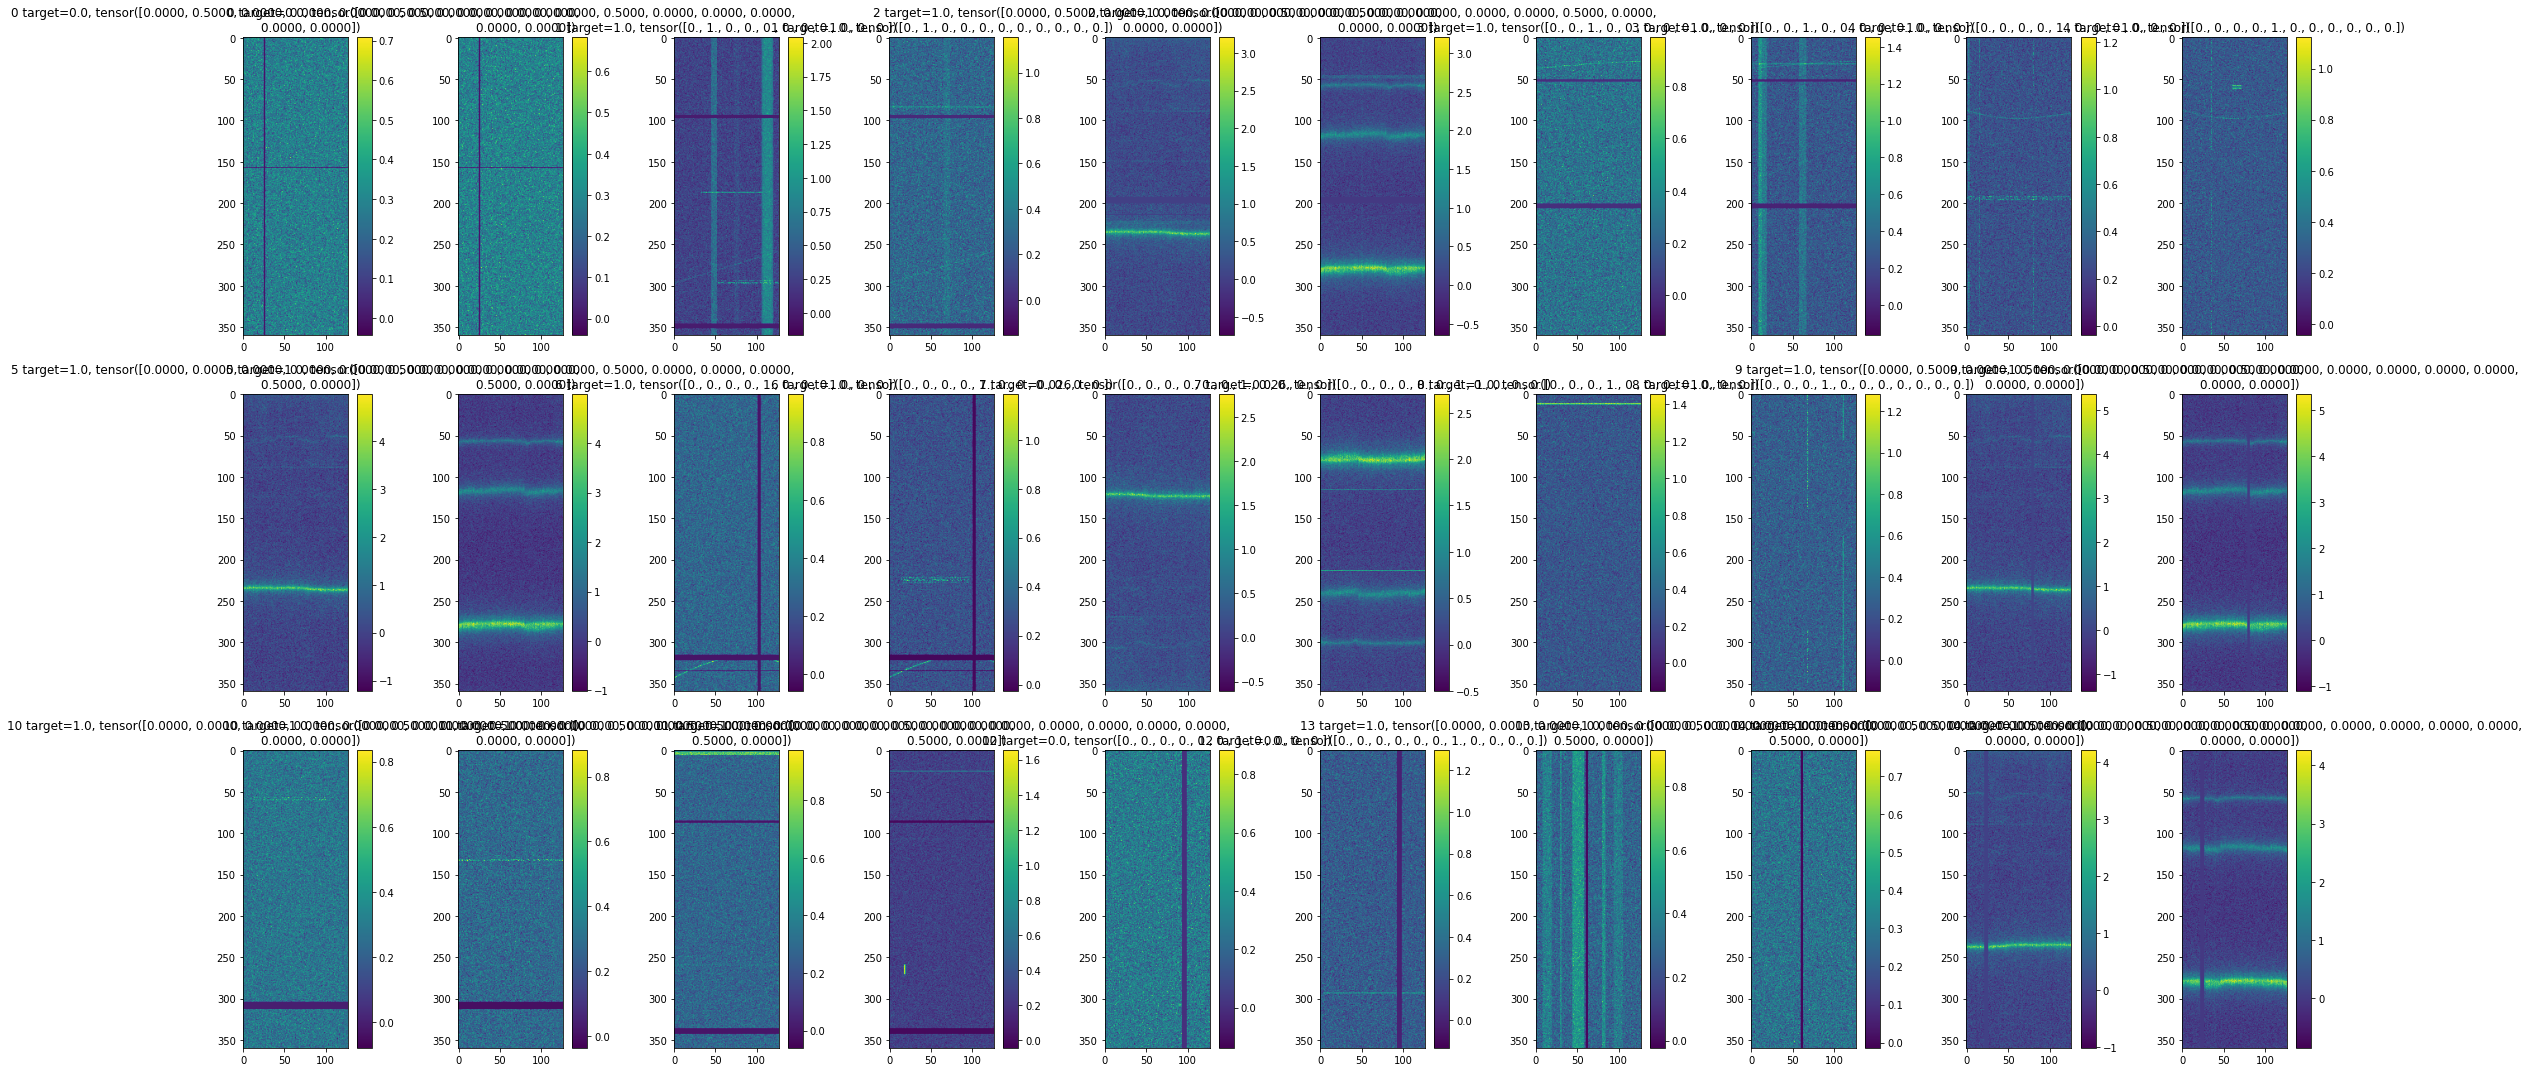

In [37]:
#%%time
# timeでファイルioに時間かかるか確認
if CFG.is_train_zip_dataset:
    train_dataset = ZipDataset(
        path=f"{zip_path}/archive", mod=zip_mod, transforms=get_transforms(data="train")
    )
else:
    train_dataset = TrainDataset(
        train_df,
        #pd.concat([train_df, add_df_all]),
        transforms=get_transforms(data="train"),
        is_npy=CFG.is_npy,
        is_add_ch=CFG.is_add_ch,
        prob_spec_start_random=CFG.prob_spec_start_random,
        prob_sample_mixup=CFG.prob_sample_mixup,
        prob_add_sample_nega_mixup=CFG.prob_add_sample_nega_mixup,
        prob_mean_mixup=CFG.prob_mean_mixup,
        prob_noise_band=CFG.prob_noise_band,
        prob_noise_spot=CFG.prob_noise_spot,
        prob_noise_vline=CFG.prob_noise_vline,
        prob_noise_hband=CFG.prob_noise_hband,
        prob_swap_ch_nega=CFG.prob_swap_ch_nega,
        prob_flip_nega=CFG.prob_flip_nega,
        prob_swap_nega=CFG.prob_swap_nega,
        prob_vshift_nega=CFG.prob_vshift_nega,
        prob_vshift=CFG.prob_vshift,
        time_mask_num=CFG.time_mask_num,
        freq_mask_num=CFG.freq_mask_num,
    )
    #train_dataset = TrainDataset(
    #    #train_df,
    #    pd.concat([train_df, add_df_all]),
    #    transforms=get_transforms(data="train"),
    #    is_npy=CFG.is_npy,
    #    #is_add_ch=True,
    #    #prob_spec_start_random=1.0,
    #    prob_add_sample_nega_mixup=1.0,
    #    prob_sample_mixup=1.0,
    #    prob_mean_mixup=1.0,
    #    prob_noise_band=1.0,
    #    prob_noise_spot=1.0,
    #    prob_noise_vline=1.0,
    #    prob_noise_hband=1.0,
    #    #prob_swap_ch_nega=1.0,
    #    #prob_flip_nega=1.0,
    #    #prob_swap_nega=1.0,
    #    #prob_vshift_nega=1.0,
    #    #prob_vshift=1.0,
    #    #time_mask_num=5,
    #    #freq_mask_num=5,
    #)
train_loader = DataLoader(
    train_dataset,
    batch_size=15,
    shuffle=True,
    num_workers=0, pin_memory=True, drop_last=True,
    #collate_fn=mixup_collate_fn,
)
for step, (images, labels, labels_freq) in enumerate(train_loader):
    print(images.shape, labels.shape, labels_freq.shape)
    
    if normalize_type == "largekernel":
        plt.figure(figsize=(30,25))
    else:
        plt.figure(figsize=(30,15))
    i = 1
    for idx, (im, la, la_f) in enumerate(zip(images, labels, labels_freq)):
        #print(la_f.shape)
        #print(la_f.squeeze().shape)
        im = im.transpose(0, 1).transpose(1, 2)  # (H,W,C)
        
        if normalize_type == "largekernel":
            plt.subplot(5*3, 2, i)
        else:
            plt.subplot(3, 5*2, i)
        plt.imshow(im[:,:,0])
        plt.colorbar()
        #plt.colorbar(orientation='horizontal')
        plt.title(f"{idx} target={round(float(la.numpy()), 3)}, {la_f.squeeze()}", fontsize=12)
        i += 1
        
        if normalize_type == "largekernel":
            plt.subplot(5*3, 2, i)
        else:
            plt.subplot(3, 5*2, i)
        plt.imshow(im[:,:,1])
        plt.colorbar()
        #plt.colorbar(orientation='horizontal')
        plt.title(f"{idx} target={round(float(la.numpy()), 3)}, {la_f.squeeze()}", fontsize=12)
        i += 1
        
        if i > 30:
            break
            
    plt.tight_layout()
    plt.show()
    break

In [38]:
#%debug

In [39]:
#=====

# Model

In [40]:
class CustomModel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=CFG.num_classes, 
                                     in_chans=CFG.ch)        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModel(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [41]:
# https://www.kaggle.com/code/hirune924/2ndplace-solution/notebook を参考にdropout入れて過学習避ける
class CustomModelDrop(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=CFG.num_classes, 
                                     in_chans=CFG.ch, 
                                     drop_rate=CFG.drop_rate,  # headのドロップアウト率 (デフォルト: 0)
                                     drop_path_rate=CFG.drop_path_rate  # 中間層のドロップアウト率 (デフォルト: 0)
                                    )        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModelDrop(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [42]:
class CustomModelMultiOutput(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)   
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)  # 40-500Hz // CFG.freq_div_n
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2

#print(CFG.model_name)
#m = CustomModelMultiOutput(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o1, o2 = m(x.cuda())
#print(o1, o1.shape)
#print(o2, o2.shape)
##m

In [43]:
class CustomModelMultiOutputDrop(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch,
                                     drop_rate=CFG.drop_rate,  # headのドロップアウト率 (デフォルト: 0)
                                     drop_path_rate=CFG.drop_path_rate  # 中間層のドロップアウト率 (デフォルト: 0)
                                    )   
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)  # 40-500Hz // CFG.freq_div_n
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2

#print(CFG.model_name)
#m = CustomModelMultiOutputDrop(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o1, o2 = m(x.cuda())
#print(o1, o1.shape)
#print(o2, o2.shape)
##m

In [44]:
#=====

In [45]:
class CustomModelAddEmb(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)   
        self.head = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features+(500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, CFG.num_classes)  # embを1次元増やす
        )
    def forward(self, x, add_x):
        feat = self.net(x)
        #print(feat.shape, add_x.shape)
        y = self.head( torch.cat((feat, add_x), 1) )
        return y[:,0]

#print(CFG.model_name)
#m = CustomModelAddEmb(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#add_x = torch.rand(CFG.batch_size, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)
#o = m(x.cuda(), add_x.cuda())
#print(o, o.shape)
##m

In [46]:
#=====

In [47]:
class CustomModelMultiInput(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net1 = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                      num_classes=0, 
                                      in_chans=CFG.ch//2) 
        self.net2 = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                      num_classes=0, 
                                      in_chans=CFG.ch//2)
        self.head = nn.Sequential(
            nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net1.num_features + self.net2.num_features, CFG.num_classes)
        )
        
    def forward(self, x, labels=None):
        
        x1 = x[:, :CFG.ch//2, :, :]
        x2 = x[:, CFG.ch//2:, :, :]
        #print(x1.shape, x2.shape)
        
        feat1 = self.net1(x1)
        feat2 = self.net2(x2)
        y = self.head( torch.cat((feat1, feat2), 1) )
        #print(feat1.shape, feat2.shape, y.shape)
        
        return y[:,0]

#print(CFG.model_name)
#m = CustomModelMultiInput(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [48]:
#=====

In [49]:
class CustomModelLargeKernel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        if pretrained:
            pth = "/volume/kaggle/g2net2/kaggle_dl/g2net-detecting-continuous-gravitational-waves-v0/model_best.pth"
        else:
            pth = ""
        self.net = largekernel.get_model(
            model_name="tf_efficientnetv2_b0",
            path=pth,
            conv_in_chans=32
        )
        self.net.classifier = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModelLargeKernel().cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [50]:
#=====

In [51]:
# https://github.com/sinpcw/kaggle-whale2/blob/master/models.py
def loadpth(pth: str, map_location=None) -> OrderedDict:
    """
    パラメータロードのヘルパー関数.
    DataParallel化したモデルは module.xxxx という形式で保存されるため読込み時にmodule.から始まる場合はそれを取除く.
    """
    ostate = torch.load(pth, map_location=map_location)['model']
    nstate = OrderedDict()
    for k, v in ostate.items():
        if k.startswith('module.'):
            nstate[k[len('module.'):]] = v
        else:
            nstate[k] = v
    return nstate

# Metric

In [52]:
def get_score(labels: np.ndarray, predictions: np.ndarray):
    # predictions が nan になったときの対策
    try:
        return roc_auc_score(labels, predictions)
    except:
        return 0.0

# Helper

In [53]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [54]:
def forward_step(step, losses, batch_size, model, criterion, images, labels, prob_mixup, optimizer, scaler, optimizer_step,
                 labels_freq, criterion2):  # for MultiOutput
    """
    SAMは2回forward必要だからforwardの処理（loss計算+backward）切り出す
    """
    # SAM 1st/2nd Path
    optimizer.step = optimizer_step
    
    # ===========================================
    # model forward for mixup
    # ===========================================
    if np.random.rand() > 1 - prob_mixup:
        x, y_mixs = mixup(images, labels.long(), CFG.mix_alpha)  # y_mixs=(target, shuffled_target, lambda)
        if CFG.apex:
            with autocast():
                outputs, outputs2 = model(x.float())  # for MultiOutput
                if CFG.is_mix_or:
                    y_mix_or = y_mixs[0] + y_mixs[1] - (y_mixs[0] * y_mixs[1])  # 元ラベルと混ぜるラベルどっちかが1なら1にする  https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266397
                    loss = criterion(outputs, y_mix_or.float())
                else:
                    loss = criterion(outputs, y_mixs[0]) * y_mixs[2] + criterion(outputs, y_mixs[1]) * (1.0 - y_mixs[2])
        else:
            outputs, outputs2 = model(x.float())  # for MultiOutput
            if CFG.is_mix_or:
                y_mix_or = y_mixs[0] + y_mixs[1] - (y_mixs[0] * y_mixs[1])  # 元ラベルと混ぜるラベルどっちかが1なら1にする  https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266397
                loss = criterion(outputs, y_mix_or.float())
            else:
                loss = criterion(outputs, y_mixs[0]) * y_mixs[2] + criterion(outputs, y_mixs[1]) * (1.0 - y_mixs[2])
    else:
        if CFG.apex:
            with autocast():
                outputs, outputs2 = model(images)  # 予測値の算出  for MultiOutput
                loss = criterion(outputs, labels)  # 目標値と予測値から目的関数の値を算出
        else:
            outputs, outputs2 = model(images)  # 予測値の算出  for MultiOutput
            loss = criterion(outputs, labels)  # 目標値と予測値から目的関数の値を算出
            
    loss2 = criterion2(outputs2, labels_freq.squeeze())  # for MultiOutput
    loss = (loss + loss2) / 2.0  # for MultiOutput
    
    # ===========================================
    # record loss
    # ===========================================
    losses.update(loss.item(), batch_size)  # loggerにloss保存
    if CFG.gradient_accumulation_steps > 1:
        loss = loss / CFG.gradient_accumulation_steps  # normalize loss to account for batch accumulation
    if CFG.apex:
        scaler.scale(loss).backward()  # 各パラメータの勾配を算出
    else:
        loss.backward()  # 誤差逆伝播して各パラメータの勾配を算出
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)  # 勾配クリッピング
    
    # ===========================================
    # optimizer step
    # ===========================================
    if (step + 1) % CFG.gradient_accumulation_steps == 0:
        if CFG.apex:
            scaler.step(optimizer)  # 勾配の情報を用いたパラメータの更新
            scaler.update()
        else:
            optimizer.step()  # 勾配の情報を用いたパラメータの更新
        optimizer.zero_grad()  # 勾配情報の初期化
        
    return optimizer, scaler, losses, grad_norm

In [55]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, 
             prob_mixup=False, mixup_fn=None,
             criterion2=None):  # for MultiOutput
    model.train()
    if CFG.apex:
        scaler = GradScaler()
    else:
        scaler = None
    losses = AverageMeter()
    
    start = end = time.time()
    
    for step, (images, labels, labels_freq) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        #print(images.max())
        
        labels_freq = labels_freq.to(device)  # for MultiOutput
        
        ## ===========================================
        ## timm mixup/cutmix
        ## ===========================================
        #if mixup_fn is not None:
        #    images, labels = mixup_fn(images, labels)
        #else:
        #    labels = one_hot(labels, CFG.num_classes, device=device)
        
        if isinstance(optimizer, SAM) or isinstance(optimizer, ASAM):
            optimizer, scaler, _, _ = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                   prob_mixup, optimizer, scaler, 
                                                   optimizer.first_step,
                                                   labels_freq, criterion2)  # for MultiOutput
            optimizer, scaler, losses, grad_norm = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                                prob_mixup, optimizer, scaler, 
                                                                optimizer.second_step,
                                                                labels_freq, criterion2)  # for MultiOutput
        else:
            optimizer, scaler, losses, grad_norm = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                                prob_mixup, optimizer, scaler, 
                                                                optimizer.step,
                                                                labels_freq, criterion2)  # for MultiOutput
            
        end = time.time()
        
        # ===========================================
        # logging
        # ===========================================
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.4e}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=optimizer.param_groups[0]["lr"]))
        
        if CFG.is_save_per_steps:
            torch.save(
                {
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "scheduler": scheduler.state_dict(),
                },
                OUTPUT_DIR + "/per_steps.pth",
            )

    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg

In [56]:
@torch.inference_mode()  # pytorch >= 1.9
def valid_fn(valid_loader, model, criterion, device, 
             criterion2):  # for MultiOutput
    model.eval()
    losses = AverageMeter()
    preds = []
    
    start = end = time.time()
    
    for step, (images, labels, labels_freq) in enumerate(valid_loader):  # for MultiOutput
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        #print(images.max())
        
        labels_freq = labels_freq.to(device)  # for MultiOutput
        
        # ===========================================
        # compute loss
        # ===========================================
        with torch.no_grad():
            # for MultiOutput
            outputs, outputs2 = model(images)  # logit
        loss = criterion(outputs, labels)
        loss2 = criterion2(outputs2, labels_freq.squeeze())  # for MultiOutput
        loss = (loss + loss2) / 2.0  # for MultiOutput
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        
        ## ===========================================
        ## record topk index
        ## ===========================================
        #_, tk = torch.topk(outputs, 5, dim=1)
        #topk_indexs = tk.to('cpu').detach().numpy()
        #preds.append(topk_indexs[:,0])  # top1
        # for BCE
        preds.append(outputs.sigmoid().cpu().detach().numpy())
        
        end = time.time()
        
        # ===========================================
        # logging
        # ===========================================
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
            
    predictions = np.concatenate(preds)
    
    # 推論うまくいかず欠損になったのは0にする
    predictions = np.nan_to_num(predictions, nan=0)
    
    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg, predictions

# Train loop

In [57]:
def train_loop(folds, fold, seed):
    
    LOGGER.info(f"========== fold: {fold}, seed: {seed} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
    
    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values
    
    if CFG.is_train_zip_dataset:
        train_dataset = ZipDataset(path=f'{zip_path}/archive', mod=zip_mod, transforms=get_transforms(data='train'))
        valid_dataset = TrainDataset(valid_folds, is_npy=False, transforms=get_transforms(data='valid'))
    else:
        
        train_dataset = TrainDataset(train_folds, 
                                     transforms=get_transforms(data='train'), 
                                     is_npy=CFG.is_npy,
                                     is_add_ch=CFG.is_add_ch,
                                     prob_spec_start_random=CFG.prob_spec_start_random,
                                     prob_sample_mixup=CFG.prob_sample_mixup,
                                     prob_add_sample_nega_mixup=CFG.prob_add_sample_nega_mixup,
                                     prob_mean_mixup=CFG.prob_mean_mixup,
                                     prob_noise_band=CFG.prob_noise_band,
                                     prob_noise_spot=CFG.prob_noise_spot,
                                     prob_noise_vline=CFG.prob_noise_vline,
                                     prob_noise_hband=CFG.prob_noise_hband,
                                     prob_swap_ch_nega=CFG.prob_swap_ch_nega,
                                     prob_flip_nega=CFG.prob_flip_nega,
                                     prob_swap_nega=CFG.prob_swap_nega,
                                     prob_vshift_nega=CFG.prob_vshift_nega,
                                     prob_vshift=CFG.prob_vshift,
                                     time_mask_num=CFG.time_mask_num,
                                     freq_mask_num=CFG.freq_mask_num,
                                    )
        valid_dataset = TrainDataset(valid_folds, 
                                     transforms=get_transforms(data='valid'),
                                     is_npy=CFG.is_npy,
                                     is_add_ch=CFG.is_add_ch,
                                    )
    
    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineLRScheduler':
            # https://blog.shikoan.com/timm-cosine-lr-scheduler/
            scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs, lr_min=CFG.min_lr, 
                                          warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True)
        elif CFG.scheduler=='CosineLRScheduler_cycle_limit3':
            _cycle_limit = 3
            # https://timm.fast.ai/SGDR#cycle_limit=2
            scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs//_cycle_limit, lr_min=CFG.min_lr, 
                                          warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True,
                                          cycle_limit=_cycle_limit,
                                         )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = eval(CFG.model_cls)(pretrained=CFG.pretrained)
    
    if os.path.exists(CFG.load_model_path):
        LOGGER.info("=> loading checkpoint '{}'".format(CFG.load_model_path))
        states = torch.load(CFG.load_model_path, map_location=torch.device("cpu"))
        if len(CFG.device_ids) > 1:
            model.load_state_dict( loadpth(CFG.load_model_path, map_location=torch.device("cpu")) )
        else:
            model.load_state_dict(states["model"])
    
    if len(CFG.device_ids) > 1:
        if CFG.is_syncBN:
            # https://blog.shikoan.com/sync-batch-norm-pytorch/
            model = convert_model(model).to(device) # Batch NormをSync Batch Normに変換
            model = DataParallelWithCallback(model, device_ids=CFG.device_ids) # Data Parallel
            LOGGER.info(f"=> train Data Parallel {CFG.device_ids} use SyncBN")
        else:
            model.to(device)
            model = nn.DataParallel(model, device_ids=CFG.device_ids)  # Data Parallel
            LOGGER.info(f"=> train Data Parallel {CFG.device_ids}")
        # https://aru47.hatenablog.com/entry/2020/11/06/225052
        cudnn.benchmark = True
    else:
        model.to(device)

    if CFG.optimizer == "adam":
        optimizer = Adam(model.parameters(), lr=CFG.lr, amsgrad=False, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == "adamw":
        optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'momentum':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'nesterov':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay, nesterov=True)
    elif CFG.optimizer == 'sam':
        optimizer = SAM(model.parameters(), torch.optim.AdamW, lr=CFG.lr, weight_decay=CFG.weight_decay, rho=0.05)
        
    scheduler = get_scheduler(optimizer)
    
    if os.path.exists(CFG.load_model_path):
        if CFG.is_load_opt:
            LOGGER.info("=> loading optimizer and scheduler")
            optimizer.load_state_dict(states["optimizer"])
            scheduler.load_state_dict(states["scheduler"])

    if CFG.is_wandb:
        # wandbでpytorchのモデル監視
        wandb.watch(model)
            
    # ====================================================
    # loop
    # ====================================================
    train_criterion = eval(CFG.loss)().to(device)
    valid_criterion = eval(CFG.loss)().to(device)
    # for MultiOutput
    train_criterion2 = nn.CrossEntropyLoss().to(device)
    valid_criterion2 = nn.CrossEntropyLoss().to(device)
    
    best_score = -np.inf
    best_loss = np.inf
    
    #mixup_fn = Mixup(**CFG.mixup_args)
    mixup_fn = None
    prob_mixup = CFG.prob_mixup
    
    for epoch in range(CFG.epochs):
        
        # mixup_off_epoch以上はmixup/cutmixなしにする
        if epoch >= CFG.mixup_off_epoch:
            mixup_fn = None
            prob_mixup = 0.0
            #LOGGER.info(f'Epoch {epoch+1} - mixup_fn=None')
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, train_criterion, optimizer, epoch, scheduler, device, 
                            prob_mixup=prob_mixup,
                            criterion2=train_criterion2)  # for MultiOutput

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, valid_criterion, device,
                                       valid_criterion2)  # for MultiOutput
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
        elif isinstance(scheduler, CosineLRScheduler):
            # https://blog.shikoan.com/timm-cosine-lr-scheduler/
            scheduler.step(epoch+1)
            
        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        LOGGER.info(f'Epoch {epoch+1} - lr: {optimizer.param_groups[0]["lr"]:.4e}')
       
        if CFG.is_wandb:
            # save log wandb
            wandb.log({f"[fold{fold}] epoch": epoch+1,
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score,
                       f"[fold{fold}] lr": optimizer.param_groups[0]["lr"]})
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            best_pth = OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_score.pth'
            torch.save({'model': model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        'preds': preds},
                        best_pth)
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            best_pth = OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_loss.pth'
            torch.save({'model': model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        'preds': preds},
                        best_pth)
            
    valid_folds['preds'] = torch.load(OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_score.pth', map_location=torch.device('cpu'))['preds'].tolist()
    #valid_folds['preds'] = torch.load(OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_loss.pth', map_location=torch.device('cpu'))['preds'].tolist()

    return valid_folds

# Main

In [58]:
def get_result(result_df, preds_col="preds", add_info=""):
    labels = result_df[CFG.target_col].values
    preds = result_df[preds_col].values
    preds = np.array([np.array(p) for p in preds])
    score = get_score(labels, preds)
    LOGGER.info(f'{add_info}Score: {score:<.4f}')
    return score
    

def main(df):
    if CFG.train:
        oof_scores = []
        for seed in CFG.seeds:
            seed_torch(seed)
            
            # 生成データロード
            if ADD_DIRS_STR != "":
                add_df = pd.read_csv(f"{OUTPUT_DIR}/add_data.csv")
                if CFG.debug:
                    add_df = cv_split_kfold(add_df, 0, 10)
                    add_df = add_df[add_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"add_df.shape: {str(add_df.shape)}")

                # cv_split
                if CFG.add_split_str == "":
                    folds = pd.concat([df, add_df], ignore_index=True)
                    folds = cv_split(folds, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                else:
                    # オリジナルデータと生成データは別の切り方でfold分ける
                    if CFG.add_split_str == "KFold":
                        add_df = cv_split_kfold(add_df, seed, CFG.n_fold)
                    else:
                        add_df = cv_split(add_df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold

                    folds = cv_split(df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                    folds = pd.concat([folds, add_df], ignore_index=True) 
                    
                # 生成データのtarget=1はすべてtrainに使う
                if IS_ADD_ALL_TRAIN1:
                    _orig_folds = folds.dropna(subset=['freq_min//10_target'])
                    _add_folds = folds.dropna(subset=['type'])
                    _add_target0 = _add_folds[_add_folds[CFG.target_col] == 0]
                    _add_target1 = _add_folds[_add_folds[CFG.target_col] == 1]
                    _add_target1["fold"] = -1    
                    folds = pd.concat([_orig_folds, _add_target0, _add_target1]).reset_index(drop=True)
                    print(folds.groupby(['fold', CFG.target_col]).size())

            else:
                folds = cv_split(df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                
            # zip_df.csvでfinetuneする場合
            if CFG.is_train_zip_dataset:
                folds = pd.read_csv(f'{zip_path}/zip_df.csv')                
                df["fold"] = 0
                folds = pd.concat([folds, df], ignore_index=True)
                
            # 疑似ラベル全foldのtrainに入れる
            if PSEUDO_CSV != "":
                pseudo_df = pd.read_csv(f"{OUTPUT_DIR}/pseudo_df.csv")
                if CFG.debug:
                    pseudo_df = cv_split_kfold(pseudo_df, 0, 30)
                    pseudo_df = pseudo_df[pseudo_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"pseudo_df.shape: {str(pseudo_df.shape)}")
                pseudo_df["fold"] = -1
                folds = pd.concat([folds, pseudo_df], ignore_index=True)
            if ADD_PSEUDO_DIRS != "":
                add_pseudo_df = pd.read_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv")
                if CFG.debug:
                    add_pseudo_df = cv_split_kfold(add_pseudo_df, 0, 30)
                    add_pseudo_df = add_pseudo_df[add_pseudo_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"add_pseudo_df.shape: {str(add_pseudo_df.shape)}")
                add_pseudo_df["fold"] = -1
                folds = pd.concat([folds, add_pseudo_df], ignore_index=True)
                
            folds.to_csv(OUTPUT_DIR +f"/folds_seed{seed}.csv", index=False)
            LOGGER.info(f"folds.shape: {str(folds.shape)}")
            
            # train fold
            scores = []
            oof_df = pd.DataFrame()
            for fold in range(CFG.n_fold):
                if fold in CFG.trn_fold:
                    _oof_df = train_loop(folds, fold, seed)
                    oof_df = pd.concat([oof_df, _oof_df])
                    LOGGER.info(f"========== fold: {fold} seed: {seed} result ==========")
                    _score = get_result(_oof_df, add_info=f"fold{fold} ")
                    scores.append(_score)
                    
                    gc.collect()
                    torch.cuda.empty_cache()
                    
            # CV result
            LOGGER.info(f"========== CV ==========")
            LOGGER.info(f'macro mean folds Score ± std: {np.mean(scores):<.4f} ± {np.std(scores):<.4f}')
            oof_score = get_result(oof_df, add_info=f"oof ")
            oof_scores.append(oof_score)
            # save result
            oof_df.to_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{seed}.csv', index=False)
            
            if CFG.is_wandb:
                # save log wandb
                wandb.log({f"[fold{str(CFG.trn_fold)}] best_score": oof_score})
            
            plt.hist(oof_df["preds"], bins=100)
            plt.show()
            plt.clf()  # メモリ解放
            plt.close()
            
        if len(oof_scores) > 1:
            LOGGER.info(f'seed macro mean oof Score ± std: {np.mean(oof_scores):<.4f} ± {np.std(oof_scores):<.4f}') 

add_df.shape: (8400, 24)
pseudo_df.shape: (6478, 30)
add_pseudo_df.shape: (796, 18)


> SEEDING DONE
fold0: (1680,)
fold1: (1680,)
fold2: (1680,)
fold3: (1680,)
fold4: (1680,)
fold  target
0     0         880
      1         800
1     0         880
      1         800
2     0         880
      1         800
3     0         880
      1         800
4     0         880
      1         800
dtype: int64
fold0: (120,)
fold1: (120,)
fold2: (120,)
fold3: (120,)
fold4: (120,)
fold  target
0     0         40
      1         80
1     0         40
      1         80
2     0         40
      1         80
3     0         40
      1         80
4     0         40
      1         80
dtype: int64


folds.shape: (16274, 38)
========== fold: 0, seed: 0 training ==========


Epoch: [1][0/226] Elapsed 0m 4s (remain 16m 33s) Loss: 1.5477(1.5477) Grad: 58263.4492  LR: 4.0000e-06  
Epoch: [1][225/226] Elapsed 1m 58s (remain 0m 0s) Loss: 1.5198(1.5374) Grad: 60465.2617  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 16s) Loss: 1.5548(1.5548) 
EVAL: [14/15] Elapsed 0m 4s (remain 0m 0s) Loss: 1.6203(1.5373) 


Epoch 1 - avg_train_loss: 1.5374  avg_val_loss: 1.5373  time: 124s
Epoch 1 - Score: 0.5755
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.5755 Model
Epoch 1 - Save Best Loss: 1.5373 Model


Epoch: [2][0/226] Elapsed 0m 2s (remain 9m 3s) Loss: 1.5287(1.5287) Grad: 56472.6523  LR: 1.3600e-04  
Epoch: [2][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3675(1.4214) Grad: 48267.3828  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3510(1.3510) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3037(1.3359) 


Epoch 2 - avg_train_loss: 1.4214  avg_val_loss: 1.3359  time: 123s
Epoch 2 - Score: 0.7857
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.7857 Model
Epoch 2 - Save Best Loss: 1.3359 Model


Epoch: [3][0/226] Elapsed 0m 2s (remain 10m 51s) Loss: 1.3941(1.3941) Grad: 64887.2617  LR: 2.6800e-04  
Epoch: [3][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3381(1.3790) Grad: 36461.9492  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3326(1.3326) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3865(1.3011) 


Epoch 3 - avg_train_loss: 1.3790  avg_val_loss: 1.3011  time: 122s
Epoch 3 - Score: 0.8146
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8146 Model
Epoch 3 - Save Best Loss: 1.3011 Model


Epoch: [4][0/226] Elapsed 0m 2s (remain 10m 57s) Loss: 1.4291(1.4291) Grad: 44742.1641  LR: 4.0000e-04  
Epoch: [4][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3757(1.3685) Grad: 24129.1758  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3528(1.3528) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.6143(1.3296) 


Epoch 4 - avg_train_loss: 1.3685  avg_val_loss: 1.3296  time: 122s
Epoch 4 - Score: 0.8318
Epoch 4 - lr: 3.9961e-04
Epoch 4 - Save Best Score: 0.8318 Model


Epoch: [5][0/226] Elapsed 0m 2s (remain 10m 3s) Loss: 1.3518(1.3518) Grad: 33597.5508  LR: 3.9961e-04  
Epoch: [5][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3297(1.3607) Grad: 29213.7480  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3192(1.3192) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4431(1.3217) 


Epoch 5 - avg_train_loss: 1.3607  avg_val_loss: 1.3217  time: 123s
Epoch 5 - Score: 0.8288
Epoch 5 - lr: 3.9844e-04


Epoch: [6][0/226] Elapsed 0m 2s (remain 10m 21s) Loss: 1.3491(1.3491) Grad: 29922.6777  LR: 3.9844e-04  
Epoch: [6][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3745(1.3527) Grad: 38867.6445  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2786(1.2786) 
EVAL: [14/15] Elapsed 0m 4s (remain 0m 0s) Loss: 1.3521(1.2790) 


Epoch 6 - avg_train_loss: 1.3527  avg_val_loss: 1.2790  time: 122s
Epoch 6 - Score: 0.8327
Epoch 6 - lr: 3.9649e-04
Epoch 6 - Save Best Score: 0.8327 Model
Epoch 6 - Save Best Loss: 1.2790 Model


Epoch: [7][0/226] Elapsed 0m 2s (remain 10m 17s) Loss: 1.3776(1.3776) Grad: 22650.6934  LR: 3.9649e-04  
Epoch: [7][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3148(1.3496) Grad: 22798.9102  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2502(1.2502) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2717(1.2842) 


Epoch 7 - avg_train_loss: 1.3496  avg_val_loss: 1.2842  time: 123s
Epoch 7 - Score: 0.8342
Epoch 7 - lr: 3.9378e-04
Epoch 7 - Save Best Score: 0.8342 Model


Epoch: [8][0/226] Elapsed 0m 2s (remain 11m 13s) Loss: 1.3425(1.3425) Grad: 21869.9004  LR: 3.9378e-04  
Epoch: [8][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3302(1.3446) Grad: 21020.9082  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2554(1.2554) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2446(1.2887) 


Epoch 8 - avg_train_loss: 1.3446  avg_val_loss: 1.2887  time: 122s
Epoch 8 - Score: 0.8304
Epoch 8 - lr: 3.9031e-04


Epoch: [9][0/226] Elapsed 0m 2s (remain 9m 7s) Loss: 1.3359(1.3359) Grad: 27387.7500  LR: 3.9031e-04  
Epoch: [9][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3610(1.3441) Grad: 27463.3750  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3302(1.3302) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4997(1.3027) 


Epoch 9 - avg_train_loss: 1.3441  avg_val_loss: 1.3027  time: 122s
Epoch 9 - Score: 0.8368
Epoch 9 - lr: 3.8610e-04
Epoch 9 - Save Best Score: 0.8368 Model


Epoch: [10][0/226] Elapsed 0m 2s (remain 10m 18s) Loss: 1.3582(1.3582) Grad: 21697.1641  LR: 3.8610e-04  
Epoch: [10][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3274(1.3418) Grad: 21428.6230  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2817(1.2817) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4009(1.2782) 


Epoch 10 - avg_train_loss: 1.3418  avg_val_loss: 1.2782  time: 123s
Epoch 10 - Score: 0.8319
Epoch 10 - lr: 3.8116e-04
Epoch 10 - Save Best Loss: 1.2782 Model


Epoch: [11][0/226] Elapsed 0m 2s (remain 10m 23s) Loss: 1.3617(1.3617) Grad: 19558.9453  LR: 3.8116e-04  
Epoch: [11][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3552(1.3384) Grad: 30213.2598  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2533(1.2533) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3658(1.2639) 


Epoch 11 - avg_train_loss: 1.3384  avg_val_loss: 1.2639  time: 123s
Epoch 11 - Score: 0.8387
Epoch 11 - lr: 3.7551e-04
Epoch 11 - Save Best Score: 0.8387 Model
Epoch 11 - Save Best Loss: 1.2639 Model


Epoch: [12][0/226] Elapsed 0m 2s (remain 9m 0s) Loss: 1.3411(1.3411) Grad: 25330.9316  LR: 3.7551e-04  
Epoch: [12][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3862(1.3365) Grad: 23443.4160  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2362(1.2362) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2940(1.2487) 


Epoch 12 - avg_train_loss: 1.3365  avg_val_loss: 1.2487  time: 122s
Epoch 12 - Score: 0.8497
Epoch 12 - lr: 3.6918e-04
Epoch 12 - Save Best Score: 0.8497 Model
Epoch 12 - Save Best Loss: 1.2487 Model


Epoch: [13][0/226] Elapsed 0m 2s (remain 9m 31s) Loss: 1.3540(1.3540) Grad: 18247.2910  LR: 3.6918e-04  
Epoch: [13][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.3489(1.3373) Grad: 28792.1309  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2156(1.2156) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2596(1.2493) 


Epoch 13 - avg_train_loss: 1.3373  avg_val_loss: 1.2493  time: 121s
Epoch 13 - Score: 0.8450
Epoch 13 - lr: 3.6219e-04


Epoch: [14][0/226] Elapsed 0m 3s (remain 12m 11s) Loss: 1.3599(1.3599) Grad: 37787.2188  LR: 3.6219e-04  
Epoch: [14][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3652(1.3342) Grad: 27025.4688  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2274(1.2274) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3050(1.2290) 


Epoch 14 - avg_train_loss: 1.3342  avg_val_loss: 1.2290  time: 124s
Epoch 14 - Score: 0.8493
Epoch 14 - lr: 3.5456e-04
Epoch 14 - Save Best Loss: 1.2290 Model


Epoch: [15][0/226] Elapsed 0m 2s (remain 10m 4s) Loss: 1.3134(1.3134) Grad: 23608.3652  LR: 3.5456e-04  
Epoch: [15][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.3201(1.3307) Grad: 23104.2578  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2278(1.2278) 


Epoch 15 - avg_train_loss: 1.3307  avg_val_loss: 1.2571  time: 122s
Epoch 15 - Score: 0.8470
Epoch 15 - lr: 3.4634e-04


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2734(1.2571) 
Epoch: [16][0/226] Elapsed 0m 2s (remain 10m 15s) Loss: 1.3206(1.3206) Grad: 21223.9375  LR: 3.4634e-04  
Epoch: [16][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3348(1.3289) Grad: 18980.8965  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2452(1.2452) 


Epoch 16 - avg_train_loss: 1.3289  avg_val_loss: 1.2410  time: 123s
Epoch 16 - Score: 0.8395
Epoch 16 - lr: 3.3754e-04


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3141(1.2410) 
Epoch: [17][0/226] Elapsed 0m 2s (remain 10m 27s) Loss: 1.3619(1.3619) Grad: 24214.5508  LR: 3.3754e-04  
Epoch: [17][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3150(1.3275) Grad: 25154.8574  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2121(1.2121) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1604(1.2289) 


Epoch 17 - avg_train_loss: 1.3275  avg_val_loss: 1.2289  time: 123s
Epoch 17 - Score: 0.8503
Epoch 17 - lr: 3.2821e-04
Epoch 17 - Save Best Score: 0.8503 Model
Epoch 17 - Save Best Loss: 1.2289 Model


Epoch: [18][0/226] Elapsed 0m 2s (remain 9m 23s) Loss: 1.3766(1.3766) Grad: 25314.3066  LR: 3.2821e-04  
Epoch: [18][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.3047(1.3259) Grad: 19527.7949  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2819(1.2819) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3141(1.2415) 


Epoch 18 - avg_train_loss: 1.3259  avg_val_loss: 1.2415  time: 122s
Epoch 18 - Score: 0.8473
Epoch 18 - lr: 3.1838e-04


Epoch: [19][0/226] Elapsed 0m 2s (remain 9m 57s) Loss: 1.3433(1.3433) Grad: 24160.2480  LR: 3.1838e-04  
Epoch: [19][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3341(1.3284) Grad: 19573.6016  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2210(1.2210) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1661(1.2456) 


Epoch 19 - avg_train_loss: 1.3284  avg_val_loss: 1.2456  time: 123s
Epoch 19 - Score: 0.8460
Epoch 19 - lr: 3.0809e-04


Epoch: [20][0/226] Elapsed 0m 2s (remain 8m 41s) Loss: 1.2865(1.2865) Grad: 19522.8535  LR: 3.0809e-04  
Epoch: [20][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3181(1.3247) Grad: 20047.0918  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3068(1.3068) 


Epoch 20 - avg_train_loss: 1.3247  avg_val_loss: 1.2760  time: 123s


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2407(1.2760) 


Epoch 20 - Score: 0.8233
Epoch 20 - lr: 2.9739e-04


Epoch: [21][0/226] Elapsed 0m 2s (remain 10m 32s) Loss: 1.3015(1.3015) Grad: 21147.2500  LR: 2.9739e-04  
Epoch: [21][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3195(1.3234) Grad: 23047.2266  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2526(1.2526) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3126(1.2476) 


Epoch 21 - avg_train_loss: 1.3234  avg_val_loss: 1.2476  time: 123s
Epoch 21 - Score: 0.8453
Epoch 21 - lr: 2.8630e-04


Epoch: [22][0/226] Elapsed 0m 2s (remain 9m 29s) Loss: 1.2795(1.2795) Grad: 26122.1895  LR: 2.8630e-04  
Epoch: [22][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.3173(1.3231) Grad: 25613.8066  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2503(1.2503) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3080(1.2440) 


Epoch 22 - avg_train_loss: 1.3231  avg_val_loss: 1.2440  time: 121s
Epoch 22 - Score: 0.8405
Epoch 22 - lr: 2.7489e-04


Epoch: [23][0/226] Elapsed 0m 3s (remain 11m 15s) Loss: 1.3067(1.3067) Grad: 20277.4648  LR: 2.7489e-04  
Epoch: [23][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2994(1.3195) Grad: 19996.1875  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2351(1.2351) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1903(1.2379) 


Epoch 23 - avg_train_loss: 1.3195  avg_val_loss: 1.2379  time: 124s
Epoch 23 - Score: 0.8430
Epoch 23 - lr: 2.6319e-04


Epoch: [24][0/226] Elapsed 0m 2s (remain 8m 56s) Loss: 1.3025(1.3025) Grad: 19124.1523  LR: 2.6319e-04  
Epoch: [24][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2783(1.3201) Grad: 20131.2891  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2673(1.2673) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3504(1.2296) 


Epoch 24 - avg_train_loss: 1.3201  avg_val_loss: 1.2296  time: 123s
Epoch 24 - Score: 0.8363
Epoch 24 - lr: 2.5124e-04


Epoch: [25][0/226] Elapsed 0m 2s (remain 9m 39s) Loss: 1.3265(1.3265) Grad: 26161.6055  LR: 2.5124e-04  
Epoch: [25][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3307(1.3175) Grad: 20763.4707  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1977(1.1977) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2219(1.2407) 


Epoch 25 - avg_train_loss: 1.3175  avg_val_loss: 1.2407  time: 123s
Epoch 25 - Score: 0.8451
Epoch 25 - lr: 2.3910e-04


Epoch: [26][0/226] Elapsed 0m 2s (remain 8m 41s) Loss: 1.3543(1.3543) Grad: 22612.5957  LR: 2.3910e-04  
Epoch: [26][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.2725(1.3157) Grad: 17521.8301  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2690(1.2690) 


Epoch 26 - avg_train_loss: 1.3157  avg_val_loss: 1.2334  time: 121s
Epoch 26 - Score: 0.8438
Epoch 26 - lr: 2.2682e-04


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2279(1.2334) 
Epoch: [27][0/226] Elapsed 0m 2s (remain 9m 38s) Loss: 1.3122(1.3122) Grad: 24292.9316  LR: 2.2682e-04  
Epoch: [27][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3174(1.3171) Grad: 23199.0547  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2691(1.2691) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2167(1.2399) 


Epoch 27 - avg_train_loss: 1.3171  avg_val_loss: 1.2399  time: 123s
Epoch 27 - Score: 0.8417
Epoch 27 - lr: 2.1443e-04


Epoch: [28][0/226] Elapsed 0m 2s (remain 10m 17s) Loss: 1.3100(1.3100) Grad: 20681.1797  LR: 2.1443e-04  
Epoch: [28][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3231(1.3181) Grad: 31296.6055  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2002(1.2002) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1202(1.2418) 


Epoch 28 - avg_train_loss: 1.3181  avg_val_loss: 1.2418  time: 122s
Epoch 28 - Score: 0.8487
Epoch 28 - lr: 2.0200e-04


Epoch: [29][0/226] Elapsed 0m 2s (remain 9m 26s) Loss: 1.3481(1.3481) Grad: 26628.4668  LR: 2.0200e-04  
Epoch: [29][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.3126(1.3144) Grad: 41688.9961  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2218(1.2218) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1925(1.2247) 


Epoch 29 - avg_train_loss: 1.3144  avg_val_loss: 1.2247  time: 122s
Epoch 29 - Score: 0.8446
Epoch 29 - lr: 1.8957e-04
Epoch 29 - Save Best Loss: 1.2247 Model


Epoch: [30][0/226] Elapsed 0m 2s (remain 9m 48s) Loss: 1.2784(1.2784) Grad: 24860.4004  LR: 1.8957e-04  
Epoch: [30][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.2945(1.3144) Grad: 21700.9414  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2126(1.2126) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1351(1.2602) 


Epoch 30 - avg_train_loss: 1.3144  avg_val_loss: 1.2602  time: 121s
Epoch 30 - Score: 0.8415
Epoch 30 - lr: 1.7718e-04


Epoch: [31][0/226] Elapsed 0m 2s (remain 8m 14s) Loss: 1.2991(1.2991) Grad: 30788.0410  LR: 1.7718e-04  
Epoch: [31][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3609(1.3132) Grad: 22879.3125  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2010(1.2010) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0846(1.2188) 


Epoch 31 - avg_train_loss: 1.3132  avg_val_loss: 1.2188  time: 122s
Epoch 31 - Score: 0.8436
Epoch 31 - lr: 1.6490e-04
Epoch 31 - Save Best Loss: 1.2188 Model


Epoch: [32][0/226] Elapsed 0m 2s (remain 9m 49s) Loss: 1.3165(1.3165) Grad: 29368.4473  LR: 1.6490e-04  
Epoch: [32][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.3665(1.3134) Grad: 25834.0645  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2258(1.2258) 


Epoch 32 - avg_train_loss: 1.3134  avg_val_loss: 1.2268  time: 122s
Epoch 32 - Score: 0.8460
Epoch 32 - lr: 1.5276e-04


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1542(1.2268) 
Epoch: [33][0/226] Elapsed 0m 2s (remain 10m 47s) Loss: 1.3067(1.3067) Grad: 19475.4277  LR: 1.5276e-04  
Epoch: [33][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3131(1.3121) Grad: 21743.6172  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2334(1.2334) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 0.9970(1.2204) 


Epoch 33 - avg_train_loss: 1.3121  avg_val_loss: 1.2204  time: 122s
Epoch 33 - Score: 0.8401
Epoch 33 - lr: 1.4081e-04


Epoch: [34][0/226] Elapsed 0m 3s (remain 11m 32s) Loss: 1.2740(1.2740) Grad: 20554.9668  LR: 1.4081e-04  
Epoch: [34][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2500(1.3112) Grad: 22125.0879  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2319(1.2319) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0471(1.2289) 


Epoch 34 - avg_train_loss: 1.3112  avg_val_loss: 1.2289  time: 123s
Epoch 34 - Score: 0.8405
Epoch 34 - lr: 1.2911e-04


Epoch: [35][0/226] Elapsed 0m 2s (remain 9m 50s) Loss: 1.3415(1.3415) Grad: 42542.1602  LR: 1.2911e-04  
Epoch: [35][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2532(1.3085) Grad: 25969.2070  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2696(1.2696) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0409(1.2202) 


Epoch 35 - avg_train_loss: 1.3085  avg_val_loss: 1.2202  time: 122s
Epoch 35 - Score: 0.8375
Epoch 35 - lr: 1.1770e-04


Epoch: [36][0/226] Elapsed 0m 2s (remain 10m 59s) Loss: 1.3178(1.3178) Grad: 34364.2266  LR: 1.1770e-04  
Epoch: [36][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3137(1.3103) Grad: 21348.6465  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2436(1.2436) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1610(1.2242) 


Epoch 36 - avg_train_loss: 1.3103  avg_val_loss: 1.2242  time: 123s
Epoch 36 - Score: 0.8423
Epoch 36 - lr: 1.0661e-04


Epoch: [37][0/226] Elapsed 0m 2s (remain 9m 28s) Loss: 1.3624(1.3624) Grad: 30232.8848  LR: 1.0661e-04  
Epoch: [37][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3059(1.3075) Grad: 24645.9609  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2466(1.2466) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1225(1.2119) 


Epoch 37 - avg_train_loss: 1.3075  avg_val_loss: 1.2119  time: 123s
Epoch 37 - Score: 0.8410
Epoch 37 - lr: 9.5906e-05
Epoch 37 - Save Best Loss: 1.2119 Model


Epoch: [38][0/226] Elapsed 0m 2s (remain 10m 17s) Loss: 1.2989(1.2989) Grad: 18417.1348  LR: 9.5906e-05  
Epoch: [38][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2237(1.3032) Grad: 24155.9355  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2127(1.2127) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1850(1.2134) 


Epoch 38 - avg_train_loss: 1.3032  avg_val_loss: 1.2134  time: 123s
Epoch 38 - Score: 0.8467
Epoch 38 - lr: 8.5619e-05


Epoch: [39][0/226] Elapsed 0m 2s (remain 9m 1s) Loss: 1.3266(1.3266) Grad: 26078.7324  LR: 8.5619e-05  
Epoch: [39][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2586(1.3045) Grad: 23407.9805  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2063(1.2063) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1508(1.2130) 


Epoch 39 - avg_train_loss: 1.3045  avg_val_loss: 1.2130  time: 122s
Epoch 39 - Score: 0.8464
Epoch 39 - lr: 7.5790e-05


Epoch: [40][0/226] Elapsed 0m 2s (remain 10m 51s) Loss: 1.2974(1.2974) Grad: 25085.4531  LR: 7.5790e-05  
Epoch: [40][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3219(1.3050) Grad: 26286.2930  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2237(1.2237) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0405(1.2006) 


Epoch 40 - avg_train_loss: 1.3050  avg_val_loss: 1.2006  time: 123s
Epoch 40 - Score: 0.8435
Epoch 40 - lr: 6.6460e-05
Epoch 40 - Save Best Loss: 1.2006 Model


Epoch: [41][0/226] Elapsed 0m 2s (remain 9m 21s) Loss: 1.2910(1.2910) Grad: 26386.1289  LR: 6.6460e-05  
Epoch: [41][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2877(1.3069) Grad: 25233.1309  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2144(1.2144) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1957(1.2454) 


Epoch 41 - avg_train_loss: 1.3069  avg_val_loss: 1.2454  time: 123s
Epoch 41 - Score: 0.8370
Epoch 41 - lr: 5.7664e-05


Epoch: [42][0/226] Elapsed 0m 2s (remain 9m 12s) Loss: 1.2970(1.2970) Grad: 25168.5996  LR: 5.7664e-05  
Epoch: [42][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.2868(1.3042) Grad: 27773.1133  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2031(1.2031) 


Epoch 42 - avg_train_loss: 1.3042  avg_val_loss: 1.2058  time: 121s
Epoch 42 - Score: 0.8420


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0959(1.2058) 


Epoch 42 - lr: 4.9438e-05


Epoch: [43][0/226] Elapsed 0m 2s (remain 10m 46s) Loss: 1.3086(1.3086) Grad: 22991.0137  LR: 4.9438e-05  
Epoch: [43][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2818(1.3030) Grad: 21389.6855  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2028(1.2028) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1228(1.2143) 


Epoch 43 - avg_train_loss: 1.3030  avg_val_loss: 1.2143  time: 123s
Epoch 43 - Score: 0.8484
Epoch 43 - lr: 4.1815e-05


Epoch: [44][0/226] Elapsed 0m 2s (remain 10m 14s) Loss: 1.2958(1.2958) Grad: 25393.2969  LR: 4.1815e-05  
Epoch: [44][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3042(1.3023) Grad: 26704.5195  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2404(1.2404) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0942(1.2142) 


Epoch 44 - avg_train_loss: 1.3023  avg_val_loss: 1.2142  time: 123s
Epoch 44 - Score: 0.8457
Epoch 44 - lr: 3.4823e-05


Epoch: [45][0/226] Elapsed 0m 2s (remain 9m 14s) Loss: 1.3180(1.3180) Grad: 20347.5137  LR: 3.4823e-05  
Epoch: [45][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2849(1.3007) Grad: 24859.4531  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2036(1.2036) 


Epoch 45 - avg_train_loss: 1.3007  avg_val_loss: 1.2276  time: 122s
Epoch 45 - Score: 0.8467
Epoch 45 - lr: 2.8491e-05


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1401(1.2276) 
Epoch: [46][0/226] Elapsed 0m 2s (remain 10m 28s) Loss: 1.3219(1.3219) Grad: 25583.1445  LR: 2.8491e-05  
Epoch: [46][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2418(1.3018) Grad: 20339.8711  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2178(1.2178) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0591(1.2004) 


Epoch 46 - avg_train_loss: 1.3018  avg_val_loss: 1.2004  time: 123s
Epoch 46 - Score: 0.8467
Epoch 46 - lr: 2.2844e-05
Epoch 46 - Save Best Loss: 1.2004 Model


Epoch: [47][0/226] Elapsed 0m 2s (remain 9m 11s) Loss: 1.3666(1.3666) Grad: 30788.7539  LR: 2.2844e-05  
Epoch: [47][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.2961(1.3010) Grad: 29789.6367  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2081(1.2081) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0928(1.2069) 


Epoch 47 - avg_train_loss: 1.3010  avg_val_loss: 1.2069  time: 122s
Epoch 47 - Score: 0.8485
Epoch 47 - lr: 1.7904e-05


Epoch: [48][0/226] Elapsed 0m 2s (remain 10m 10s) Loss: 1.2952(1.2952) Grad: 25684.3809  LR: 1.7904e-05  
Epoch: [48][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2662(1.3002) Grad: 23094.9766  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2194(1.2194) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0476(1.2026) 


Epoch 48 - avg_train_loss: 1.3002  avg_val_loss: 1.2026  time: 122s
Epoch 48 - Score: 0.8449
Epoch 48 - lr: 1.3691e-05


Epoch: [49][0/226] Elapsed 0m 2s (remain 8m 25s) Loss: 1.3195(1.3195) Grad: 23118.3730  LR: 1.3691e-05  
Epoch: [49][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3590(1.3015) Grad: 13528.8477  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1792(1.1792) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1333(1.2249) 


Epoch 49 - avg_train_loss: 1.3015  avg_val_loss: 1.2249  time: 122s
Epoch 49 - Score: 0.8532
Epoch 49 - lr: 1.0221e-05
Epoch 49 - Save Best Score: 0.8532 Model


Epoch: [50][0/226] Elapsed 0m 2s (remain 10m 27s) Loss: 1.3594(1.3594) Grad: 39510.9102  LR: 1.0221e-05  
Epoch: [50][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2780(1.2978) Grad: 24374.2285  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2179(1.2179) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1098(1.2211) 


Epoch 50 - avg_train_loss: 1.2978  avg_val_loss: 1.2211  time: 122s
Epoch 50 - Score: 0.8449
Epoch 50 - lr: 7.5071e-06
========== fold: 0 seed: 0 result ==========
fold0 Score: 0.8532
========== fold: 1, seed: 0 training ==========


Epoch: [1][0/226] Elapsed 0m 2s (remain 9m 18s) Loss: 1.5584(1.5584) Grad: 56935.6680  LR: 4.0000e-06  
Epoch: [1][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.5282(1.5416) Grad: 61805.4844  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.5661(1.5661) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5563(1.5385) 


Epoch 1 - avg_train_loss: 1.5416  avg_val_loss: 1.5385  time: 121s
Epoch 1 - Score: 0.6317
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6317 Model
Epoch 1 - Save Best Loss: 1.5385 Model


Epoch: [2][0/226] Elapsed 0m 3s (remain 11m 30s) Loss: 1.5454(1.5454) Grad: 64142.4922  LR: 1.3600e-04  
Epoch: [2][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3510(1.4247) Grad: 51945.6055  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.4056(1.4056) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2841(1.3350) 


Epoch 2 - avg_train_loss: 1.4247  avg_val_loss: 1.3350  time: 123s
Epoch 2 - Score: 0.7804
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.7804 Model
Epoch 2 - Save Best Loss: 1.3350 Model


Epoch: [3][0/226] Elapsed 0m 2s (remain 9m 38s) Loss: 1.3746(1.3746) Grad: 49881.0430  LR: 2.6800e-04  
Epoch: [3][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3842(1.3811) Grad: 41460.6680  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3267(1.3267) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2948(1.3011) 


Epoch 3 - avg_train_loss: 1.3811  avg_val_loss: 1.3011  time: 123s
Epoch 3 - Score: 0.8262
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8262 Model
Epoch 3 - Save Best Loss: 1.3011 Model


Epoch: [4][0/226] Elapsed 0m 2s (remain 10m 13s) Loss: 1.3854(1.3854) Grad: 48938.8984  LR: 4.0000e-04  
Epoch: [4][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3429(1.3719) Grad: 25180.5527  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.4273(1.4273) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3346(1.4004) 


Epoch 4 - avg_train_loss: 1.3719  avg_val_loss: 1.4004  time: 123s
Epoch 4 - Score: 0.6873
Epoch 4 - lr: 3.9961e-04


Epoch: [5][0/226] Elapsed 0m 2s (remain 11m 8s) Loss: 1.3543(1.3543) Grad: 37943.3633  LR: 3.9961e-04  
Epoch: [5][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3477(1.3647) Grad: 32332.0684  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3141(1.3141) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3545(1.2912) 


Epoch 5 - avg_train_loss: 1.3647  avg_val_loss: 1.2912  time: 122s
Epoch 5 - Score: 0.8259
Epoch 5 - lr: 3.9844e-04
Epoch 5 - Save Best Loss: 1.2912 Model


Epoch: [6][0/226] Elapsed 0m 2s (remain 10m 0s) Loss: 1.3526(1.3526) Grad: 27587.7656  LR: 3.9844e-04  
Epoch: [6][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.3183(1.3577) Grad: 25051.9355  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3282(1.3282) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3528(1.2902) 


Epoch 6 - avg_train_loss: 1.3577  avg_val_loss: 1.2902  time: 121s
Epoch 6 - Score: 0.8303
Epoch 6 - lr: 3.9649e-04
Epoch 6 - Save Best Score: 0.8303 Model
Epoch 6 - Save Best Loss: 1.2902 Model


Epoch: [7][0/226] Elapsed 0m 2s (remain 9m 47s) Loss: 1.3491(1.3491) Grad: 29408.9082  LR: 3.9649e-04  
Epoch: [7][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2949(1.3512) Grad: 18013.0078  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2862(1.2862) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1896(1.2660) 


Epoch 7 - avg_train_loss: 1.3512  avg_val_loss: 1.2660  time: 123s
Epoch 7 - Score: 0.8360
Epoch 7 - lr: 3.9378e-04
Epoch 7 - Save Best Score: 0.8360 Model
Epoch 7 - Save Best Loss: 1.2660 Model


Epoch: [8][0/226] Elapsed 0m 2s (remain 9m 19s) Loss: 1.3147(1.3147) Grad: 20817.0566  LR: 3.9378e-04  
Epoch: [8][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3406(1.3471) Grad: 29004.0566  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3704(1.3704) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3775(1.3036) 


Epoch 8 - avg_train_loss: 1.3471  avg_val_loss: 1.3036  time: 122s
Epoch 8 - Score: 0.8335
Epoch 8 - lr: 3.9031e-04


Epoch: [9][0/226] Elapsed 0m 2s (remain 10m 27s) Loss: 1.3986(1.3986) Grad: 76985.4141  LR: 3.9031e-04  
Epoch: [9][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3298(1.3424) Grad: 27713.4668  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3116(1.3116) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3085(1.2708) 


Epoch 9 - avg_train_loss: 1.3424  avg_val_loss: 1.2708  time: 122s
Epoch 9 - Score: 0.8384
Epoch 9 - lr: 3.8610e-04
Epoch 9 - Save Best Score: 0.8384 Model


Epoch: [10][0/226] Elapsed 0m 3s (remain 11m 17s) Loss: 1.3597(1.3597) Grad: 25972.4805  LR: 3.8610e-04  
Epoch: [10][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3606(1.3420) Grad: 41991.7031  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3307(1.3307) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2821(1.2847) 


Epoch 10 - avg_train_loss: 1.3420  avg_val_loss: 1.2847  time: 123s
Epoch 10 - Score: 0.8321
Epoch 10 - lr: 3.8116e-04


Epoch: [11][0/226] Elapsed 0m 2s (remain 9m 23s) Loss: 1.3785(1.3785) Grad: 39652.5273  LR: 3.8116e-04  
Epoch: [11][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3162(1.3370) Grad: 17518.5098  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2550(1.2550) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2247(1.2423) 


Epoch 11 - avg_train_loss: 1.3370  avg_val_loss: 1.2423  time: 123s
Epoch 11 - Score: 0.8418
Epoch 11 - lr: 3.7551e-04
Epoch 11 - Save Best Score: 0.8418 Model
Epoch 11 - Save Best Loss: 1.2423 Model


Epoch: [12][0/226] Elapsed 0m 2s (remain 11m 2s) Loss: 1.3121(1.3121) Grad: 21508.0410  LR: 3.7551e-04  
Epoch: [12][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3262(1.3376) Grad: 22510.4004  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2609(1.2609) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1558(1.2921) 


Epoch 12 - avg_train_loss: 1.3376  avg_val_loss: 1.2921  time: 122s
Epoch 12 - Score: 0.8061
Epoch 12 - lr: 3.6918e-04


Epoch: [13][0/226] Elapsed 0m 2s (remain 10m 24s) Loss: 1.3273(1.3273) Grad: 16897.3086  LR: 3.6918e-04  
Epoch: [13][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.3154(1.3352) Grad: 25614.7539  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2350(1.2350) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2605(1.2517) 


Epoch 13 - avg_train_loss: 1.3352  avg_val_loss: 1.2517  time: 122s
Epoch 13 - Score: 0.8539
Epoch 13 - lr: 3.6219e-04
Epoch 13 - Save Best Score: 0.8539 Model


Epoch: [14][0/226] Elapsed 0m 2s (remain 9m 46s) Loss: 1.3130(1.3130) Grad: 19269.4609  LR: 3.6219e-04  
Epoch: [14][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3208(1.3342) Grad: 22785.7852  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2967(1.2967) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2835(1.2817) 


Epoch 14 - avg_train_loss: 1.3342  avg_val_loss: 1.2817  time: 122s
Epoch 14 - Score: 0.8295
Epoch 14 - lr: 3.5456e-04


Epoch: [15][0/226] Elapsed 0m 2s (remain 9m 51s) Loss: 1.3700(1.3700) Grad: 22951.9980  LR: 3.5456e-04  
Epoch: [15][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3159(1.3304) Grad: 24818.1133  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2994(1.2994) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3498(1.2434) 


Epoch 15 - avg_train_loss: 1.3304  avg_val_loss: 1.2434  time: 122s
Epoch 15 - Score: 0.8444
Epoch 15 - lr: 3.4634e-04


Epoch: [16][0/226] Elapsed 0m 2s (remain 10m 1s) Loss: 1.3165(1.3165) Grad: 22496.1699  LR: 3.4634e-04  
Epoch: [16][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3314(1.3323) Grad: 23605.8105  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2857(1.2857) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3373(1.2514) 


Epoch 16 - avg_train_loss: 1.3323  avg_val_loss: 1.2514  time: 123s
Epoch 16 - Score: 0.8360
Epoch 16 - lr: 3.3754e-04


Epoch: [17][0/226] Elapsed 0m 2s (remain 9m 52s) Loss: 1.2822(1.2822) Grad: 14575.0342  LR: 3.3754e-04  
Epoch: [17][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3146(1.3301) Grad: 15875.4131  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2380(1.2380) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1987(1.2460) 


Epoch 17 - avg_train_loss: 1.3301  avg_val_loss: 1.2460  time: 122s
Epoch 17 - Score: 0.8418
Epoch 17 - lr: 3.2821e-04


Epoch: [18][0/226] Elapsed 0m 2s (remain 10m 10s) Loss: 1.3419(1.3419) Grad: 22509.5234  LR: 3.2821e-04  
Epoch: [18][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3505(1.3290) Grad: 23425.9941  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2464(1.2464) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2382(1.2346) 


Epoch 18 - avg_train_loss: 1.3290  avg_val_loss: 1.2346  time: 123s
Epoch 18 - Score: 0.8414
Epoch 18 - lr: 3.1838e-04
Epoch 18 - Save Best Loss: 1.2346 Model


Epoch: [19][0/226] Elapsed 0m 2s (remain 10m 24s) Loss: 1.3422(1.3422) Grad: 35722.4727  LR: 3.1838e-04  
Epoch: [19][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3012(1.3266) Grad: 23321.0234  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2593(1.2593) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3838(1.2665) 


Epoch 19 - avg_train_loss: 1.3266  avg_val_loss: 1.2665  time: 123s
Epoch 19 - Score: 0.8406
Epoch 19 - lr: 3.0809e-04


Epoch: [20][0/226] Elapsed 0m 2s (remain 8m 57s) Loss: 1.2668(1.2668) Grad: 24553.7812  LR: 3.0809e-04  
Epoch: [20][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.2556(1.3264) Grad: 21355.0957  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2824(1.2824) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2940(1.2263) 


Epoch 20 - avg_train_loss: 1.3264  avg_val_loss: 1.2263  time: 121s
Epoch 20 - Score: 0.8471
Epoch 20 - lr: 2.9739e-04
Epoch 20 - Save Best Loss: 1.2263 Model


Epoch: [21][0/226] Elapsed 0m 2s (remain 9m 20s) Loss: 1.2915(1.2915) Grad: 18287.2109  LR: 2.9739e-04  
Epoch: [21][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2817(1.3238) Grad: 22645.7402  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2967(1.2967) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3991(1.2511) 


Epoch 21 - avg_train_loss: 1.3238  avg_val_loss: 1.2511  time: 122s
Epoch 21 - Score: 0.8432
Epoch 21 - lr: 2.8630e-04


Epoch: [22][0/226] Elapsed 0m 2s (remain 10m 32s) Loss: 1.3143(1.3143) Grad: 29489.0977  LR: 2.8630e-04  
Epoch: [22][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2971(1.3268) Grad: 15734.7256  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2448(1.2448) 


Epoch 22 - avg_train_loss: 1.3268  avg_val_loss: 1.2152  time: 123s
Epoch 22 - Score: 0.8498


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2928(1.2152) 


Epoch 22 - lr: 2.7489e-04
Epoch 22 - Save Best Loss: 1.2152 Model


Epoch: [23][0/226] Elapsed 0m 2s (remain 9m 59s) Loss: 1.3177(1.3177) Grad: 28507.4961  LR: 2.7489e-04  
Epoch: [23][225/226] Elapsed 2m 45s (remain 0m 0s) Loss: 1.3188(1.3245) Grad: 19006.0859  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2482(1.2482) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1848(1.2247) 


Epoch 23 - avg_train_loss: 1.3245  avg_val_loss: 1.2247  time: 171s
Epoch 23 - Score: 0.8457
Epoch 23 - lr: 2.6319e-04


Epoch: [24][0/226] Elapsed 0m 2s (remain 9m 47s) Loss: 1.2711(1.2711) Grad: 18505.1523  LR: 2.6319e-04  
Epoch: [24][225/226] Elapsed 4m 22s (remain 0m 0s) Loss: 1.2676(1.3194) Grad: 17164.9629  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2131(1.2131) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1695(1.2122) 


Epoch 24 - avg_train_loss: 1.3194  avg_val_loss: 1.2122  time: 268s
Epoch 24 - Score: 0.8492
Epoch 24 - lr: 2.5124e-04
Epoch 24 - Save Best Loss: 1.2122 Model


Epoch: [25][0/226] Elapsed 0m 2s (remain 10m 47s) Loss: 1.3114(1.3114) Grad: 18157.1758  LR: 2.5124e-04  
Epoch: [25][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2613(1.3204) Grad: 16486.7285  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2656(1.2656) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3218(1.2198) 


Epoch 25 - avg_train_loss: 1.3204  avg_val_loss: 1.2198  time: 123s
Epoch 25 - Score: 0.8435
Epoch 25 - lr: 2.3910e-04


Epoch: [26][0/226] Elapsed 0m 3s (remain 11m 24s) Loss: 1.3207(1.3207) Grad: 19242.6816  LR: 2.3910e-04  
Epoch: [26][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3111(1.3213) Grad: 27259.6934  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2455(1.2455) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2122(1.2132) 


Epoch 26 - avg_train_loss: 1.3213  avg_val_loss: 1.2132  time: 124s
Epoch 26 - Score: 0.8403
Epoch 26 - lr: 2.2682e-04


Epoch: [27][0/226] Elapsed 0m 2s (remain 9m 23s) Loss: 1.2629(1.2629) Grad: 19949.0020  LR: 2.2682e-04  
Epoch: [27][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3015(1.3173) Grad: 26250.1875  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2988(1.2988) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2222(1.2255) 


Epoch 27 - avg_train_loss: 1.3173  avg_val_loss: 1.2255  time: 124s
Epoch 27 - Score: 0.8391
Epoch 27 - lr: 2.1443e-04


Epoch: [28][0/226] Elapsed 0m 2s (remain 9m 3s) Loss: 1.3706(1.3706) Grad: 35469.5352  LR: 2.1443e-04  
Epoch: [28][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3267(1.3185) Grad: 17732.2207  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2650(1.2650) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1546(1.2329) 


Epoch 28 - avg_train_loss: 1.3185  avg_val_loss: 1.2329  time: 123s
Epoch 28 - Score: 0.8391
Epoch 28 - lr: 2.0200e-04


Epoch: [29][0/226] Elapsed 0m 2s (remain 9m 21s) Loss: 1.2461(1.2461) Grad: 18560.2988  LR: 2.0200e-04  
Epoch: [29][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2818(1.3141) Grad: 23289.2246  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2556(1.2556) 


Epoch 29 - avg_train_loss: 1.3141  avg_val_loss: 1.2212  time: 122s
Epoch 29 - Score: 0.8408


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1773(1.2212) 


Epoch 29 - lr: 1.8957e-04


Epoch: [30][0/226] Elapsed 0m 2s (remain 10m 5s) Loss: 1.3127(1.3127) Grad: 20729.3438  LR: 1.8957e-04  
Epoch: [30][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3129(1.3139) Grad: 18830.8945  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2912(1.2912) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2157(1.2175) 


Epoch 30 - avg_train_loss: 1.3139  avg_val_loss: 1.2175  time: 123s
Epoch 30 - Score: 0.8387
Epoch 30 - lr: 1.7718e-04


Epoch: [31][0/226] Elapsed 0m 2s (remain 9m 53s) Loss: 1.3470(1.3470) Grad: 35304.6211  LR: 1.7718e-04  
Epoch: [31][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2705(1.3148) Grad: 22349.9141  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2635(1.2635) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1372(1.2069) 


Epoch 31 - avg_train_loss: 1.3148  avg_val_loss: 1.2069  time: 123s
Epoch 31 - Score: 0.8414
Epoch 31 - lr: 1.6490e-04
Epoch 31 - Save Best Loss: 1.2069 Model


Epoch: [32][0/226] Elapsed 0m 2s (remain 11m 5s) Loss: 1.2954(1.2954) Grad: 25095.3535  LR: 1.6490e-04  
Epoch: [32][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3148(1.3113) Grad: 23895.2402  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2552(1.2552) 


Epoch 32 - avg_train_loss: 1.3113  avg_val_loss: 1.2105  time: 123s


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1014(1.2105) 


Epoch 32 - Score: 0.8406
Epoch 32 - lr: 1.5276e-04


Epoch: [33][0/226] Elapsed 0m 2s (remain 10m 32s) Loss: 1.3473(1.3473) Grad: 20829.2266  LR: 1.5276e-04  
Epoch: [33][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3287(1.3107) Grad: 20700.6270  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2550(1.2550) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2165(1.2224) 


Epoch 33 - avg_train_loss: 1.3107  avg_val_loss: 1.2224  time: 122s
Epoch 33 - Score: 0.8351
Epoch 33 - lr: 1.4081e-04


Epoch: [34][0/226] Elapsed 0m 3s (remain 11m 41s) Loss: 1.3982(1.3982) Grad: 24685.4102  LR: 1.4081e-04  
Epoch: [34][225/226] Elapsed 1m 58s (remain 0m 0s) Loss: 1.3625(1.3126) Grad: 28945.1074  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2749(1.2749) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1279(1.2133) 


Epoch 34 - avg_train_loss: 1.3126  avg_val_loss: 1.2133  time: 124s
Epoch 34 - Score: 0.8370
Epoch 34 - lr: 1.2911e-04


Epoch: [35][0/226] Elapsed 0m 2s (remain 9m 35s) Loss: 1.3397(1.3397) Grad: 38362.1211  LR: 1.2911e-04  
Epoch: [35][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2928(1.3107) Grad: 23496.1133  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2156(1.2156) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1232(1.2378) 


Epoch 35 - avg_train_loss: 1.3107  avg_val_loss: 1.2378  time: 123s
Epoch 35 - Score: 0.8576
Epoch 35 - lr: 1.1770e-04
Epoch 35 - Save Best Score: 0.8576 Model


Epoch: [36][0/226] Elapsed 0m 2s (remain 10m 15s) Loss: 1.3209(1.3209) Grad: 21626.1758  LR: 1.1770e-04  
Epoch: [36][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3122(1.3096) Grad: 27704.8887  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2545(1.2545) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1056(1.2114) 


Epoch 36 - avg_train_loss: 1.3096  avg_val_loss: 1.2114  time: 124s
Epoch 36 - Score: 0.8420
Epoch 36 - lr: 1.0661e-04


Epoch: [37][0/226] Elapsed 0m 2s (remain 9m 2s) Loss: 1.2807(1.2807) Grad: 22621.2070  LR: 1.0661e-04  
Epoch: [37][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2945(1.3092) Grad: 26033.8047  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2953(1.2953) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0836(1.2057) 


Epoch 37 - avg_train_loss: 1.3092  avg_val_loss: 1.2057  time: 123s
Epoch 37 - Score: 0.8388
Epoch 37 - lr: 9.5906e-05
Epoch 37 - Save Best Loss: 1.2057 Model


Epoch: [38][0/226] Elapsed 0m 2s (remain 10m 0s) Loss: 1.3218(1.3218) Grad: 24466.4766  LR: 9.5906e-05  
Epoch: [38][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3057(1.3055) Grad: 18554.4648  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2823(1.2823) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1185(1.2017) 


Epoch 38 - avg_train_loss: 1.3055  avg_val_loss: 1.2017  time: 123s
Epoch 38 - Score: 0.8334
Epoch 38 - lr: 8.5619e-05
Epoch 38 - Save Best Loss: 1.2017 Model


Epoch: [39][0/226] Elapsed 0m 2s (remain 10m 50s) Loss: 1.2958(1.2958) Grad: 24732.7441  LR: 8.5619e-05  
Epoch: [39][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3350(1.3073) Grad: 31693.2832  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2636(1.2636) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1233(1.2087) 


Epoch 39 - avg_train_loss: 1.3073  avg_val_loss: 1.2087  time: 122s
Epoch 39 - Score: 0.8352
Epoch 39 - lr: 7.5790e-05


Epoch: [40][0/226] Elapsed 0m 2s (remain 9m 9s) Loss: 1.3502(1.3502) Grad: 27384.0137  LR: 7.5790e-05  
Epoch: [40][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.2563(1.3074) Grad: 23110.9316  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2109(1.2109) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2116(1.2554) 


Epoch 40 - avg_train_loss: 1.3074  avg_val_loss: 1.2554  time: 122s
Epoch 40 - Score: 0.8382
Epoch 40 - lr: 6.6460e-05


Epoch: [41][0/226] Elapsed 0m 2s (remain 10m 18s) Loss: 1.3096(1.3096) Grad: 32096.4043  LR: 6.6460e-05  
Epoch: [41][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3098(1.3058) Grad: 23033.9219  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3047(1.3047) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1308(1.2054) 


Epoch 41 - avg_train_loss: 1.3058  avg_val_loss: 1.2054  time: 123s
Epoch 41 - Score: 0.8319
Epoch 41 - lr: 5.7664e-05


Epoch: [42][0/226] Elapsed 0m 2s (remain 10m 31s) Loss: 1.3167(1.3167) Grad: 19357.5977  LR: 5.7664e-05  
Epoch: [42][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2523(1.3036) Grad: 23412.8828  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2597(1.2597) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1578(1.2119) 


Epoch 42 - avg_train_loss: 1.3036  avg_val_loss: 1.2119  time: 123s
Epoch 42 - Score: 0.8410
Epoch 42 - lr: 4.9438e-05


Epoch: [43][0/226] Elapsed 0m 2s (remain 11m 13s) Loss: 1.2862(1.2862) Grad: 22564.4883  LR: 4.9438e-05  
Epoch: [43][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2715(1.3017) Grad: 17584.3340  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2794(1.2794) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1574(1.2129) 


Epoch 43 - avg_train_loss: 1.3017  avg_val_loss: 1.2129  time: 124s
Epoch 43 - Score: 0.8393
Epoch 43 - lr: 4.1815e-05


Epoch: [44][0/226] Elapsed 0m 2s (remain 9m 28s) Loss: 1.1907(1.1907) Grad: 19408.7285  LR: 4.1815e-05  
Epoch: [44][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3204(1.3004) Grad: 24047.0801  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2282(1.2282) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1052(1.2260) 


Epoch 44 - avg_train_loss: 1.3004  avg_val_loss: 1.2260  time: 122s
Epoch 44 - Score: 0.8409
Epoch 44 - lr: 3.4823e-05


Epoch: [45][0/226] Elapsed 0m 2s (remain 10m 47s) Loss: 1.2537(1.2537) Grad: 26239.3613  LR: 3.4823e-05  
Epoch: [45][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2707(1.3039) Grad: 24974.7656  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2707(1.2707) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0549(1.2040) 


Epoch 45 - avg_train_loss: 1.3039  avg_val_loss: 1.2040  time: 122s
Epoch 45 - Score: 0.8344
Epoch 45 - lr: 2.8491e-05


Epoch: [46][0/226] Elapsed 0m 2s (remain 9m 28s) Loss: 1.2981(1.2981) Grad: 33382.4922  LR: 2.8491e-05  
Epoch: [46][225/226] Elapsed 2m 22s (remain 0m 0s) Loss: 1.2821(1.2996) Grad: 27307.8066  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2663(1.2663) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1083(1.2051) 


Epoch 46 - avg_train_loss: 1.2996  avg_val_loss: 1.2051  time: 148s
Epoch 46 - Score: 0.8408
Epoch 46 - lr: 2.2844e-05


Epoch: [47][0/226] Elapsed 0m 2s (remain 9m 18s) Loss: 1.3013(1.3013) Grad: 25293.7715  LR: 2.2844e-05  
Epoch: [47][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2848(1.3016) Grad: 26650.9219  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2515(1.2515) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0311(1.2104) 


Epoch 47 - avg_train_loss: 1.3016  avg_val_loss: 1.2104  time: 122s
Epoch 47 - Score: 0.8326
Epoch 47 - lr: 1.7904e-05


Epoch: [48][0/226] Elapsed 0m 2s (remain 10m 8s) Loss: 1.2726(1.2726) Grad: 25012.6445  LR: 1.7904e-05  
Epoch: [48][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3142(1.3007) Grad: 25727.7578  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2356(1.2356) 
EVAL: [14/15] Elapsed 0m 4s (remain 0m 0s) Loss: 1.0964(1.2193) 


Epoch 48 - avg_train_loss: 1.3007  avg_val_loss: 1.2193  time: 122s
Epoch 48 - Score: 0.8389
Epoch 48 - lr: 1.3691e-05


Epoch: [49][0/226] Elapsed 0m 2s (remain 9m 48s) Loss: 1.2810(1.2810) Grad: 25112.1738  LR: 1.3691e-05  
Epoch: [49][225/226] Elapsed 1m 58s (remain 0m 0s) Loss: 1.2881(1.3002) Grad: 21488.3574  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2652(1.2652) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1245(1.2131) 


Epoch 49 - avg_train_loss: 1.3002  avg_val_loss: 1.2131  time: 124s
Epoch 49 - Score: 0.8410
Epoch 49 - lr: 1.0221e-05


Epoch: [50][0/226] Elapsed 0m 2s (remain 9m 47s) Loss: 1.3440(1.3440) Grad: 33587.2188  LR: 1.0221e-05  
Epoch: [50][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3560(1.2984) Grad: 28050.8809  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2462(1.2462) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1033(1.2185) 


Epoch 50 - avg_train_loss: 1.2984  avg_val_loss: 1.2185  time: 123s
Epoch 50 - Score: 0.8362
Epoch 50 - lr: 7.5071e-06
========== fold: 1 seed: 0 result ==========
fold1 Score: 0.8576
========== fold: 2, seed: 0 training ==========


Epoch: [1][0/226] Elapsed 0m 2s (remain 10m 55s) Loss: 1.5457(1.5457) Grad: 59763.6719  LR: 4.0000e-06  
Epoch: [1][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.5371(1.5422) Grad: 59973.0352  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.5608(1.5608) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.6679(1.5481) 


Epoch 1 - avg_train_loss: 1.5422  avg_val_loss: 1.5481  time: 123s
Epoch 1 - Score: 0.5795
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.5795 Model
Epoch 1 - Save Best Loss: 1.5481 Model


Epoch: [2][0/226] Elapsed 0m 2s (remain 9m 9s) Loss: 1.5286(1.5286) Grad: 57096.4180  LR: 1.3600e-04  
Epoch: [2][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.3422(1.4253) Grad: 53436.4648  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3531(1.3531) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.6354(1.3358) 


Epoch 2 - avg_train_loss: 1.4253  avg_val_loss: 1.3358  time: 121s
Epoch 2 - Score: 0.8133
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8133 Model
Epoch 2 - Save Best Loss: 1.3358 Model


Epoch: [3][0/226] Elapsed 0m 2s (remain 9m 15s) Loss: 1.3880(1.3880) Grad: 55568.1953  LR: 2.6800e-04  
Epoch: [3][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.4087(1.3803) Grad: 19680.5781  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2391(1.2391) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4766(1.2909) 


Epoch 3 - avg_train_loss: 1.3803  avg_val_loss: 1.2909  time: 122s
Epoch 3 - Score: 0.8334
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8334 Model
Epoch 3 - Save Best Loss: 1.2909 Model


Epoch: [4][0/226] Elapsed 0m 2s (remain 10m 21s) Loss: 1.4029(1.4029) Grad: 41253.0039  LR: 4.0000e-04  
Epoch: [4][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3718(1.3702) Grad: 25932.9629  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2752(1.2752) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4401(1.3088) 


Epoch 4 - avg_train_loss: 1.3702  avg_val_loss: 1.3088  time: 122s
Epoch 4 - Score: 0.8339
Epoch 4 - lr: 3.9961e-04
Epoch 4 - Save Best Score: 0.8339 Model


Epoch: [5][0/226] Elapsed 0m 2s (remain 10m 47s) Loss: 1.3397(1.3397) Grad: 33723.2812  LR: 3.9961e-04  
Epoch: [5][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3578(1.3577) Grad: 53627.1328  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2222(1.2222) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4345(1.2707) 


Epoch 5 - avg_train_loss: 1.3577  avg_val_loss: 1.2707  time: 123s
Epoch 5 - Score: 0.8250
Epoch 5 - lr: 3.9844e-04
Epoch 5 - Save Best Loss: 1.2707 Model


Epoch: [6][0/226] Elapsed 0m 2s (remain 10m 35s) Loss: 1.3353(1.3353) Grad: 24170.2988  LR: 3.9844e-04  
Epoch: [6][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3588(1.3546) Grad: 23925.1973  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2851(1.2851) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4534(1.2852) 


Epoch 6 - avg_train_loss: 1.3546  avg_val_loss: 1.2852  time: 123s
Epoch 6 - Score: 0.8291
Epoch 6 - lr: 3.9649e-04


Epoch: [7][0/226] Elapsed 0m 3s (remain 13m 21s) Loss: 1.3533(1.3533) Grad: 27388.8809  LR: 3.9649e-04  
Epoch: [7][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3067(1.3527) Grad: 22196.5410  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2631(1.2631) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4655(1.2727) 


Epoch 7 - avg_train_loss: 1.3527  avg_val_loss: 1.2727  time: 124s
Epoch 7 - Score: 0.8527
Epoch 7 - lr: 3.9378e-04
Epoch 7 - Save Best Score: 0.8527 Model


Epoch: [8][0/226] Elapsed 0m 2s (remain 10m 26s) Loss: 1.3903(1.3903) Grad: 29580.4258  LR: 3.9378e-04  
Epoch: [8][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3786(1.3464) Grad: 26271.8242  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2714(1.2714) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.6619(1.2815) 


Epoch 8 - avg_train_loss: 1.3464  avg_val_loss: 1.2815  time: 123s
Epoch 8 - Score: 0.8498
Epoch 8 - lr: 3.9031e-04


Epoch: [9][0/226] Elapsed 0m 2s (remain 9m 27s) Loss: 1.3343(1.3343) Grad: 25004.1738  LR: 3.9031e-04  
Epoch: [9][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3502(1.3453) Grad: 21378.5586  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2281(1.2281) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3494(1.2586) 


Epoch 9 - avg_train_loss: 1.3453  avg_val_loss: 1.2586  time: 123s
Epoch 9 - Score: 0.8567
Epoch 9 - lr: 3.8610e-04
Epoch 9 - Save Best Score: 0.8567 Model
Epoch 9 - Save Best Loss: 1.2586 Model


Epoch: [10][0/226] Elapsed 0m 2s (remain 9m 37s) Loss: 1.3463(1.3463) Grad: 22965.7363  LR: 3.8610e-04  
Epoch: [10][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3264(1.3423) Grad: 15369.3633  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2600(1.2600) 


Epoch 10 - avg_train_loss: 1.3423  avg_val_loss: 1.2692  time: 122s
Epoch 10 - Score: 0.8422
Epoch 10 - lr: 3.8116e-04


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5219(1.2692) 
Epoch: [11][0/226] Elapsed 0m 2s (remain 8m 32s) Loss: 1.3179(1.3179) Grad: 18700.7754  LR: 3.8116e-04  
Epoch: [11][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.3236(1.3375) Grad: 26612.6855  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2817(1.2817) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4213(1.2750) 


Epoch 11 - avg_train_loss: 1.3375  avg_val_loss: 1.2750  time: 121s
Epoch 11 - Score: 0.8498
Epoch 11 - lr: 3.7551e-04


Epoch: [12][0/226] Elapsed 0m 2s (remain 10m 34s) Loss: 1.3169(1.3169) Grad: 20592.1680  LR: 3.7551e-04  
Epoch: [12][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.3400(1.3333) Grad: 20613.3770  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2382(1.2382) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5361(1.2509) 


Epoch 12 - avg_train_loss: 1.3333  avg_val_loss: 1.2509  time: 122s
Epoch 12 - Score: 0.8471
Epoch 12 - lr: 3.6918e-04
Epoch 12 - Save Best Loss: 1.2509 Model


Epoch: [13][0/226] Elapsed 0m 2s (remain 10m 31s) Loss: 1.3486(1.3486) Grad: 31666.8789  LR: 3.6918e-04  
Epoch: [13][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3414(1.3394) Grad: 10532.2256  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2342(1.2342) 


Epoch 13 - avg_train_loss: 1.3394  avg_val_loss: 1.2641  time: 123s
Epoch 13 - Score: 0.8459
Epoch 13 - lr: 3.6219e-04


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5603(1.2641) 
Epoch: [14][0/226] Elapsed 0m 2s (remain 9m 19s) Loss: 1.3470(1.3470) Grad: 23559.1484  LR: 3.6219e-04  
Epoch: [14][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.3532(1.3349) Grad: 25101.6055  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1959(1.1959) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2480(1.2428) 


Epoch 14 - avg_train_loss: 1.3349  avg_val_loss: 1.2428  time: 122s
Epoch 14 - Score: 0.8511
Epoch 14 - lr: 3.5456e-04
Epoch 14 - Save Best Loss: 1.2428 Model


Epoch: [15][0/226] Elapsed 0m 2s (remain 9m 2s) Loss: 1.2750(1.2750) Grad: 19033.6250  LR: 3.5456e-04  
Epoch: [15][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3752(1.3323) Grad: 30621.5410  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1986(1.1986) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3870(1.2322) 


Epoch 15 - avg_train_loss: 1.3323  avg_val_loss: 1.2322  time: 123s
Epoch 15 - Score: 0.8501
Epoch 15 - lr: 3.4634e-04
Epoch 15 - Save Best Loss: 1.2322 Model


Epoch: [16][0/226] Elapsed 0m 2s (remain 11m 13s) Loss: 1.3368(1.3368) Grad: 18189.1680  LR: 3.4634e-04  
Epoch: [16][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2762(1.3282) Grad: 14045.8770  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1735(1.1735) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3344(1.2179) 


Epoch 16 - avg_train_loss: 1.3282  avg_val_loss: 1.2179  time: 123s
Epoch 16 - Score: 0.8481
Epoch 16 - lr: 3.3754e-04
Epoch 16 - Save Best Loss: 1.2179 Model


Epoch: [17][0/226] Elapsed 0m 2s (remain 9m 5s) Loss: 1.3168(1.3168) Grad: 28879.5410  LR: 3.3754e-04  
Epoch: [17][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3234(1.3267) Grad: 22464.9062  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2263(1.2263) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3269(1.2443) 


Epoch 17 - avg_train_loss: 1.3267  avg_val_loss: 1.2443  time: 122s
Epoch 17 - Score: 0.8529
Epoch 17 - lr: 3.2821e-04


Epoch: [18][0/226] Elapsed 0m 2s (remain 11m 0s) Loss: 1.4024(1.4024) Grad: 26639.5684  LR: 3.2821e-04  
Epoch: [18][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3327(1.3302) Grad: 28385.8965  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1921(1.1921) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2404(1.2501) 


Epoch 18 - avg_train_loss: 1.3302  avg_val_loss: 1.2501  time: 123s
Epoch 18 - Score: 0.8652
Epoch 18 - lr: 3.1838e-04
Epoch 18 - Save Best Score: 0.8652 Model


Epoch: [19][0/226] Elapsed 0m 2s (remain 8m 46s) Loss: 1.2763(1.2763) Grad: 20495.7383  LR: 3.1838e-04  
Epoch: [19][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.4023(1.3326) Grad: 11354.0723  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2274(1.2274) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3585(1.2311) 


Epoch 19 - avg_train_loss: 1.3326  avg_val_loss: 1.2311  time: 123s
Epoch 19 - Score: 0.8467
Epoch 19 - lr: 3.0809e-04


Epoch: [20][0/226] Elapsed 0m 2s (remain 9m 59s) Loss: 1.3519(1.3519) Grad: 28518.8906  LR: 3.0809e-04  
Epoch: [20][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3397(1.3273) Grad: 20548.0645  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2197(1.2197) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4050(1.2253) 


Epoch 20 - avg_train_loss: 1.3273  avg_val_loss: 1.2253  time: 123s
Epoch 20 - Score: 0.8469
Epoch 20 - lr: 2.9739e-04


Epoch: [21][0/226] Elapsed 0m 2s (remain 9m 54s) Loss: 1.3377(1.3377) Grad: 28798.9102  LR: 2.9739e-04  
Epoch: [21][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.3716(1.3244) Grad: 58380.3711  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2131(1.2131) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3466(1.2360) 


Epoch 21 - avg_train_loss: 1.3244  avg_val_loss: 1.2360  time: 122s
Epoch 21 - Score: 0.8416
Epoch 21 - lr: 2.8630e-04


Epoch: [22][0/226] Elapsed 0m 2s (remain 9m 4s) Loss: 1.3135(1.3135) Grad: 18073.3457  LR: 2.8630e-04  
Epoch: [22][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3207(1.3238) Grad: 17788.8223  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2537(1.2537) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3198(1.2263) 


Epoch 22 - avg_train_loss: 1.3238  avg_val_loss: 1.2263  time: 122s
Epoch 22 - Score: 0.8533
Epoch 22 - lr: 2.7489e-04


Epoch: [23][0/226] Elapsed 0m 3s (remain 11m 24s) Loss: 1.3415(1.3415) Grad: 27221.0078  LR: 2.7489e-04  
Epoch: [23][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3377(1.3220) Grad: 24034.6074  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2310(1.2310) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2967(1.2164) 


Epoch 23 - avg_train_loss: 1.3220  avg_val_loss: 1.2164  time: 124s
Epoch 23 - Score: 0.8386
Epoch 23 - lr: 2.6319e-04
Epoch 23 - Save Best Loss: 1.2164 Model


Epoch: [24][0/226] Elapsed 0m 2s (remain 10m 22s) Loss: 1.2866(1.2866) Grad: 23031.7852  LR: 2.6319e-04  
Epoch: [24][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3241(1.3207) Grad: 21854.1367  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2095(1.2095) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1933(1.2234) 


Epoch 24 - avg_train_loss: 1.3207  avg_val_loss: 1.2234  time: 122s
Epoch 24 - Score: 0.8453
Epoch 24 - lr: 2.5124e-04


Epoch: [25][0/226] Elapsed 0m 2s (remain 9m 48s) Loss: 1.3198(1.3198) Grad: 20096.1484  LR: 2.5124e-04  
Epoch: [25][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3116(1.3233) Grad: 22780.0449  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2151(1.2151) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3253(1.2903) 


Epoch 25 - avg_train_loss: 1.3233  avg_val_loss: 1.2903  time: 122s
Epoch 25 - Score: 0.8251
Epoch 25 - lr: 2.3910e-04


Epoch: [26][0/226] Elapsed 0m 2s (remain 9m 31s) Loss: 1.2794(1.2794) Grad: 23013.2871  LR: 2.3910e-04  
Epoch: [26][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3169(1.3170) Grad: 25853.6465  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2164(1.2164) 


Epoch 26 - avg_train_loss: 1.3170  avg_val_loss: 1.2121  time: 123s
Epoch 26 - Score: 0.8391
Epoch 26 - lr: 2.2682e-04
Epoch 26 - Save Best Loss: 1.2121 Model


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3005(1.2121) 
Epoch: [27][0/226] Elapsed 0m 3s (remain 11m 43s) Loss: 1.3372(1.3372) Grad: 18680.9844  LR: 2.2682e-04  
Epoch: [27][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3438(1.3216) Grad: 28492.5352  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2181(1.2181) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2935(1.2147) 


Epoch 27 - avg_train_loss: 1.3216  avg_val_loss: 1.2147  time: 123s
Epoch 27 - Score: 0.8405
Epoch 27 - lr: 2.1443e-04


Epoch: [28][0/226] Elapsed 0m 3s (remain 11m 37s) Loss: 1.3197(1.3197) Grad: 22265.1016  LR: 2.1443e-04  
Epoch: [28][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3667(1.3175) Grad: 32157.0488  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1982(1.1982) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2523(1.2144) 


Epoch 28 - avg_train_loss: 1.3175  avg_val_loss: 1.2144  time: 122s
Epoch 28 - Score: 0.8401
Epoch 28 - lr: 2.0200e-04


Epoch: [29][0/226] Elapsed 0m 2s (remain 8m 53s) Loss: 1.2647(1.2647) Grad: 24556.1309  LR: 2.0200e-04  
Epoch: [29][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.2869(1.3148) Grad: 22414.6035  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2343(1.2343) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2384(1.2266) 


Epoch 29 - avg_train_loss: 1.3148  avg_val_loss: 1.2266  time: 121s
Epoch 29 - Score: 0.8375
Epoch 29 - lr: 1.8957e-04


Epoch: [30][0/226] Elapsed 0m 2s (remain 10m 39s) Loss: 1.3199(1.3199) Grad: 16920.9277  LR: 1.8957e-04  
Epoch: [30][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3003(1.3129) Grad: 23168.2715  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2305(1.2305) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3055(1.2148) 


Epoch 30 - avg_train_loss: 1.3129  avg_val_loss: 1.2148  time: 122s
Epoch 30 - Score: 0.8331
Epoch 30 - lr: 1.7718e-04


Epoch: [31][0/226] Elapsed 0m 2s (remain 10m 44s) Loss: 1.2879(1.2879) Grad: 19320.3125  LR: 1.7718e-04  
Epoch: [31][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3236(1.3145) Grad: 24222.0801  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1805(1.1805) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2650(1.2106) 


Epoch 31 - avg_train_loss: 1.3145  avg_val_loss: 1.2106  time: 123s
Epoch 31 - Score: 0.8434
Epoch 31 - lr: 1.6490e-04
Epoch 31 - Save Best Loss: 1.2106 Model


Epoch: [32][0/226] Elapsed 0m 2s (remain 9m 33s) Loss: 1.3309(1.3309) Grad: 25224.2168  LR: 1.6490e-04  
Epoch: [32][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3242(1.3125) Grad: 22163.9629  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2074(1.2074) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2200(1.2194) 


Epoch 32 - avg_train_loss: 1.3125  avg_val_loss: 1.2194  time: 123s
Epoch 32 - Score: 0.8386
Epoch 32 - lr: 1.5276e-04


Epoch: [33][0/226] Elapsed 0m 2s (remain 9m 38s) Loss: 1.3084(1.3084) Grad: 24335.7520  LR: 1.5276e-04  
Epoch: [33][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3079(1.3114) Grad: 28360.6445  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2007(1.2007) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2870(1.2121) 


Epoch 33 - avg_train_loss: 1.3114  avg_val_loss: 1.2121  time: 123s
Epoch 33 - Score: 0.8393
Epoch 33 - lr: 1.4081e-04


Epoch: [34][0/226] Elapsed 0m 2s (remain 10m 40s) Loss: 1.2718(1.2718) Grad: 20871.9258  LR: 1.4081e-04  
Epoch: [34][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3357(1.3070) Grad: 32522.3008  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1714(1.1714) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2456(1.2229) 


Epoch 34 - avg_train_loss: 1.3070  avg_val_loss: 1.2229  time: 124s
Epoch 34 - Score: 0.8535
Epoch 34 - lr: 1.2911e-04


Epoch: [35][0/226] Elapsed 0m 2s (remain 9m 43s) Loss: 1.3169(1.3169) Grad: 33384.8633  LR: 1.2911e-04  
Epoch: [35][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2970(1.3098) Grad: 18987.8789  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2052(1.2052) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3022(1.2132) 


Epoch 35 - avg_train_loss: 1.3098  avg_val_loss: 1.2132  time: 123s
Epoch 35 - Score: 0.8399
Epoch 35 - lr: 1.1770e-04


Epoch: [36][0/226] Elapsed 0m 2s (remain 10m 28s) Loss: 1.2973(1.2973) Grad: 22094.1621  LR: 1.1770e-04  
Epoch: [36][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2860(1.3073) Grad: 28587.7305  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1862(1.1862) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2015(1.2177) 


Epoch 36 - avg_train_loss: 1.3073  avg_val_loss: 1.2177  time: 123s
Epoch 36 - Score: 0.8591
Epoch 36 - lr: 1.0661e-04


Epoch: [37][0/226] Elapsed 0m 2s (remain 8m 50s) Loss: 1.2954(1.2954) Grad: 24379.6328  LR: 1.0661e-04  
Epoch: [37][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.2552(1.3085) Grad: 18176.0078  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2227(1.2227) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1862(1.2017) 


Epoch 37 - avg_train_loss: 1.3085  avg_val_loss: 1.2017  time: 121s
Epoch 37 - Score: 0.8389
Epoch 37 - lr: 9.5906e-05
Epoch 37 - Save Best Loss: 1.2017 Model


Epoch: [38][0/226] Elapsed 0m 2s (remain 10m 4s) Loss: 1.3454(1.3454) Grad: 27262.9160  LR: 9.5906e-05  
Epoch: [38][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2948(1.3082) Grad: 24926.4629  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1961(1.1961) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2634(1.1990) 


Epoch 38 - avg_train_loss: 1.3082  avg_val_loss: 1.1990  time: 122s
Epoch 38 - Score: 0.8441
Epoch 38 - lr: 8.5619e-05
Epoch 38 - Save Best Loss: 1.1990 Model


Epoch: [39][0/226] Elapsed 0m 2s (remain 10m 27s) Loss: 1.3377(1.3377) Grad: 29435.6602  LR: 8.5619e-05  
Epoch: [39][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3253(1.3083) Grad: 35661.7656  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2117(1.2117) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3174(1.2103) 


Epoch 39 - avg_train_loss: 1.3083  avg_val_loss: 1.2103  time: 122s
Epoch 39 - Score: 0.8417
Epoch 39 - lr: 7.5790e-05


Epoch: [40][0/226] Elapsed 0m 2s (remain 10m 48s) Loss: 1.3346(1.3346) Grad: 24341.9375  LR: 7.5790e-05  
Epoch: [40][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2723(1.3041) Grad: 26005.6504  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2431(1.2431) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5363(1.2868) 


Epoch 40 - avg_train_loss: 1.3041  avg_val_loss: 1.2868  time: 123s
Epoch 40 - Score: 0.7897
Epoch 40 - lr: 6.6460e-05


Epoch: [41][0/226] Elapsed 0m 2s (remain 10m 41s) Loss: 1.3779(1.3779) Grad: 41287.5156  LR: 6.6460e-05  
Epoch: [41][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3017(1.3052) Grad: 23546.3516  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1778(1.1778) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1886(1.2186) 


Epoch 41 - avg_train_loss: 1.3052  avg_val_loss: 1.2186  time: 123s
Epoch 41 - Score: 0.8647
Epoch 41 - lr: 5.7664e-05


Epoch: [42][0/226] Elapsed 0m 2s (remain 8m 36s) Loss: 1.3238(1.3238) Grad: 20349.1562  LR: 5.7664e-05  
Epoch: [42][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3286(1.3055) Grad: 29090.7129  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1873(1.1873) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2386(1.1971) 


Epoch 42 - avg_train_loss: 1.3055  avg_val_loss: 1.1971  time: 122s
Epoch 42 - Score: 0.8426
Epoch 42 - lr: 4.9438e-05
Epoch 42 - Save Best Loss: 1.1971 Model


Epoch: [43][0/226] Elapsed 0m 3s (remain 11m 16s) Loss: 1.2625(1.2625) Grad: 22775.2168  LR: 4.9438e-05  
Epoch: [43][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2828(1.3054) Grad: 23434.6562  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2140(1.2140) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2820(1.1944) 


Epoch 43 - avg_train_loss: 1.3054  avg_val_loss: 1.1944  time: 122s
Epoch 43 - Score: 0.8391
Epoch 43 - lr: 4.1815e-05
Epoch 43 - Save Best Loss: 1.1944 Model


Epoch: [44][0/226] Elapsed 0m 2s (remain 10m 42s) Loss: 1.3235(1.3235) Grad: 34764.3594  LR: 4.1815e-05  
Epoch: [44][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3077(1.3008) Grad: 24785.5078  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1882(1.1882) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2723(1.2339) 


Epoch 44 - avg_train_loss: 1.3008  avg_val_loss: 1.2339  time: 123s
Epoch 44 - Score: 0.8590
Epoch 44 - lr: 3.4823e-05


Epoch: [45][0/226] Elapsed 0m 2s (remain 10m 12s) Loss: 1.2790(1.2790) Grad: 29669.3320  LR: 3.4823e-05  
Epoch: [45][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2348(1.3023) Grad: 19212.2402  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1779(1.1779) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1726(1.2242) 


Epoch 45 - avg_train_loss: 1.3023  avg_val_loss: 1.2242  time: 124s
Epoch 45 - Score: 0.8736
Epoch 45 - lr: 2.8491e-05
Epoch 45 - Save Best Score: 0.8736 Model


Epoch: [46][0/226] Elapsed 0m 2s (remain 10m 18s) Loss: 1.2627(1.2627) Grad: 28877.0547  LR: 2.8491e-05  
Epoch: [46][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.2645(1.3028) Grad: 22981.2969  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1767(1.1767) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1798(1.1982) 


Epoch 46 - avg_train_loss: 1.3028  avg_val_loss: 1.1982  time: 122s
Epoch 46 - Score: 0.8456
Epoch 46 - lr: 2.2844e-05


Epoch: [47][0/226] Elapsed 0m 2s (remain 10m 15s) Loss: 1.2744(1.2744) Grad: 23950.5859  LR: 2.2844e-05  
Epoch: [47][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3201(1.3008) Grad: 29602.8672  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1853(1.1853) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2023(1.1934) 


Epoch 47 - avg_train_loss: 1.3008  avg_val_loss: 1.1934  time: 122s
Epoch 47 - Score: 0.8431
Epoch 47 - lr: 1.7904e-05
Epoch 47 - Save Best Loss: 1.1934 Model


Epoch: [48][0/226] Elapsed 0m 2s (remain 10m 46s) Loss: 1.2800(1.2800) Grad: 28051.3262  LR: 1.7904e-05  
Epoch: [48][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3237(1.3010) Grad: 34769.7148  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1687(1.1687) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2216(1.2081) 


Epoch 48 - avg_train_loss: 1.3010  avg_val_loss: 1.2081  time: 124s
Epoch 48 - Score: 0.8573
Epoch 48 - lr: 1.3691e-05


Epoch: [49][0/226] Elapsed 0m 1s (remain 7m 14s) Loss: 1.2731(1.2731) Grad: 27595.5977  LR: 1.3691e-05  
Epoch: [49][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3080(1.2995) Grad: 31056.1992  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1759(1.1759) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1538(1.2247) 


Epoch 49 - avg_train_loss: 1.2995  avg_val_loss: 1.2247  time: 123s
Epoch 49 - Score: 0.8690
Epoch 49 - lr: 1.0221e-05


Epoch: [50][0/226] Elapsed 0m 2s (remain 9m 36s) Loss: 1.2935(1.2935) Grad: 30964.2969  LR: 1.0221e-05  
Epoch: [50][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3807(1.3025) Grad: 32651.9355  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1786(1.1786) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2455(1.1923) 


Epoch 50 - avg_train_loss: 1.3025  avg_val_loss: 1.1923  time: 124s
Epoch 50 - Score: 0.8390
Epoch 50 - lr: 7.5071e-06
Epoch 50 - Save Best Loss: 1.1923 Model
========== fold: 2 seed: 0 result ==========
fold2 Score: 0.8736
========== fold: 3, seed: 0 training ==========


Epoch: [1][0/226] Elapsed 0m 2s (remain 9m 33s) Loss: 1.5461(1.5461) Grad: 57616.9609  LR: 4.0000e-06  
Epoch: [1][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.5234(1.5400) Grad: 59806.8633  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.5627(1.5627) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.6095(1.5441) 


Epoch 1 - avg_train_loss: 1.5400  avg_val_loss: 1.5441  time: 122s
Epoch 1 - Score: 0.6501
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6501 Model
Epoch 1 - Save Best Loss: 1.5441 Model


Epoch: [2][0/226] Elapsed 0m 2s (remain 9m 39s) Loss: 1.5328(1.5328) Grad: 59330.7578  LR: 1.3600e-04  
Epoch: [2][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.3584(1.4212) Grad: 41699.1758  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3827(1.3827) 


Epoch 2 - avg_train_loss: 1.4212  avg_val_loss: 1.3135  time: 122s
Epoch 2 - Score: 0.7787
Epoch 2 - lr: 2.6800e-04


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4755(1.3135) 


Epoch 2 - Save Best Score: 0.7787 Model
Epoch 2 - Save Best Loss: 1.3135 Model


Epoch: [3][0/226] Elapsed 0m 2s (remain 9m 20s) Loss: 1.4081(1.4081) Grad: 51455.4219  LR: 2.6800e-04  
Epoch: [3][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.3246(1.3795) Grad: 42579.5820  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3597(1.3597) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5185(1.3028) 


Epoch 3 - avg_train_loss: 1.3795  avg_val_loss: 1.3028  time: 121s
Epoch 3 - Score: 0.8065
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8065 Model
Epoch 3 - Save Best Loss: 1.3028 Model


Epoch: [4][0/226] Elapsed 0m 3s (remain 11m 51s) Loss: 1.3688(1.3688) Grad: 41056.5625  LR: 4.0000e-04  
Epoch: [4][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3465(1.3706) Grad: 26545.7344  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3814(1.3814) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5202(1.3027) 


Epoch 4 - avg_train_loss: 1.3706  avg_val_loss: 1.3027  time: 123s
Epoch 4 - Score: 0.8200
Epoch 4 - lr: 3.9961e-04
Epoch 4 - Save Best Score: 0.8200 Model
Epoch 4 - Save Best Loss: 1.3027 Model


Epoch: [5][0/226] Elapsed 0m 2s (remain 11m 1s) Loss: 1.4165(1.4165) Grad: 33606.8125  LR: 3.9961e-04  
Epoch: [5][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3895(1.3620) Grad: 50123.8945  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3636(1.3636) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.6468(1.2952) 


Epoch 5 - avg_train_loss: 1.3620  avg_val_loss: 1.2952  time: 122s
Epoch 5 - Score: 0.8345
Epoch 5 - lr: 3.9844e-04
Epoch 5 - Save Best Score: 0.8345 Model
Epoch 5 - Save Best Loss: 1.2952 Model


Epoch: [6][0/226] Elapsed 0m 3s (remain 11m 30s) Loss: 1.3385(1.3385) Grad: 25961.0547  LR: 3.9844e-04  
Epoch: [6][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3621(1.3560) Grad: 48178.3867  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.4760(1.4760) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.8252(1.3112) 


Epoch 6 - avg_train_loss: 1.3560  avg_val_loss: 1.3112  time: 123s
Epoch 6 - Score: 0.8217
Epoch 6 - lr: 3.9649e-04


Epoch: [7][0/226] Elapsed 0m 2s (remain 9m 47s) Loss: 1.3477(1.3477) Grad: 31694.2422  LR: 3.9649e-04  
Epoch: [7][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3566(1.3487) Grad: 21376.6973  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.4358(1.4358) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.8749(1.3082) 


Epoch 7 - avg_train_loss: 1.3487  avg_val_loss: 1.3082  time: 123s
Epoch 7 - Score: 0.8287
Epoch 7 - lr: 3.9378e-04


Epoch: [8][0/226] Elapsed 0m 2s (remain 10m 35s) Loss: 1.3461(1.3461) Grad: 21948.4004  LR: 3.9378e-04  
Epoch: [8][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3652(1.3475) Grad: 21070.6992  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3810(1.3810) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.6355(1.2738) 


Epoch 8 - avg_train_loss: 1.3475  avg_val_loss: 1.2738  time: 123s
Epoch 8 - Score: 0.8351
Epoch 8 - lr: 3.9031e-04
Epoch 8 - Save Best Score: 0.8351 Model
Epoch 8 - Save Best Loss: 1.2738 Model


Epoch: [9][0/226] Elapsed 0m 2s (remain 10m 23s) Loss: 1.3070(1.3070) Grad: 19089.2109  LR: 3.9031e-04  
Epoch: [9][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3224(1.3423) Grad: 19466.8711  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3108(1.3108) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4364(1.2671) 


Epoch 9 - avg_train_loss: 1.3423  avg_val_loss: 1.2671  time: 123s
Epoch 9 - Score: 0.8334
Epoch 9 - lr: 3.8610e-04
Epoch 9 - Save Best Loss: 1.2671 Model


Epoch: [10][0/226] Elapsed 0m 2s (remain 9m 19s) Loss: 1.3440(1.3440) Grad: 23488.4746  LR: 3.8610e-04  
Epoch: [10][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3009(1.3418) Grad: 21620.4473  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3982(1.3982) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.6602(1.2798) 


Epoch 10 - avg_train_loss: 1.3418  avg_val_loss: 1.2798  time: 123s
Epoch 10 - Score: 0.8097
Epoch 10 - lr: 3.8116e-04


Epoch: [11][0/226] Elapsed 0m 2s (remain 8m 23s) Loss: 1.3251(1.3251) Grad: 26773.1504  LR: 3.8116e-04  
Epoch: [11][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3677(1.3377) Grad: 29796.6191  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.5243(1.5243) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 2.0334(1.3101) 


Epoch 11 - avg_train_loss: 1.3377  avg_val_loss: 1.3101  time: 122s
Epoch 11 - Score: 0.8358
Epoch 11 - lr: 3.7551e-04
Epoch 11 - Save Best Score: 0.8358 Model


Epoch: [12][0/226] Elapsed 0m 2s (remain 10m 34s) Loss: 1.3301(1.3301) Grad: 22797.8164  LR: 3.7551e-04  
Epoch: [12][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.3406(1.3361) Grad: 20307.4707  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3766(1.3766) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5951(1.2698) 


Epoch 12 - avg_train_loss: 1.3361  avg_val_loss: 1.2698  time: 121s
Epoch 12 - Score: 0.8309
Epoch 12 - lr: 3.6918e-04


Epoch: [13][0/226] Elapsed 0m 2s (remain 9m 38s) Loss: 1.3767(1.3767) Grad: 46995.4531  LR: 3.6918e-04  
Epoch: [13][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.2754(1.3341) Grad: 18300.5820  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3831(1.3831) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.6779(1.2634) 


Epoch 13 - avg_train_loss: 1.3341  avg_val_loss: 1.2634  time: 121s
Epoch 13 - Score: 0.8281
Epoch 13 - lr: 3.6219e-04
Epoch 13 - Save Best Loss: 1.2634 Model


Epoch: [14][0/226] Elapsed 0m 2s (remain 9m 39s) Loss: 1.3281(1.3281) Grad: 24759.7676  LR: 3.6219e-04  
Epoch: [14][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3084(1.3336) Grad: 24623.4902  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3678(1.3678) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4790(1.2533) 


Epoch 14 - avg_train_loss: 1.3336  avg_val_loss: 1.2533  time: 124s
Epoch 14 - Score: 0.8246
Epoch 14 - lr: 3.5456e-04
Epoch 14 - Save Best Loss: 1.2533 Model


Epoch: [15][0/226] Elapsed 0m 2s (remain 10m 54s) Loss: 1.3059(1.3059) Grad: 23247.2539  LR: 3.5456e-04  
Epoch: [15][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3027(1.3304) Grad: 23054.0352  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3257(1.3257) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5723(1.2359) 


Epoch 15 - avg_train_loss: 1.3304  avg_val_loss: 1.2359  time: 123s
Epoch 15 - Score: 0.8388
Epoch 15 - lr: 3.4634e-04
Epoch 15 - Save Best Score: 0.8388 Model
Epoch 15 - Save Best Loss: 1.2359 Model


Epoch: [16][0/226] Elapsed 0m 2s (remain 10m 50s) Loss: 1.3323(1.3323) Grad: 20959.1914  LR: 3.4634e-04  
Epoch: [16][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3387(1.3287) Grad: 24840.2227  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2684(1.2684) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3779(1.2641) 


Epoch 16 - avg_train_loss: 1.3287  avg_val_loss: 1.2641  time: 122s
Epoch 16 - Score: 0.8344
Epoch 16 - lr: 3.3754e-04


Epoch: [17][0/226] Elapsed 0m 2s (remain 10m 15s) Loss: 1.3449(1.3449) Grad: 24563.5547  LR: 3.3754e-04  
Epoch: [17][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3193(1.3318) Grad: 22070.4883  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3281(1.3281) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5529(1.2335) 


Epoch 17 - avg_train_loss: 1.3318  avg_val_loss: 1.2335  time: 123s
Epoch 17 - Score: 0.8316
Epoch 17 - lr: 3.2821e-04
Epoch 17 - Save Best Loss: 1.2335 Model


Epoch: [18][0/226] Elapsed 0m 2s (remain 9m 24s) Loss: 1.3190(1.3190) Grad: 17895.2871  LR: 3.2821e-04  
Epoch: [18][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3227(1.3264) Grad: 25981.1387  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3004(1.3004) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4744(1.2359) 


Epoch 18 - avg_train_loss: 1.3264  avg_val_loss: 1.2359  time: 123s
Epoch 18 - Score: 0.8400
Epoch 18 - lr: 3.1838e-04
Epoch 18 - Save Best Score: 0.8400 Model


Epoch: [19][0/226] Elapsed 0m 2s (remain 11m 3s) Loss: 1.2954(1.2954) Grad: 23806.1035  LR: 3.1838e-04  
Epoch: [19][225/226] Elapsed 1m 58s (remain 0m 0s) Loss: 1.2943(1.3258) Grad: 16810.0938  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3474(1.3474) 


Epoch 19 - avg_train_loss: 1.3258  avg_val_loss: 1.2385  time: 124s


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5806(1.2385) 


Epoch 19 - Score: 0.8287
Epoch 19 - lr: 3.0809e-04


Epoch: [20][0/226] Elapsed 0m 2s (remain 8m 19s) Loss: 1.2808(1.2808) Grad: 24007.3164  LR: 3.0809e-04  
Epoch: [20][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2944(1.3267) Grad: 41591.7734  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3057(1.3057) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4185(1.2534) 


Epoch 20 - avg_train_loss: 1.3267  avg_val_loss: 1.2534  time: 123s
Epoch 20 - Score: 0.8320
Epoch 20 - lr: 2.9739e-04


Epoch: [21][0/226] Elapsed 0m 3s (remain 11m 56s) Loss: 1.3297(1.3297) Grad: 29079.5020  LR: 2.9739e-04  
Epoch: [21][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3419(1.3235) Grad: 21875.8828  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3102(1.3102) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5617(1.2255) 


Epoch 21 - avg_train_loss: 1.3235  avg_val_loss: 1.2255  time: 124s
Epoch 21 - Score: 0.8305
Epoch 21 - lr: 2.8630e-04
Epoch 21 - Save Best Loss: 1.2255 Model


Epoch: [22][0/226] Elapsed 0m 2s (remain 10m 29s) Loss: 1.3384(1.3384) Grad: 20928.2227  LR: 2.8630e-04  
Epoch: [22][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3217(1.3257) Grad: 30361.6699  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3094(1.3094) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4974(1.2314) 


Epoch 22 - avg_train_loss: 1.3257  avg_val_loss: 1.2314  time: 123s
Epoch 22 - Score: 0.8287
Epoch 22 - lr: 2.7489e-04


Epoch: [23][0/226] Elapsed 0m 3s (remain 11m 44s) Loss: 1.3289(1.3289) Grad: 26635.9258  LR: 2.7489e-04  
Epoch: [23][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2825(1.3254) Grad: 36848.3789  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2914(1.2914) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4335(1.2411) 


Epoch 23 - avg_train_loss: 1.3254  avg_val_loss: 1.2411  time: 122s
Epoch 23 - Score: 0.8351
Epoch 23 - lr: 2.6319e-04


Epoch: [24][0/226] Elapsed 0m 3s (remain 11m 32s) Loss: 1.3528(1.3528) Grad: 36785.0352  LR: 2.6319e-04  
Epoch: [24][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2959(1.3198) Grad: 26557.3340  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3305(1.3305) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5309(1.2253) 


Epoch 24 - avg_train_loss: 1.3198  avg_val_loss: 1.2253  time: 124s
Epoch 24 - Score: 0.8318
Epoch 24 - lr: 2.5124e-04
Epoch 24 - Save Best Loss: 1.2253 Model


Epoch: [25][0/226] Elapsed 0m 2s (remain 10m 8s) Loss: 1.3005(1.3005) Grad: 24709.6582  LR: 2.5124e-04  
Epoch: [25][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3107(1.3189) Grad: 27970.7363  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2796(1.2796) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4713(1.2438) 


Epoch 25 - avg_train_loss: 1.3189  avg_val_loss: 1.2438  time: 123s
Epoch 25 - Score: 0.8363
Epoch 25 - lr: 2.3910e-04


Epoch: [26][0/226] Elapsed 0m 3s (remain 11m 29s) Loss: 1.3292(1.3292) Grad: 25404.9727  LR: 2.3910e-04  
Epoch: [26][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2747(1.3196) Grad: 21248.0508  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2672(1.2672) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4315(1.2277) 


Epoch 26 - avg_train_loss: 1.3196  avg_val_loss: 1.2277  time: 122s
Epoch 26 - Score: 0.8303
Epoch 26 - lr: 2.2682e-04


Epoch: [27][0/226] Elapsed 0m 2s (remain 10m 0s) Loss: 1.2850(1.2850) Grad: 28307.0840  LR: 2.2682e-04  
Epoch: [27][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2864(1.3172) Grad: 17798.2070  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3027(1.3027) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5451(1.2306) 


Epoch 27 - avg_train_loss: 1.3172  avg_val_loss: 1.2306  time: 123s
Epoch 27 - Score: 0.8251
Epoch 27 - lr: 2.1443e-04


Epoch: [28][0/226] Elapsed 0m 3s (remain 11m 41s) Loss: 1.3297(1.3297) Grad: 40462.5000  LR: 2.1443e-04  
Epoch: [28][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2754(1.3171) Grad: 25124.9707  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2717(1.2717) 


Epoch 28 - avg_train_loss: 1.3171  avg_val_loss: 1.2325  time: 123s
Epoch 28 - Score: 0.8301
Epoch 28 - lr: 2.0200e-04


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3287(1.2325) 
Epoch: [29][0/226] Elapsed 0m 2s (remain 8m 45s) Loss: 1.2849(1.2849) Grad: 22428.0449  LR: 2.0200e-04  
Epoch: [29][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3017(1.3134) Grad: 31443.9746  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2685(1.2685) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2790(1.2396) 


Epoch 29 - avg_train_loss: 1.3134  avg_val_loss: 1.2396  time: 123s
Epoch 29 - Score: 0.8299
Epoch 29 - lr: 1.8957e-04


Epoch: [30][0/226] Elapsed 0m 2s (remain 9m 40s) Loss: 1.3315(1.3315) Grad: 21587.7012  LR: 1.8957e-04  
Epoch: [30][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2836(1.3139) Grad: 22086.6680  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3572(1.3572) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2733(1.2237) 


Epoch 30 - avg_train_loss: 1.3139  avg_val_loss: 1.2237  time: 122s
Epoch 30 - Score: 0.8140
Epoch 30 - lr: 1.7718e-04
Epoch 30 - Save Best Loss: 1.2237 Model


Epoch: [31][0/226] Elapsed 0m 2s (remain 9m 45s) Loss: 1.2464(1.2464) Grad: 21186.4570  LR: 1.7718e-04  
Epoch: [31][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3044(1.3104) Grad: 33824.9844  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2815(1.2815) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3190(1.2241) 


Epoch 31 - avg_train_loss: 1.3104  avg_val_loss: 1.2241  time: 123s
Epoch 31 - Score: 0.8280
Epoch 31 - lr: 1.6490e-04


Epoch: [32][0/226] Elapsed 0m 2s (remain 11m 9s) Loss: 1.3247(1.3247) Grad: 23459.3867  LR: 1.6490e-04  
Epoch: [32][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2925(1.3120) Grad: 21544.6094  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3036(1.3036) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3259(1.2209) 


Epoch 32 - avg_train_loss: 1.3120  avg_val_loss: 1.2209  time: 124s
Epoch 32 - Score: 0.8233
Epoch 32 - lr: 1.5276e-04
Epoch 32 - Save Best Loss: 1.2209 Model


Epoch: [33][0/226] Elapsed 0m 2s (remain 9m 48s) Loss: 1.3082(1.3082) Grad: 27683.9277  LR: 1.5276e-04  
Epoch: [33][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2669(1.3111) Grad: 23124.2715  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3206(1.3206) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2690(1.2189) 


Epoch 33 - avg_train_loss: 1.3111  avg_val_loss: 1.2189  time: 123s
Epoch 33 - Score: 0.8237
Epoch 33 - lr: 1.4081e-04
Epoch 33 - Save Best Loss: 1.2189 Model


Epoch: [34][0/226] Elapsed 0m 2s (remain 11m 8s) Loss: 1.2946(1.2946) Grad: 28112.3203  LR: 1.4081e-04  
Epoch: [34][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2883(1.3101) Grad: 18913.7852  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3146(1.3146) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2932(1.2440) 


Epoch 34 - avg_train_loss: 1.3101  avg_val_loss: 1.2440  time: 123s
Epoch 34 - Score: 0.8175
Epoch 34 - lr: 1.2911e-04


Epoch: [35][0/226] Elapsed 0m 2s (remain 9m 41s) Loss: 1.3023(1.3023) Grad: 32862.7695  LR: 1.2911e-04  
Epoch: [35][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3029(1.3082) Grad: 28403.5156  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2964(1.2964) 


Epoch 35 - avg_train_loss: 1.3082  avg_val_loss: 1.2504  time: 122s
Epoch 35 - Score: 0.8186
Epoch 35 - lr: 1.1770e-04


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1684(1.2504) 
Epoch: [36][0/226] Elapsed 0m 2s (remain 10m 17s) Loss: 1.3020(1.3020) Grad: 25749.6699  LR: 1.1770e-04  
Epoch: [36][225/226] Elapsed 1m 58s (remain 0m 0s) Loss: 1.2964(1.3112) Grad: 23723.8672  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2939(1.2939) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3306(1.2662) 


Epoch 36 - avg_train_loss: 1.3112  avg_val_loss: 1.2662  time: 124s
Epoch 36 - Score: 0.8242
Epoch 36 - lr: 1.0661e-04


Epoch: [37][0/226] Elapsed 0m 2s (remain 9m 18s) Loss: 1.2952(1.2952) Grad: 33297.3945  LR: 1.0661e-04  
Epoch: [37][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3191(1.3069) Grad: 32966.4727  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3332(1.3332) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2619(1.2349) 


Epoch 37 - avg_train_loss: 1.3069  avg_val_loss: 1.2349  time: 122s
Epoch 37 - Score: 0.8188
Epoch 37 - lr: 9.5906e-05


Epoch: [38][0/226] Elapsed 0m 2s (remain 8m 59s) Loss: 1.2739(1.2739) Grad: 21434.3730  LR: 9.5906e-05  
Epoch: [38][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2757(1.3105) Grad: 23873.6562  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2951(1.2951) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1692(1.2643) 


Epoch 38 - avg_train_loss: 1.3105  avg_val_loss: 1.2643  time: 122s
Epoch 38 - Score: 0.8163
Epoch 38 - lr: 8.5619e-05


Epoch: [39][0/226] Elapsed 0m 2s (remain 7m 54s) Loss: 1.2742(1.2742) Grad: 29773.7773  LR: 8.5619e-05  
Epoch: [39][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2863(1.3074) Grad: 28134.4141  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2700(1.2700) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2701(1.2227) 


Epoch 39 - avg_train_loss: 1.3074  avg_val_loss: 1.2227  time: 122s
Epoch 39 - Score: 0.8231
Epoch 39 - lr: 7.5790e-05


Epoch: [40][0/226] Elapsed 0m 2s (remain 8m 47s) Loss: 1.3255(1.3255) Grad: 20892.4766  LR: 7.5790e-05  
Epoch: [40][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3134(1.3059) Grad: 25773.1973  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3001(1.3001) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2175(1.2259) 


Epoch 40 - avg_train_loss: 1.3059  avg_val_loss: 1.2259  time: 122s
Epoch 40 - Score: 0.8204
Epoch 40 - lr: 6.6460e-05


Epoch: [41][0/226] Elapsed 0m 2s (remain 9m 58s) Loss: 1.2591(1.2591) Grad: 19816.9043  LR: 6.6460e-05  
Epoch: [41][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3170(1.3083) Grad: 21461.1797  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2826(1.2826) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1685(1.2477) 


Epoch 41 - avg_train_loss: 1.3083  avg_val_loss: 1.2477  time: 122s
Epoch 41 - Score: 0.8218
Epoch 41 - lr: 5.7664e-05


Epoch: [42][0/226] Elapsed 0m 2s (remain 10m 21s) Loss: 1.3183(1.3183) Grad: 23125.1445  LR: 5.7664e-05  
Epoch: [42][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3477(1.3004) Grad: 30074.6758  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2647(1.2647) 


Epoch 42 - avg_train_loss: 1.3004  avg_val_loss: 1.2237  time: 124s


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2969(1.2237) 


Epoch 42 - Score: 0.8278
Epoch 42 - lr: 4.9438e-05


Epoch: [43][0/226] Elapsed 0m 2s (remain 9m 44s) Loss: 1.3500(1.3500) Grad: 33528.1953  LR: 4.9438e-05  
Epoch: [43][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3419(1.3045) Grad: 30773.0137  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3018(1.3018) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2564(1.2297) 


Epoch 43 - avg_train_loss: 1.3045  avg_val_loss: 1.2297  time: 123s
Epoch 43 - Score: 0.8229
Epoch 43 - lr: 4.1815e-05


Epoch: [44][0/226] Elapsed 0m 2s (remain 8m 51s) Loss: 1.3594(1.3594) Grad: 27819.4219  LR: 4.1815e-05  
Epoch: [44][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3262(1.3058) Grad: 23931.9180  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2753(1.2753) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2438(1.2449) 


Epoch 44 - avg_train_loss: 1.3058  avg_val_loss: 1.2449  time: 123s
Epoch 44 - Score: 0.8286
Epoch 44 - lr: 3.4823e-05


Epoch: [45][0/226] Elapsed 0m 3s (remain 11m 16s) Loss: 1.3462(1.3462) Grad: 34162.7070  LR: 3.4823e-05  
Epoch: [45][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3451(1.2987) Grad: 31769.8516  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2954(1.2954) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2556(1.2063) 


Epoch 45 - avg_train_loss: 1.2987  avg_val_loss: 1.2063  time: 123s
Epoch 45 - Score: 0.8271
Epoch 45 - lr: 2.8491e-05
Epoch 45 - Save Best Loss: 1.2063 Model


Epoch: [46][0/226] Elapsed 0m 2s (remain 9m 45s) Loss: 1.3366(1.3366) Grad: 28104.0098  LR: 2.8491e-05  
Epoch: [46][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2790(1.2998) Grad: 24463.5293  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2910(1.2910) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2900(1.2256) 


Epoch 46 - avg_train_loss: 1.2998  avg_val_loss: 1.2256  time: 123s
Epoch 46 - Score: 0.8324
Epoch 46 - lr: 2.2844e-05


Epoch: [47][0/226] Elapsed 0m 2s (remain 9m 47s) Loss: 1.2687(1.2687) Grad: 25579.7227  LR: 2.2844e-05  
Epoch: [47][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2759(1.3003) Grad: 27749.1348  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3023(1.3023) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2411(1.2159) 


Epoch 47 - avg_train_loss: 1.3003  avg_val_loss: 1.2159  time: 122s
Epoch 47 - Score: 0.8266
Epoch 47 - lr: 1.7904e-05


Epoch: [48][0/226] Elapsed 0m 2s (remain 11m 11s) Loss: 1.3080(1.3080) Grad: 36650.7266  LR: 1.7904e-05  
Epoch: [48][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.3080(1.3026) Grad: 27413.4746  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3124(1.3124) 


Epoch 48 - avg_train_loss: 1.3026  avg_val_loss: 1.2150  time: 121s
Epoch 48 - Score: 0.8240
Epoch 48 - lr: 1.3691e-05


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2265(1.2150) 
Epoch: [49][0/226] Elapsed 0m 2s (remain 9m 52s) Loss: 1.3004(1.3004) Grad: 27162.8867  LR: 1.3691e-05  
Epoch: [49][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2833(1.2988) Grad: 21878.4824  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2703(1.2703) 


Epoch 49 - avg_train_loss: 1.2988  avg_val_loss: 1.2309  time: 123s
Epoch 49 - Score: 0.8276
Epoch 49 - lr: 1.0221e-05


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1993(1.2309) 
Epoch: [50][0/226] Elapsed 0m 2s (remain 9m 21s) Loss: 1.3026(1.3026) Grad: 28755.8848  LR: 1.0221e-05  
Epoch: [50][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2659(1.3027) Grad: 29801.4746  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2997(1.2997) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2620(1.2067) 


Epoch 50 - avg_train_loss: 1.3027  avg_val_loss: 1.2067  time: 122s
Epoch 50 - Score: 0.8248
Epoch 50 - lr: 7.5071e-06
========== fold: 3 seed: 0 result ==========
fold3 Score: 0.8400
========== fold: 4, seed: 0 training ==========


Epoch: [1][0/226] Elapsed 0m 2s (remain 9m 26s) Loss: 1.5486(1.5486) Grad: 59467.5977  LR: 4.0000e-06  
Epoch: [1][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.5139(1.5392) Grad: 66141.5078  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.5532(1.5532) 


Epoch 1 - avg_train_loss: 1.5392  avg_val_loss: 1.5340  time: 123s
Epoch 1 - Score: 0.6212
Epoch 1 - lr: 1.3600e-04


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5785(1.5340) 


Epoch 1 - Save Best Score: 0.6212 Model
Epoch 1 - Save Best Loss: 1.5340 Model


Epoch: [2][0/226] Elapsed 0m 3s (remain 11m 22s) Loss: 1.5265(1.5265) Grad: 60102.3555  LR: 1.3600e-04  
Epoch: [2][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3876(1.4207) Grad: 52460.1289  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.4278(1.4278) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4664(1.3473) 


Epoch 2 - avg_train_loss: 1.4207  avg_val_loss: 1.3473  time: 122s
Epoch 2 - Score: 0.7678
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.7678 Model
Epoch 2 - Save Best Loss: 1.3473 Model


Epoch: [3][0/226] Elapsed 0m 2s (remain 10m 22s) Loss: 1.3975(1.3975) Grad: 50302.7539  LR: 2.6800e-04  
Epoch: [3][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3533(1.3789) Grad: 36449.2734  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.4144(1.4144) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5368(1.3348) 


Epoch 3 - avg_train_loss: 1.3789  avg_val_loss: 1.3348  time: 122s
Epoch 3 - Score: 0.8243
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8243 Model
Epoch 3 - Save Best Loss: 1.3348 Model


Epoch: [4][0/226] Elapsed 0m 2s (remain 11m 3s) Loss: 1.3578(1.3578) Grad: 36465.2305  LR: 4.0000e-04  
Epoch: [4][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3254(1.3668) Grad: 32825.4258  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2933(1.2933) 


Epoch 4 - avg_train_loss: 1.3668  avg_val_loss: 1.3005  time: 123s
Epoch 4 - Score: 0.8380
Epoch 4 - lr: 3.9961e-04


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3214(1.3005) 


Epoch 4 - Save Best Score: 0.8380 Model
Epoch 4 - Save Best Loss: 1.3005 Model


Epoch: [5][0/226] Elapsed 0m 2s (remain 11m 4s) Loss: 1.3628(1.3628) Grad: 31231.1426  LR: 3.9961e-04  
Epoch: [5][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3484(1.3563) Grad: 31521.5586  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.4180(1.4180) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.6555(1.3245) 


Epoch 5 - avg_train_loss: 1.3563  avg_val_loss: 1.3245  time: 123s
Epoch 5 - Score: 0.8361
Epoch 5 - lr: 3.9844e-04


Epoch: [6][0/226] Elapsed 0m 2s (remain 9m 18s) Loss: 1.3108(1.3108) Grad: 24683.3145  LR: 3.9844e-04  
Epoch: [6][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3573(1.3533) Grad: 28912.7168  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3444(1.3444) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4420(1.2884) 


Epoch 6 - avg_train_loss: 1.3533  avg_val_loss: 1.2884  time: 123s
Epoch 6 - Score: 0.8317
Epoch 6 - lr: 3.9649e-04
Epoch 6 - Save Best Loss: 1.2884 Model


Epoch: [7][0/226] Elapsed 0m 2s (remain 9m 45s) Loss: 1.3507(1.3507) Grad: 34346.2578  LR: 3.9649e-04  
Epoch: [7][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3076(1.3509) Grad: 21190.0762  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3609(1.3609) 


Epoch 7 - avg_train_loss: 1.3509  avg_val_loss: 1.2841  time: 122s
Epoch 7 - Score: 0.8373


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4570(1.2841) 


Epoch 7 - lr: 3.9378e-04
Epoch 7 - Save Best Loss: 1.2841 Model


Epoch: [8][0/226] Elapsed 0m 2s (remain 10m 36s) Loss: 1.3386(1.3386) Grad: 19803.2383  LR: 3.9378e-04  
Epoch: [8][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3703(1.3472) Grad: 23441.7832  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3794(1.3794) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5704(1.2838) 


Epoch 8 - avg_train_loss: 1.3472  avg_val_loss: 1.2838  time: 122s
Epoch 8 - Score: 0.8322
Epoch 8 - lr: 3.9031e-04
Epoch 8 - Save Best Loss: 1.2838 Model


Epoch: [9][0/226] Elapsed 0m 2s (remain 9m 12s) Loss: 1.3125(1.3125) Grad: 19810.3965  LR: 3.9031e-04  
Epoch: [9][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3599(1.3433) Grad: 21282.7656  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3692(1.3692) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3869(1.3691) 


Epoch 9 - avg_train_loss: 1.3433  avg_val_loss: 1.3691  time: 122s
Epoch 9 - Score: 0.7260
Epoch 9 - lr: 3.8610e-04


Epoch: [10][0/226] Elapsed 0m 2s (remain 11m 8s) Loss: 1.3337(1.3337) Grad: 24024.4551  LR: 3.8610e-04  
Epoch: [10][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3318(1.3415) Grad: 19604.2207  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3199(1.3199) 


Epoch 10 - avg_train_loss: 1.3415  avg_val_loss: 1.2692  time: 122s
Epoch 10 - Score: 0.8507
Epoch 10 - lr: 3.8116e-04
Epoch 10 - Save Best Score: 0.8507 Model


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4889(1.2692) 


Epoch 10 - Save Best Loss: 1.2692 Model


Epoch: [11][0/226] Elapsed 0m 2s (remain 10m 27s) Loss: 1.3181(1.3181) Grad: 22946.0625  LR: 3.8116e-04  
Epoch: [11][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3586(1.3379) Grad: 22437.2539  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3318(1.3318) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4805(1.2834) 


Epoch 11 - avg_train_loss: 1.3379  avg_val_loss: 1.2834  time: 123s
Epoch 11 - Score: 0.8488
Epoch 11 - lr: 3.7551e-04


Epoch: [12][0/226] Elapsed 0m 3s (remain 11m 23s) Loss: 1.3520(1.3520) Grad: 17941.5684  LR: 3.7551e-04  
Epoch: [12][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3701(1.3379) Grad: 29009.6816  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3239(1.3239) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5308(1.2635) 


Epoch 12 - avg_train_loss: 1.3379  avg_val_loss: 1.2635  time: 123s
Epoch 12 - Score: 0.8388
Epoch 12 - lr: 3.6918e-04
Epoch 12 - Save Best Loss: 1.2635 Model


Epoch: [13][0/226] Elapsed 0m 2s (remain 9m 17s) Loss: 1.2939(1.2939) Grad: 19741.3164  LR: 3.6918e-04  
Epoch: [13][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.3089(1.3378) Grad: 18859.7891  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2796(1.2796) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5643(1.2490) 


Epoch 13 - avg_train_loss: 1.3378  avg_val_loss: 1.2490  time: 122s
Epoch 13 - Score: 0.8359
Epoch 13 - lr: 3.6219e-04
Epoch 13 - Save Best Loss: 1.2490 Model


Epoch: [14][0/226] Elapsed 0m 2s (remain 10m 53s) Loss: 1.3952(1.3952) Grad: 33573.2148  LR: 3.6219e-04  
Epoch: [14][225/226] Elapsed 1m 58s (remain 0m 0s) Loss: 1.3380(1.3314) Grad: 33200.4336  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3169(1.3169) 


Epoch 14 - avg_train_loss: 1.3314  avg_val_loss: 1.2626  time: 124s


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5786(1.2626) 


Epoch 14 - Score: 0.8430
Epoch 14 - lr: 3.5456e-04


Epoch: [15][0/226] Elapsed 0m 2s (remain 9m 56s) Loss: 1.3431(1.3431) Grad: 27360.9492  LR: 3.5456e-04  
Epoch: [15][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3108(1.3317) Grad: 16184.6592  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3376(1.3376) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4778(1.2374) 


Epoch 15 - avg_train_loss: 1.3317  avg_val_loss: 1.2374  time: 123s
Epoch 15 - Score: 0.8459
Epoch 15 - lr: 3.4634e-04
Epoch 15 - Save Best Loss: 1.2374 Model


Epoch: [16][0/226] Elapsed 0m 2s (remain 11m 6s) Loss: 1.3119(1.3119) Grad: 22522.4238  LR: 3.4634e-04  
Epoch: [16][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3229(1.3291) Grad: 18283.5957  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3389(1.3389) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4877(1.2499) 


Epoch 16 - avg_train_loss: 1.3291  avg_val_loss: 1.2499  time: 123s
Epoch 16 - Score: 0.8439
Epoch 16 - lr: 3.3754e-04


Epoch: [17][0/226] Elapsed 0m 2s (remain 9m 51s) Loss: 1.3752(1.3752) Grad: 31870.5000  LR: 3.3754e-04  
Epoch: [17][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3398(1.3270) Grad: 26311.5801  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2595(1.2595) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3997(1.2272) 


Epoch 17 - avg_train_loss: 1.3270  avg_val_loss: 1.2272  time: 122s
Epoch 17 - Score: 0.8482
Epoch 17 - lr: 3.2821e-04
Epoch 17 - Save Best Loss: 1.2272 Model


Epoch: [18][0/226] Elapsed 0m 2s (remain 10m 34s) Loss: 1.3212(1.3212) Grad: 18312.5254  LR: 3.2821e-04  
Epoch: [18][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3702(1.3255) Grad: 21683.8301  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2476(1.2476) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3066(1.2637) 


Epoch 18 - avg_train_loss: 1.3255  avg_val_loss: 1.2637  time: 124s
Epoch 18 - Score: 0.8574
Epoch 18 - lr: 3.1838e-04
Epoch 18 - Save Best Score: 0.8574 Model


Epoch: [19][0/226] Elapsed 0m 2s (remain 10m 56s) Loss: 1.3176(1.3176) Grad: 23221.0918  LR: 3.1838e-04  
Epoch: [19][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3445(1.3242) Grad: 24685.9902  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3074(1.3074) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5287(1.2313) 


Epoch 19 - avg_train_loss: 1.3242  avg_val_loss: 1.2313  time: 123s
Epoch 19 - Score: 0.8441
Epoch 19 - lr: 3.0809e-04


Epoch: [20][0/226] Elapsed 0m 2s (remain 11m 9s) Loss: 1.3856(1.3856) Grad: 49293.4219  LR: 3.0809e-04  
Epoch: [20][225/226] Elapsed 1m 58s (remain 0m 0s) Loss: 1.3709(1.3258) Grad: 20574.8301  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3181(1.3181) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4489(1.2468) 


Epoch 20 - avg_train_loss: 1.3258  avg_val_loss: 1.2468  time: 124s
Epoch 20 - Score: 0.8485
Epoch 20 - lr: 2.9739e-04


Epoch: [21][0/226] Elapsed 0m 2s (remain 8m 25s) Loss: 1.3044(1.3044) Grad: 16315.2715  LR: 2.9739e-04  
Epoch: [21][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2926(1.3234) Grad: 17288.1719  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2895(1.2895) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4780(1.2309) 


Epoch 21 - avg_train_loss: 1.3234  avg_val_loss: 1.2309  time: 122s
Epoch 21 - Score: 0.8439
Epoch 21 - lr: 2.8630e-04


Epoch: [22][0/226] Elapsed 0m 2s (remain 9m 4s) Loss: 1.3134(1.3134) Grad: 19639.4492  LR: 2.8630e-04  
Epoch: [22][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3105(1.3242) Grad: 22584.1621  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2282(1.2282) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3541(1.2338) 


Epoch 22 - avg_train_loss: 1.3242  avg_val_loss: 1.2338  time: 123s
Epoch 22 - Score: 0.8505
Epoch 22 - lr: 2.7489e-04


Epoch: [23][0/226] Elapsed 0m 2s (remain 10m 23s) Loss: 1.3643(1.3643) Grad: 30333.3242  LR: 2.7489e-04  
Epoch: [23][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2641(1.3196) Grad: 17747.4258  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2782(1.2782) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3253(1.2114) 


Epoch 23 - avg_train_loss: 1.3196  avg_val_loss: 1.2114  time: 123s
Epoch 23 - Score: 0.8428
Epoch 23 - lr: 2.6319e-04
Epoch 23 - Save Best Loss: 1.2114 Model


Epoch: [24][0/226] Elapsed 0m 2s (remain 9m 39s) Loss: 1.3209(1.3209) Grad: 22872.1914  LR: 2.6319e-04  
Epoch: [24][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3846(1.3202) Grad: 20871.2969  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2636(1.2636) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4080(1.2217) 


Epoch 24 - avg_train_loss: 1.3202  avg_val_loss: 1.2217  time: 123s
Epoch 24 - Score: 0.8424
Epoch 24 - lr: 2.5124e-04


Epoch: [25][0/226] Elapsed 0m 2s (remain 8m 38s) Loss: 1.4031(1.4031) Grad: 36599.0625  LR: 2.5124e-04  
Epoch: [25][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3294(1.3202) Grad: 24747.8027  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2656(1.2656) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3638(1.2267) 


Epoch 25 - avg_train_loss: 1.3202  avg_val_loss: 1.2267  time: 122s
Epoch 25 - Score: 0.8507
Epoch 25 - lr: 2.3910e-04


Epoch: [26][0/226] Elapsed 0m 2s (remain 10m 54s) Loss: 1.3820(1.3820) Grad: 40183.2070  LR: 2.3910e-04  
Epoch: [26][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2945(1.3196) Grad: 21299.1035  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2406(1.2406) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2647(1.2483) 


Epoch 26 - avg_train_loss: 1.3196  avg_val_loss: 1.2483  time: 123s
Epoch 26 - Score: 0.8560
Epoch 26 - lr: 2.2682e-04


Epoch: [27][0/226] Elapsed 0m 2s (remain 8m 2s) Loss: 1.3683(1.3683) Grad: 19684.4473  LR: 2.2682e-04  
Epoch: [27][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3778(1.3186) Grad: 29146.5664  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2420(1.2420) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2966(1.2434) 


Epoch 27 - avg_train_loss: 1.3186  avg_val_loss: 1.2434  time: 123s
Epoch 27 - Score: 0.8610
Epoch 27 - lr: 2.1443e-04
Epoch 27 - Save Best Score: 0.8610 Model


Epoch: [28][0/226] Elapsed 0m 2s (remain 10m 22s) Loss: 1.2951(1.2951) Grad: 20909.4629  LR: 2.1443e-04  
Epoch: [28][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2801(1.3164) Grad: 25321.8848  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2541(1.2541) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2595(1.2261) 


Epoch 28 - avg_train_loss: 1.3164  avg_val_loss: 1.2261  time: 122s
Epoch 28 - Score: 0.8414
Epoch 28 - lr: 2.0200e-04


Epoch: [29][0/226] Elapsed 0m 2s (remain 10m 24s) Loss: 1.3483(1.3483) Grad: 24929.4941  LR: 2.0200e-04  
Epoch: [29][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3578(1.3136) Grad: 18381.0410  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2763(1.2763) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2935(1.2286) 


Epoch 29 - avg_train_loss: 1.3136  avg_val_loss: 1.2286  time: 122s
Epoch 29 - Score: 0.8449
Epoch 29 - lr: 1.8957e-04


Epoch: [30][0/226] Elapsed 0m 2s (remain 10m 10s) Loss: 1.3151(1.3151) Grad: 20761.2891  LR: 1.8957e-04  
Epoch: [30][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2676(1.3128) Grad: 17330.0254  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2927(1.2927) 


Epoch 30 - avg_train_loss: 1.3128  avg_val_loss: 1.2116  time: 122s
Epoch 30 - Score: 0.8436


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3580(1.2116) 


Epoch 30 - lr: 1.7718e-04


Epoch: [31][0/226] Elapsed 0m 2s (remain 7m 49s) Loss: 1.2685(1.2685) Grad: 17540.1211  LR: 1.7718e-04  
Epoch: [31][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3158(1.3121) Grad: 18343.4922  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2217(1.2217) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2711(1.2309) 


Epoch 31 - avg_train_loss: 1.3121  avg_val_loss: 1.2309  time: 123s
Epoch 31 - Score: 0.8604
Epoch 31 - lr: 1.6490e-04


Epoch: [32][0/226] Elapsed 0m 2s (remain 10m 14s) Loss: 1.3215(1.3215) Grad: 27659.8418  LR: 1.6490e-04  
Epoch: [32][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3070(1.3116) Grad: 24399.2480  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3073(1.3073) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3407(1.2039) 


Epoch 32 - avg_train_loss: 1.3116  avg_val_loss: 1.2039  time: 123s
Epoch 32 - Score: 0.8455
Epoch 32 - lr: 1.5276e-04
Epoch 32 - Save Best Loss: 1.2039 Model


Epoch: [33][0/226] Elapsed 0m 2s (remain 9m 54s) Loss: 1.3205(1.3205) Grad: 23740.0703  LR: 1.5276e-04  
Epoch: [33][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3290(1.3097) Grad: 25380.2793  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2519(1.2519) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2606(1.2744) 


Epoch 33 - avg_train_loss: 1.3097  avg_val_loss: 1.2744  time: 122s
Epoch 33 - Score: 0.8307
Epoch 33 - lr: 1.4081e-04


Epoch: [34][0/226] Elapsed 0m 2s (remain 10m 5s) Loss: 1.3333(1.3333) Grad: 19168.0234  LR: 1.4081e-04  
Epoch: [34][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3472(1.3088) Grad: 28488.2305  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2815(1.2815) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4440(1.2076) 


Epoch 34 - avg_train_loss: 1.3088  avg_val_loss: 1.2076  time: 123s
Epoch 34 - Score: 0.8462
Epoch 34 - lr: 1.2911e-04


Epoch: [35][0/226] Elapsed 0m 2s (remain 10m 6s) Loss: 1.2592(1.2592) Grad: 22705.0996  LR: 1.2911e-04  
Epoch: [35][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3223(1.3125) Grad: 24764.5312  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2739(1.2739) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3305(1.2019) 


Epoch 35 - avg_train_loss: 1.3125  avg_val_loss: 1.2019  time: 123s
Epoch 35 - Score: 0.8446
Epoch 35 - lr: 1.1770e-04
Epoch 35 - Save Best Loss: 1.2019 Model


Epoch: [36][0/226] Elapsed 0m 2s (remain 10m 18s) Loss: 1.3165(1.3165) Grad: 36300.9961  LR: 1.1770e-04  
Epoch: [36][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3232(1.3080) Grad: 19472.0938  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2854(1.2854) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3673(1.1991) 


Epoch 36 - avg_train_loss: 1.3080  avg_val_loss: 1.1991  time: 123s
Epoch 36 - Score: 0.8453
Epoch 36 - lr: 1.0661e-04
Epoch 36 - Save Best Loss: 1.1991 Model


Epoch: [37][0/226] Elapsed 0m 3s (remain 12m 15s) Loss: 1.3257(1.3257) Grad: 31644.7637  LR: 1.0661e-04  
Epoch: [37][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3140(1.3062) Grad: 13563.2715  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2779(1.2779) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3073(1.2382) 


Epoch 37 - avg_train_loss: 1.3062  avg_val_loss: 1.2382  time: 123s
Epoch 37 - Score: 0.8460
Epoch 37 - lr: 9.5906e-05


Epoch: [38][0/226] Elapsed 0m 2s (remain 8m 9s) Loss: 1.3013(1.3013) Grad: 20877.2520  LR: 9.5906e-05  
Epoch: [38][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3010(1.3031) Grad: 19398.9766  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2751(1.2751) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3383(1.2048) 


Epoch 38 - avg_train_loss: 1.3031  avg_val_loss: 1.2048  time: 123s
Epoch 38 - Score: 0.8471
Epoch 38 - lr: 8.5619e-05


Epoch: [39][0/226] Elapsed 0m 2s (remain 9m 16s) Loss: 1.3262(1.3262) Grad: 28513.0137  LR: 8.5619e-05  
Epoch: [39][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2584(1.3035) Grad: 19557.5664  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3065(1.3065) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3874(1.1991) 


Epoch 39 - avg_train_loss: 1.3035  avg_val_loss: 1.1991  time: 123s
Epoch 39 - Score: 0.8461
Epoch 39 - lr: 7.5790e-05
Epoch 39 - Save Best Loss: 1.1991 Model


Epoch: [40][0/226] Elapsed 0m 2s (remain 8m 44s) Loss: 1.2995(1.2995) Grad: 27778.3574  LR: 7.5790e-05  
Epoch: [40][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3301(1.3073) Grad: 28447.0918  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2710(1.2710) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3389(1.1934) 


Epoch 40 - avg_train_loss: 1.3073  avg_val_loss: 1.1934  time: 122s
Epoch 40 - Score: 0.8445
Epoch 40 - lr: 6.6460e-05
Epoch 40 - Save Best Loss: 1.1934 Model


Epoch: [41][0/226] Elapsed 0m 2s (remain 10m 57s) Loss: 1.2366(1.2366) Grad: 18480.4980  LR: 6.6460e-05  
Epoch: [41][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.3440(1.3069) Grad: 40282.3125  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2166(1.2166) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2957(1.2508) 


Epoch 41 - avg_train_loss: 1.3069  avg_val_loss: 1.2508  time: 124s
Epoch 41 - Score: 0.8519
Epoch 41 - lr: 5.7664e-05


Epoch: [42][0/226] Elapsed 0m 2s (remain 9m 9s) Loss: 1.3170(1.3170) Grad: 21810.9922  LR: 5.7664e-05  
Epoch: [42][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2876(1.3013) Grad: 24912.7676  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3002(1.3002) 


Epoch 42 - avg_train_loss: 1.3013  avg_val_loss: 1.1981  time: 123s
Epoch 42 - Score: 0.8436
Epoch 42 - lr: 4.9438e-05


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3067(1.1981) 
Epoch: [43][0/226] Elapsed 0m 2s (remain 10m 8s) Loss: 1.2828(1.2828) Grad: 28866.8340  LR: 4.9438e-05  
Epoch: [43][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3074(1.3031) Grad: 25862.1035  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2372(1.2372) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2807(1.2317) 


Epoch 43 - avg_train_loss: 1.3031  avg_val_loss: 1.2317  time: 122s
Epoch 43 - Score: 0.8512
Epoch 43 - lr: 4.1815e-05


Epoch: [44][0/226] Elapsed 0m 2s (remain 10m 46s) Loss: 1.2946(1.2946) Grad: 26956.3086  LR: 4.1815e-05  
Epoch: [44][225/226] Elapsed 1m 57s (remain 0m 0s) Loss: 1.2925(1.3035) Grad: 26627.6406  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2748(1.2748) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3152(1.2066) 


Epoch 44 - avg_train_loss: 1.3035  avg_val_loss: 1.2066  time: 123s
Epoch 44 - Score: 0.8471
Epoch 44 - lr: 3.4823e-05


Epoch: [45][0/226] Elapsed 0m 2s (remain 9m 23s) Loss: 1.3040(1.3040) Grad: 37916.5391  LR: 3.4823e-05  
Epoch: [45][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2423(1.3007) Grad: 25116.9375  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2614(1.2614) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2844(1.2187) 


Epoch 45 - avg_train_loss: 1.3007  avg_val_loss: 1.2187  time: 122s
Epoch 45 - Score: 0.8512
Epoch 45 - lr: 2.8491e-05


Epoch: [46][0/226] Elapsed 0m 3s (remain 11m 42s) Loss: 1.3179(1.3179) Grad: 26436.1719  LR: 2.8491e-05  
Epoch: [46][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.3106(1.3003) Grad: 34613.4492  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2765(1.2765) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3298(1.1899) 


Epoch 46 - avg_train_loss: 1.3003  avg_val_loss: 1.1899  time: 123s
Epoch 46 - Score: 0.8455
Epoch 46 - lr: 2.2844e-05
Epoch 46 - Save Best Loss: 1.1899 Model


Epoch: [47][0/226] Elapsed 0m 2s (remain 8m 13s) Loss: 1.2675(1.2675) Grad: 28296.0508  LR: 2.2844e-05  
Epoch: [47][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.2708(1.3013) Grad: 22934.7031  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2686(1.2686) 


Epoch 47 - avg_train_loss: 1.3013  avg_val_loss: 1.2277  time: 121s
Epoch 47 - Score: 0.8484
Epoch 47 - lr: 1.7904e-05


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2672(1.2277) 
Epoch: [48][0/226] Elapsed 0m 2s (remain 10m 38s) Loss: 1.2874(1.2874) Grad: 21056.9121  LR: 1.7904e-05  
Epoch: [48][225/226] Elapsed 1m 55s (remain 0m 0s) Loss: 1.2658(1.2984) Grad: 29573.7070  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2748(1.2748) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3231(1.1953) 


Epoch 48 - avg_train_loss: 1.2984  avg_val_loss: 1.1953  time: 121s
Epoch 48 - Score: 0.8436
Epoch 48 - lr: 1.3691e-05


Epoch: [49][0/226] Elapsed 0m 2s (remain 8m 51s) Loss: 1.2288(1.2288) Grad: 30112.0801  LR: 1.3691e-05  
Epoch: [49][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2847(1.3015) Grad: 23417.5352  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2883(1.2883) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3420(1.1920) 


Epoch 49 - avg_train_loss: 1.3015  avg_val_loss: 1.1920  time: 122s
Epoch 49 - Score: 0.8431
Epoch 49 - lr: 1.0221e-05


Epoch: [50][0/226] Elapsed 0m 2s (remain 8m 45s) Loss: 1.3382(1.3382) Grad: 23072.5527  LR: 1.0221e-05  
Epoch: [50][225/226] Elapsed 1m 56s (remain 0m 0s) Loss: 1.2849(1.3009) Grad: 31501.6172  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2541(1.2541) 


Epoch 50 - avg_train_loss: 1.3009  avg_val_loss: 1.2199  time: 123s


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2979(1.2199) 


Epoch 50 - Score: 0.8485
Epoch 50 - lr: 7.5071e-06
========== fold: 4 seed: 0 result ==========
fold4 Score: 0.8610
========== CV ==========
macro mean folds Score ± std: 0.8571 ± 0.0109
oof Score: 0.8479


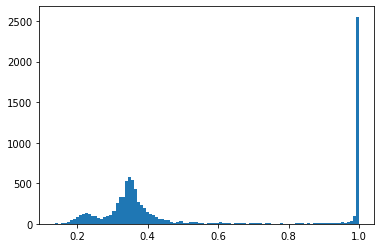

In [59]:
if __name__ == '__main__':
    main(train_df)

if CFG.epochs > 100:
    from IPython.display import clear_output  # セルの出力削除（1000epもログあると重すぎるので消す）
    clear_output()

In [60]:
#%debug

In [61]:
#=====

# Predict and submit

In [62]:
def _tta(img, ops):
    # input: NxCxHxW
    if ops == 0:
        pass
    elif ops == 1:
        img = torch.flip(img, [-1])
    elif ops == 2:
        img = torch.flip(img, [-2])
    elif ops == 3:
        img = torch.flip(img, [-1, -2])
    elif ops == 4:
        img = torch.rot90(img, 1, [2, 3])
    elif ops == 5:
        img = torch.rot90(img, 3, [2, 3])
    else:
        pass
    return img

In [63]:
@torch.inference_mode()  # pytorch >= 1.9
def inference(model, pth, test_loader, device, tta_transforms=None):
    if len(CFG.device_ids) > 1:
        model.load_state_dict(loadpth(pth))
    else:
        model.load_state_dict(torch.load(pth)['model'])
    model.eval().to(device)
    
    if len(CFG.device_ids) > 1:
        LOGGER.info(f"=> inference is_multiGPU {CFG.device_ids}")
        model = nn.DataParallel(model)  # make parallel
        cudnn.benchmark = True
    
    # ttach
    if tta_transforms is not None:
        model = tta.ClassificationTTAWrapper(model, tta_transforms)
    
    tta_ops = [0]
    tta_ops = [0, 1, 2]  # orig, hflip, vflip
    #tta_ops = [0, 1]  # orig, hflip
    #tta_ops = [0, 2]  # orig, vflip
    print("tta_ops:", tta_ops)
    
    preds = []
    for i, (images, _, _) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.to(device)
        outputs = None

        with torch.no_grad():
            for _ops in tta_ops:
                o, _ = model( _tta(images, _ops) )  # for MultiOutput
                if outputs is None:
                    outputs = o
                else:
                    outputs += o
        outputs /= len(tta_ops)
        # for BCE
        preds.append(outputs.sigmoid().cpu().detach().numpy())
    
    predictions = np.concatenate(preds)
    
    # 推論うまくいかず欠損になったのは0にする
    predictions = np.nan_to_num(predictions, nan=0)
    
    del model
    gc.collect()
    torch.cuda.empty_cache()
    
    return predictions

In [64]:
def main_test(test, pths, tta_transforms=None, transforms_type="valid", test_dataset=None):
    model = eval(CFG.model_cls)()
    if test_dataset is None:
        test_dataset = TrainDataset(test, 
                                    transforms=get_transforms(data=transforms_type),
                                    is_npy=CFG.is_npy,
                                    is_add_ch=CFG.is_add_ch,
                                   )
    test_loader = DataLoader(test_dataset, 
                             batch_size=CFG.batch_size * 2, 
                             shuffle=False, 
                             num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    predictions = None
    for pth in pths:
        print("pth:", pth)
        
        # inference
        if predictions is None:
            predictions = inference(model, pth, test_loader, device, tta_transforms)
        else:
            predictions += inference(model, pth, test_loader, device, tta_transforms)

    test['preds'] = predictions / len(pths)
    
    return test

In [65]:
# ttach param
# https://www.guruguru.science/competitions/17/discussions/4864ee81-6336-4cad-bb74-a4c9b46e6eb2/
tta_transforms = tta.Compose(
    [
        #tta.HorizontalFlip(),
        #tta.VerticalFlip(),
        #tta.Rotate90(angles=[0, 90, 180, 270]),  # 90度回転
        #tta.Scale(scales=[0.9, 1.1], interpolation="nearest"),  # 画像の大きさscales倍. h * scale_factor, w * scale_factor
        #tta.Add(values=[-1, 0, 1, 2]),  # 画素にfactorの値足す. x + value
        #tta.Multiply(factors=[0.9, 1, 1.1]),  # 画素をfactor倍. x * factor
        #tta.FiveCrops(crop_height=CFG.size//3, crop_width=CFG.size//3),  # 画像を5分割. crop_height: cropする画像の高さ. crop_width: cropする画像の幅
        #tta.Resize(sizes=[(224, 224), (384, 384)], original_size=(CFG.size, CFG.size), interpolation="nearest")  # 指定の大きさにリサイズ
    ]
)
tta_transforms = None

In [66]:
# ==========================================================
# valid inference
# ==========================================================
seed = CFG.seeds[0]
valid = pd.read_csv(OUTPUT_DIR + f"/folds_seed{seed}.csv")

# tta inference
score_list = []
pred_valid = pd.DataFrame()
for fold in CFG.trn_fold:
    print(f"===== valid fold{fold} =====")
    
    # model pths
    pths = sorted(glob.glob(OUTPUT_DIR + f"/*_fold{fold}*_best_score.pth"))
    #pths = sorted(glob.glob(OUTPUT_DIR + f"/*_fold{fold}*_best_loss.pth"))
    print(pths)
    
    valid_f = valid[valid.fold == fold]
    print(valid_f.shape)
    
    valid_f = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="valid")
    
    ## =============================
    ## tta alb
    ## =============================
    #valid_f_tta1 = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="tta1")
    #valid_f_tta1 = valid_f_tta1.rename(columns={"preds": "preds_tta1"})
    #
    #valid_f = pd.merge(valid_f, valid_f_tta1[["id", "preds_tta1"]], on="id")
    #valid_f["preds"] = (valid_f["preds"].to_numpy() + valid_f["preds_tta1"].to_numpy()) / 2.0
    ## =============================
    
    ## =============================
    ## tta Dataset
    ## =============================
    #_test_dataset = TrainDataset(valid_f, 
    #                             transforms=get_transforms(data="valid"),
    #                             #prob_spec_start_random=1.0,
    #                             #prob_vshift=1.0,  # CV悪化
    #                             #prob_swap_nega=1.0,  # CV悪化
    #                             is_npy=CFG.is_npy,
    #                             is_add_ch=CFG.is_add_ch,
    #                           )
    #valid_f_ttaD = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="valid", test_dataset=_test_dataset)
    #valid_f_ttaD = valid_f_ttaD.rename(columns={"preds": "preds_ttaD"})
    #
    #valid_f = pd.merge(valid_f, valid_f_ttaD[["id", "preds_ttaD"]], on="id")
    #valid_f["preds"] = (valid_f["preds"].to_numpy() + valid_f["preds_ttaD"].to_numpy()) / 2.0
    ## =============================
    
    score = get_result(valid_f, preds_col="preds", add_info=f"TTA fold{fold} ")
    score_list.append(score)
    pred_valid = pd.concat([pred_valid, valid_f])
    
print(f"macro mean folds Score ± std: {round(np.mean(score_list), 4)} ± {round(np.std(score_list), 4)}")
tta_oof_score = get_result(pred_valid, preds_col="preds", add_info=f"TTA oof ")
pred_valid.to_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{seed}_tta.csv', index=False)
display(pred_valid.head())

#if CFG.is_wandb:
##    # save log wandb
##    wandb.log({f"TTA oof Score": tta_oof_score})

===== valid fold0 =====
['./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000_fold0_seed0_best_score.pth']
(1800, 38)
pth: ./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000_fold0_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|████████████████████████████████████████| 15/15 [00:11<00:00,  1.32it/s]
TTA fold0 Score: 0.8536


===== valid fold1 =====
['./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000_fold1_seed0_best_score.pth']
(1800, 38)
pth: ./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000_fold1_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|████████████████████████████████████████| 15/15 [00:11<00:00,  1.29it/s]
TTA fold1 Score: 0.8577


===== valid fold2 =====
['./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000_fold2_seed0_best_score.pth']
(1800, 38)
pth: ./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000_fold2_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|████████████████████████████████████████| 15/15 [00:11<00:00,  1.28it/s]
TTA fold2 Score: 0.8738


===== valid fold3 =====
['./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000_fold3_seed0_best_score.pth']
(1800, 38)
pth: ./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000_fold3_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|████████████████████████████████████████| 15/15 [00:11<00:00,  1.28it/s]
TTA fold3 Score: 0.8375


===== valid fold4 =====
['./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000_fold4_seed0_best_score.pth']
(1800, 38)
pth: ./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000_fold4_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|████████████████████████████████████████| 15/15 [00:11<00:00,  1.30it/s]
TTA fold4 Score: 0.8606
TTA oof Score: 0.8474


macro mean folds Score ± std: 0.8567 ± 0.0117


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.252390   
12  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.247005   
17  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.250768   
18  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.256312   
32  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.257586   

     l1_mean    h1_std    l1_std  freq_min//N  fold  sqrtSX  F0 type dir_name  \
5   2.253793  0.400924  0.401087          6.0     0     NaN NaN  NaN      NaN   
12  2.250381  0.398699  0.399798          9.0     0     NaN NaN  NaN      NaN   
17  2.253459  0.403756  0.401150          1.0     0     NaN NaN  NaN      NaN   
18  2.249809  0.401606  0.402489          1.0     0     NaN NaN  NaN      NaN   
32  2.257342  0.408922  0.412729          9.0     0     NaN NaN  NaN      NaN   

    F1  h0deg  h1_minstd  h1_maxstd  h1_stddiff  l1_minstd  l1_maxstd  \
5  NaN    NaN        NaN        NaN         NaN        NaN        NaN   
12 NaN    NaN        NaN        NaN         NaN        NaN        NaN   
17 NaN    NaN        NaN        NaN         NaN        NaN        NaN   
18 NaN    NaN        NaN        NaN         NaN        NaN        NaN   
32 NaN    NaN        NaN        NaN         NaN        NaN        NaN   

    l1_stddiff  h1_max/l1_max  real_sim     preds  
5          NaN            NaN       NaN  0.997900  
12         NaN            NaN       NaN  0.350261  
17         NaN            NaN       NaN  0.999918  
18         NaN            NaN       NaN  0.999232  
32         NaN            NaN       NaN  0.999899

In [67]:
#%debug

In [68]:
#=====

['./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000_fold0_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000_fold1_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000_fold2_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000_fold3_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000_fold4_seed0_best_score.pth']
pth: ./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000_fold0_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|████████████████████████████████████████| 63/63 [00:49<00:00,  1.26it/s]


pth: ./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000_fold1_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|████████████████████████████████████████| 63/63 [00:49<00:00,  1.27it/s]


pth: ./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000_fold2_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|████████████████████████████████████████| 63/63 [00:49<00:00,  1.27it/s]


pth: ./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000_fold3_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|████████████████████████████████████████| 63/63 [00:49<00:00,  1.28it/s]


pth: ./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000_fold4_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|████████████████████████████████████████| 63/63 [00:49<00:00,  1.28it/s]


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.291497   
1  1.248537e+09         42746.0  0.423857   
2  1.248567e+09         55878.0  0.278298   
3  1.248537e+09         48020.0  0.481413   
4  1.248543e+09         45246.0  0.340884   

                                                path  orig  freq_min//10  \
0  /workspace/g2net2/pyfstat_output/largekernel|p...     1          30.0   
1  /workspace/g2net2/pyfstat_output/largekernel|p...     1          12.0   
2  /workspace/g2net2/pyfstat_output/largekernel|p...     1          19.0   
3  /workspace/g2net2/pyfstat_output/largekernel|p...     1           9.0   
4  /workspace/g2net2/pyfstat_output/largekernel|p...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std     h1_minstd     h1_maxstd  \
0  2.251338  2.247327  0.397542  0.397476  1.058791e-22  1.058791e-22   
1  2.250531  2.253083  0.399520  0.399918  1.058791e-22  1.058791e-22   
2  2.249787  2.250360  0.399082  0.401004  1.058791e-22  1.058791e-22   
3  2.251309  2.250812  0.399954  0.399532  1.058791e-22  1.058791e-22   
4  2.250533  2.250065  0.402394  0.400455  1.058791e-22  1.058791e-22   

   h1_stddiff     l1_minstd     l1_maxstd  l1_stddiff  h1_max/l1_max  \
0         0.0  1.058791e-22  1.058791e-22         0.0       1.085967   
1         0.0  1.058791e-22  1.058791e-22         0.0       0.971284   
2         0.0  1.058791e-22  1.058791e-22         0.0       1.037622   
3         0.0  1.058791e-22  1.058791e-22         0.0       1.025819   
4         0.0  1.058791e-22  1.058791e-22         0.0       0.976649   

   real_sim  freq_min//N     preds  
0         0          6.0  0.291497  
1         0          2.0  0.423857  
2         0          3.0  0.278298  
3         0          1.0  0.481413  
4         0          9.0  0.340884

target range [0.072698, 0.999823]


id    target
0     00054c878  0.291497
1     0007285a3  0.423857
2     00076c5a6  0.278298
3     001349290  0.481413
4     001a52e92  0.340884
...         ...       ...
7970  ffbce04ef  0.994236
7971  ffc2d976b  0.271217
7972  ffc905909  0.238540
7973  ffe276f3e  0.311535
7974  fffa17f67  0.264579

[7975 rows x 2 columns]

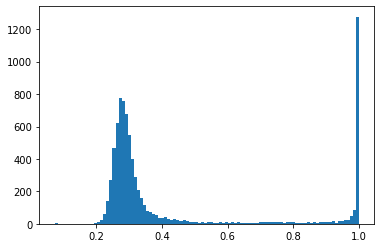

In [69]:
if IS_MAKE_SUB:
    # model pths
    pths = sorted(glob.glob(OUTPUT_DIR + "/*best_score.pth"))
    #pths = sorted(glob.glob(OUTPUT_DIR + "/*best_loss.pth"))
    print(pths)

    # ==========================================================
    # test inference
    # ==========================================================
    submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="valid")

    ## =============================
    ## tta alb
    ## =============================
    #submit_tta1 = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="tta1")
    #submit_tta1 = submit_tta1.rename(columns={"preds": "preds_tta1"})
    #
    #submit = pd.merge(submit, submit_tta1[["id", "preds_tta1"]], on="id")
    #submit["preds"] = (submit["preds"].to_numpy() + submit["preds_tta1"].to_numpy()) / 2.0
    ## =============================

    submit["target"] = submit["preds"].to_numpy()
    display(submit.head())
    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_test.csv', index=False)
    
    submit = submit[["id", "target"]]
    print('target range [%.6f, %.6f]' % (submit['target'].min(), submit['target'].max()))

    # Write prediction
    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_submission.csv', index=False)
    display(submit)

    plt.hist(submit["target"], bins=100)
    plt.show()
    plt.clf()  # メモリ解放
    plt.close()

In [70]:
if CFG.is_wandb:
    wandb.finish()

In [71]:
## submitファイル連結
#if IS_MAKE_SUB:
#    
#    # シュミレーションデータのsubmitファイル
#    _name = CFG.name.replace("_real", "_sim")
#    sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_submission.csv'
#    
#    if os.path.isfile(sim_csv):
#        submit_real = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_submission.csv')
#        submit_sim = pd.read_csv(sim_csv)
#        submit = pd.concat([submit_sim, submit_real])
#        
#        # 行の順番をtest_dfの順番にする
#        test_df = pd.read_csv(INPUT_DIR_TEST + '/sample_submission.csv')
#        submit = pd.merge(test_df[["id"]], submit, on="id")
#        
#        submit = submit[["id", "target"]]
#        print('target range [%.6f, %.6f]' % (submit['target'].min(), submit['target'].max()))
#
#        # Write prediction
#        submit.to_csv(OUTPUT_DIR + f'/{CFG.name.split("_real")[0]}_sim_real_submission.csv', index=False)
#        display(submit)
#
#        plt.hist(submit["target"], bins=100)
#        plt.show()
#        plt.clf()  # メモリ解放
#        plt.close()

# Stacking

In [72]:
#### stacking用にtest set全体で推論
#test_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/test_summary.csv").rename(columns={"Unnamed: 0":'id'})
#test_df["target"] = 0.5
#if cfg_is_npy:
#    test_df["path"] = f"{_npy_dir}/test/" + test_df["id"] + ".npy"
#else:
#    test_df["path"] = INPUT_DIR_TEST + "/test/" + test_df["id"] + ".hdf5"
#    
#if IS_MAKE_SUB:
#    pths = sorted(glob.glob(OUTPUT_DIR + "/*best_score.pth"))
#    #pths = sorted(glob.glob(OUTPUT_DIR + "/*best_loss.pth"))
#    
#    submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="valid")
#
#    submit["target"] = submit["preds"].to_numpy()
#    display(submit.head())
#    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_test_all.csv', index=False)

In [73]:
import joblib
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def set_seed(seed=0):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)


def table_train_fn(df, feature_cols, target_col, out_dir):
    os.makedirs(out_dir, exist_ok=True)

    lgb_params = {
            "objective": "binary",
            "learning_rate": 0.03,
            "n_estimators": 100_000,
        }
    
    Y_pred = np.zeros((len(df)))

    for i in tqdm(CFG.seeds):
        print(f"------------ seed:{i} ------------")
        set_seed(seed=i)
        folds = df.copy()

        for j in range(CFG.n_fold):
            print(f"------------ fold:{j} ------------")

            train = folds[folds["fold"] != j]
            val = folds[folds["fold"] == j]
            val_idx = val.index
            
            X_train, X_val = train[feature_cols], val[feature_cols]
            y_train, y_val = train[target_col], val[target_col]
            X_train, X_val = X_train.values, X_val.values
            y_train, y_val = y_train.values, y_val.values

            ### lgb.LGBMClassifier
            #model = lgb.LGBMClassifier(random_state=i, **lgb_params)
            #model.fit(X_train, y_train,
            #          eval_set=[(X_val, y_val)],
            #          eval_metric="error",
            #          early_stopping_rounds=100,
            #          verbose=-1,
            #         )
            
            ### RandomForestClassifier
            #model = RandomForestClassifier(random_state=i)
            #model = model.fit(X_train, y_train)
            
            ### LogisticRegression
            model = LogisticRegression(random_state=i)
            model = model.fit(X_train, y_train)
            
            pred = model.predict_proba(X_val) / len(CFG.seeds)
            Y_pred[val_idx] += pred[:,1]
            
            joblib.dump(model, out_dir + f"/model_seed_{i}_fold_{j}_{target_col}.jlb", compress=True)

    folds["pred"] = Y_pred
    print("oof score:", get_score(folds[target_col].values, folds["pred"].values))
    
    folds.to_csv(out_dir + f"/{target_col}_oof.csv", index=False)
    
    return folds

def table_test_fn(df, feature_cols, target_col, out_dir, model_paths):
    os.makedirs(out_dir, exist_ok=True)
    X = df[feature_cols]
    Y_pred = np.zeros((len(df)))
    for m_p in sorted(model_paths):
        model = joblib.load(m_p)
        
        ### LogisticRegression
        print("model.coef_:", model.coef_)
        
        pred = model.predict_proba(X) / len(model_paths)
        Y_pred += pred[:,1]
    df[target_col] = Y_pred
    df[["id", "target"]].to_csv(out_dir + f"/{target_col}_sub.csv", index=False)
    return df


#### train
#_name = CFG.name.replace("_real", "_sim")
#sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_oof_df_seed{CFG.seeds[0]}.csv'
#if os.path.isfile(sim_csv):
#    sim_oof = pd.read_csv(sim_csv)
#    real_oof = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{CFG.seeds[0]}.csv')
#    stacking_oof = pd.merge(real_oof[["id", "target", "fold", "preds"]], sim_oof[["id", "preds"]], on="id")
#    stacking_oof = stacking_oof.rename(columns={"preds_x":'real_p', "preds_y":'sim_p'})
#    #display(stacking_oof)
#    _ = table_train_fn(stacking_oof, ["real_p", "sim_p"], "target", OUTPUT_DIR + "/stacking")
#
#### test
#_name = CFG.name.replace("_real", "_sim")
#sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_test_all.csv'
#if os.path.isfile(sim_csv):
#    sim_sub = pd.read_csv(sim_csv)
#    real_sub = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_test_all.csv')
#    stacking_sub = pd.merge(real_sub[["id", "target"]], sim_sub[["id", "target"]], on="id")
#    stacking_sub = stacking_sub.rename(columns={"target_x":'real_p', "target_y":'sim_p'})
#    stacking_sub = table_test_fn(stacking_sub, ["real_p", "sim_p"], "target", OUTPUT_DIR + "/stacking", 
#                                 glob.glob(OUTPUT_DIR + "/stacking/*.jlb"))
#    display(stacking_sub)
#    plt.hist(stacking_sub["target"], bins=100)
#    plt.show()
#    plt.clf()  # メモリ解放
#    plt.close()